In [1]:
import os
os.chdir('../')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torch
import datetime
import wandb
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from lateral_connections.model_factory import load_model_by_key, get_config_by_key
from lateral_connections.loaders import *

config = get_config_by_key('tiny_lateral_net')
config

{'num_multiplex': 4,
 'lcl_distance': 2,
 'lcl_alpha': 0.001,
 'lcl_theta': 0.2,
 'lcl_eta': 0.0,
 'lcl_iota': 0.2,
 'batch_size': 10,
 'conv_channels': 10,
 'learning_rate': 0.0003,
 'num_classes': 10,
 'run_identifier': ''}

In [4]:
model_path = 'models/tiny_cnn/TinyCNN_2022-06-15_215423__it20000_e4.pt'
tiny_cnn_model = load_model_by_key('tiny_cnn', model_path=model_path)
tiny_cnn_model

TinyCNN(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_act): Tanh()
  (maxpool): AdaptiveMaxPool2d(output_size=(14, 14))
  (fc1): Linear(in_features=1960, out_features=100, bias=True)
  (fc1_act): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [5]:
model = load_model_by_key('tiny_lateral_net', config=config)
model.transfer_cnn_weights(tiny_cnn_model)
print(model)

base_name = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
wandb_run_name = base_name
wandb_group_name = 'TinyLateralNet'

wandb.login(key='efd0a05b7bd26ed445bf073625a373b845fc9385')
wandb.init(
    project='MT_LateralConnections',
    entity='lehl',
    #group=wandb_group_name,
    group='debug',
    name=wandb_run_name,
    config=get_config_by_key('tiny_lateral_net'),
    mode='disabled'
)

TinyLateralNet(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_act): Tanh()
  (maxpool): AdaptiveMaxPool2d(output_size=(14, 14))
  (fc1): Linear(in_features=1960, out_features=100, bias=True)
  (fc1_act): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
  (lcl): LaterallyConnectedLayer3(4, (10, 14, 14), d=2, disabled=False, update=True)
)


wandb: Currently logged in as: lehl (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/claude/.netrc


In [6]:
images = torch.rand((4, 1, 28, 28))
model(images.to(model.device)).shape

torch.Size([4, 10])

In [7]:
def small_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
    ])

dataset = MNIST('images/mnist/', train=True, transform=small_transform(), download=True)

train_size = 50000
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=1)

corrupt_dataset = load_mnistc('line')

corrupt_loader = torch.utils.data.DataLoader(corrupt_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=1)

In [8]:
next(iter(train_loader))[0].shape

torch.Size([10, 1, 28, 28])

[INFO]: Epoch 0 of 1


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

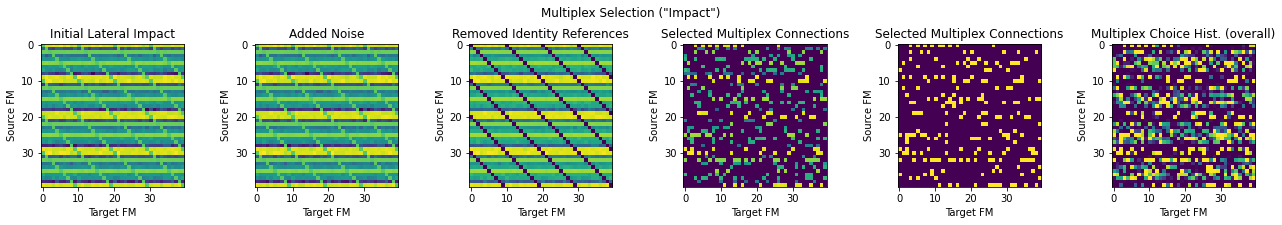

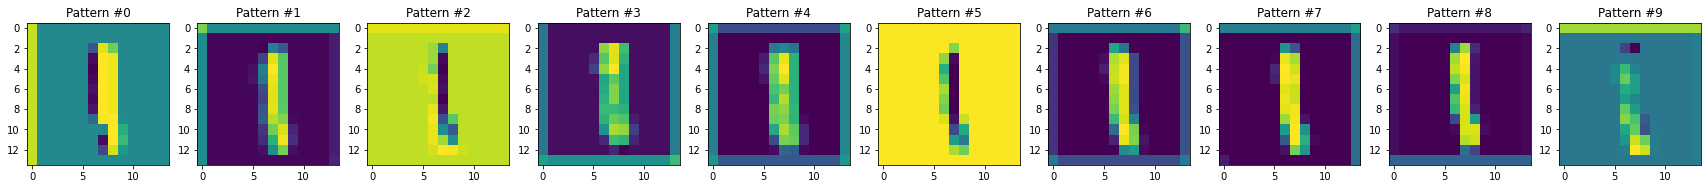

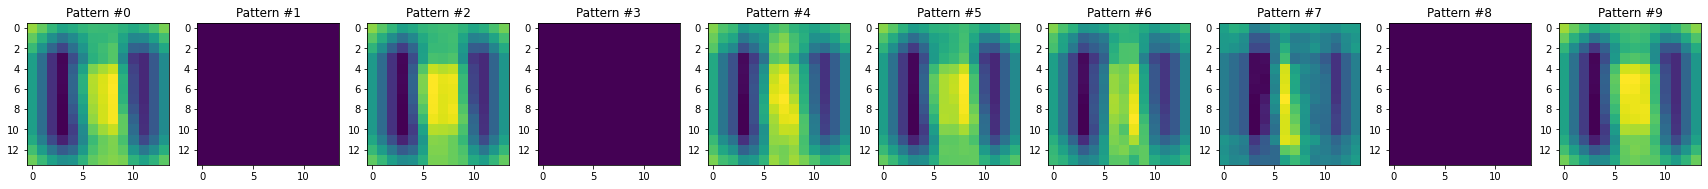

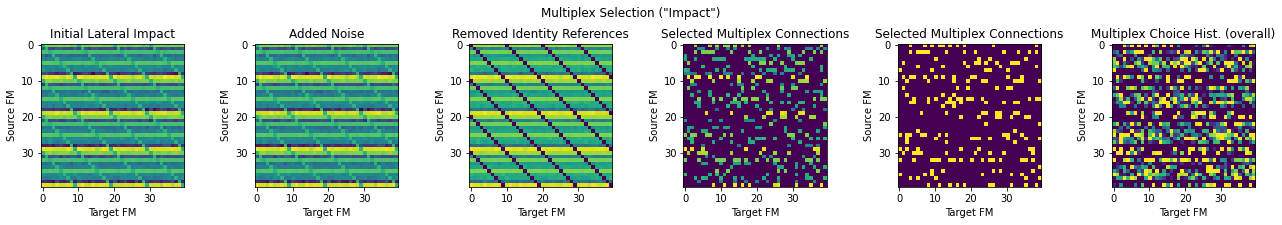

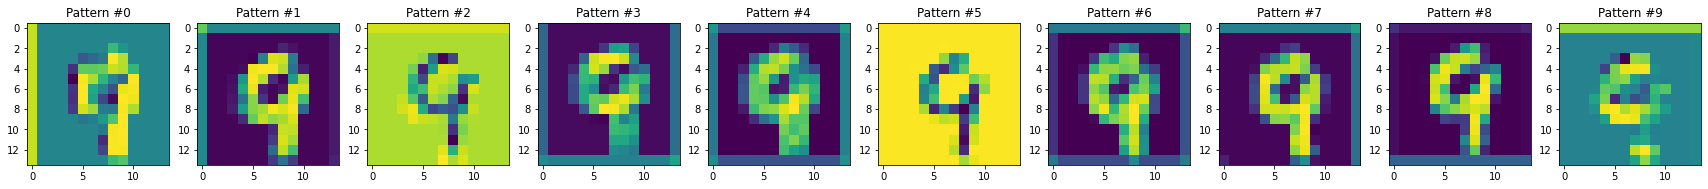

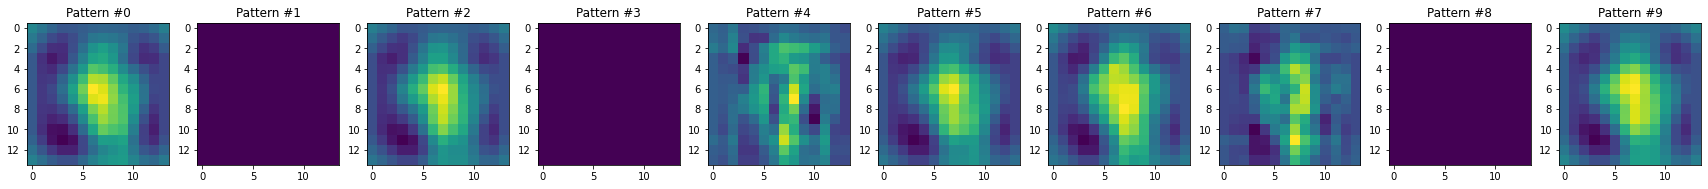

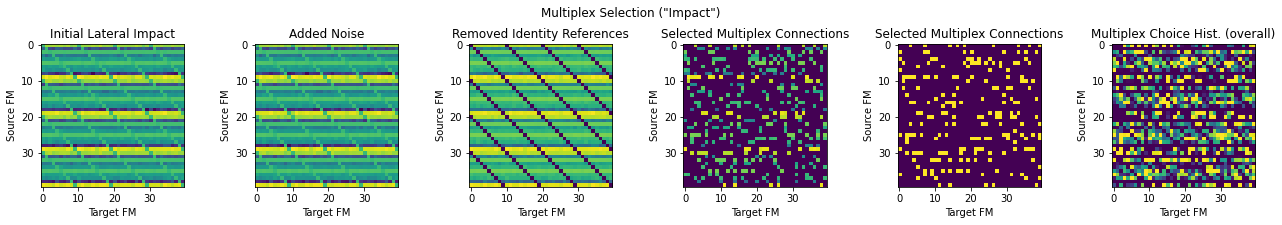

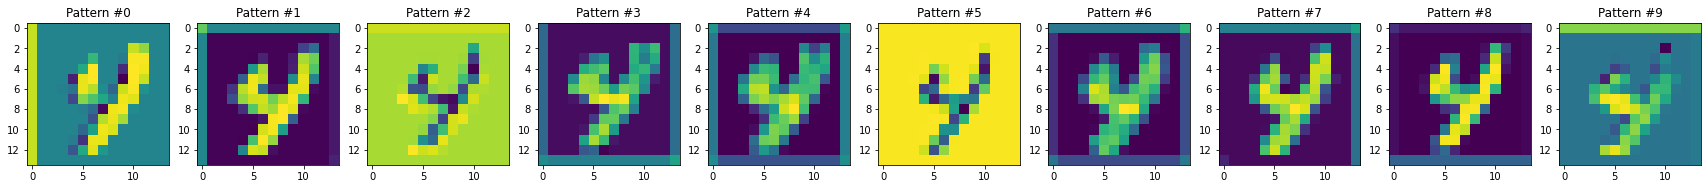

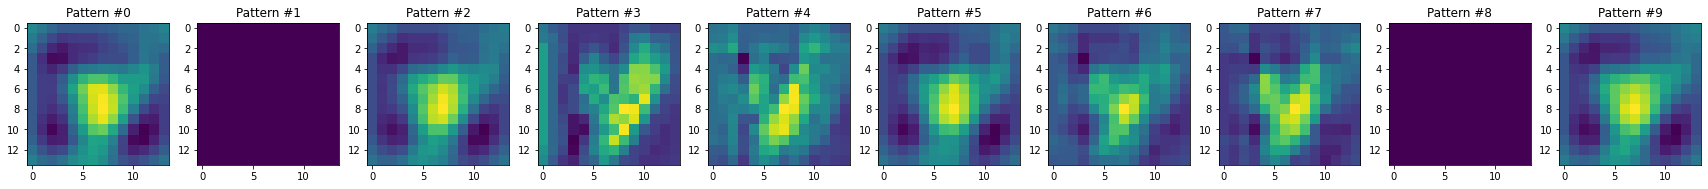

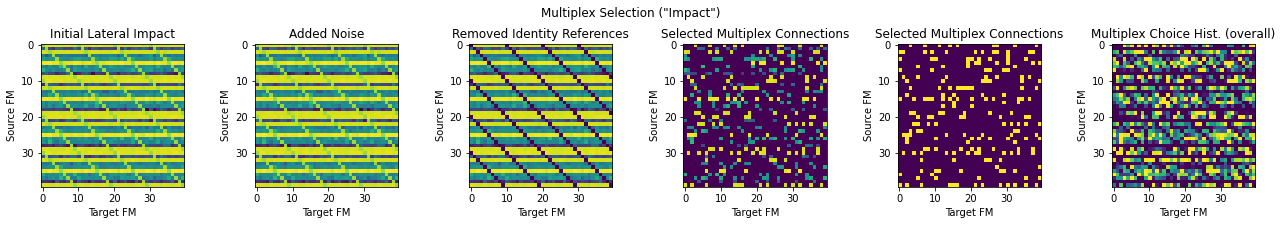

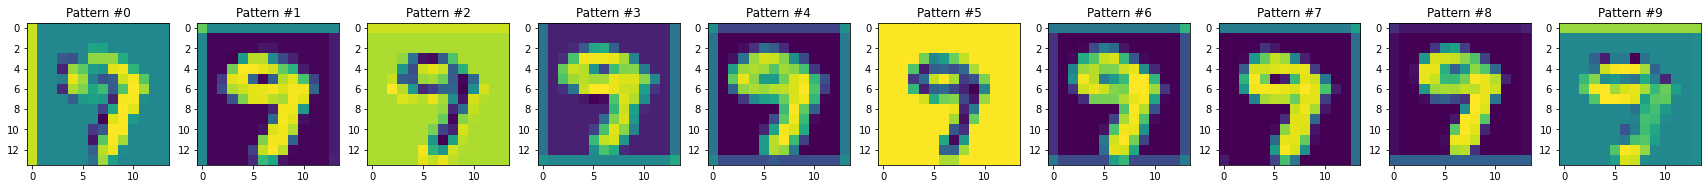

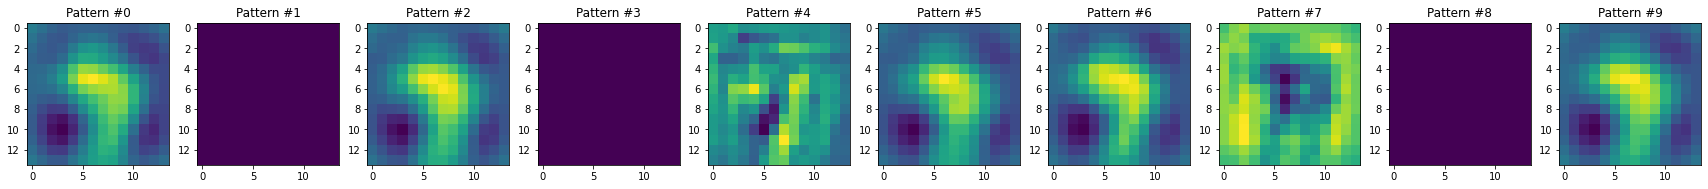

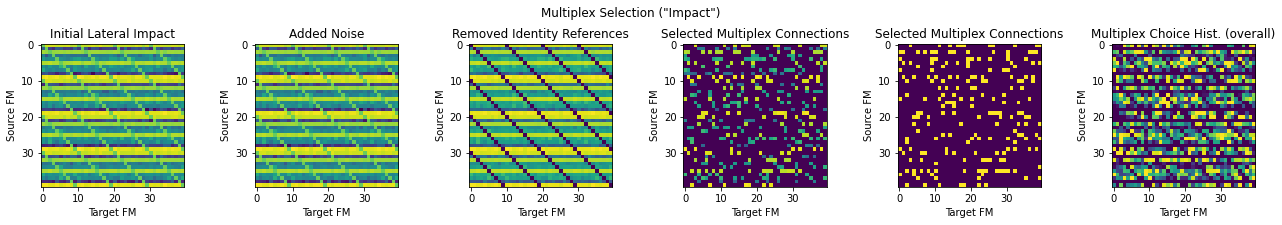

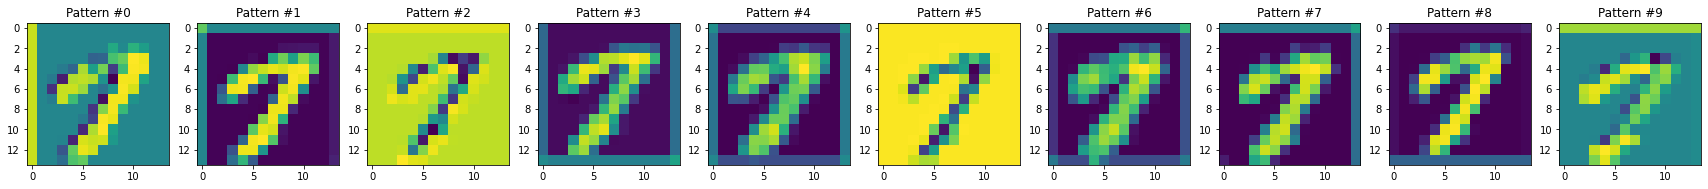

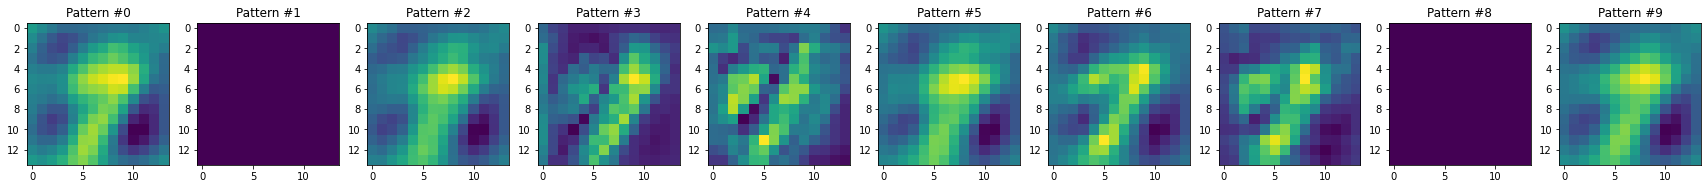

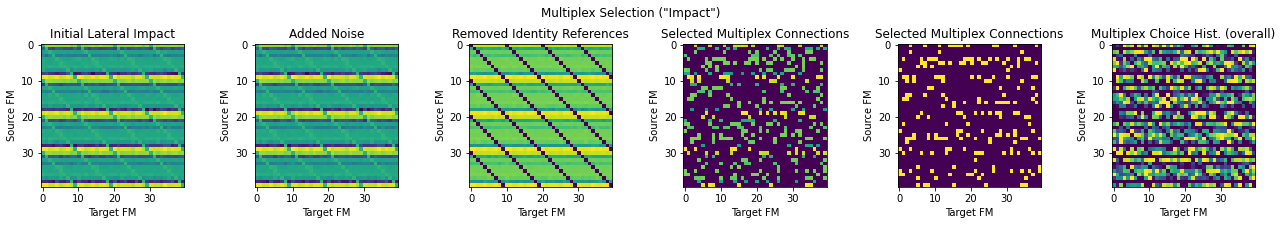

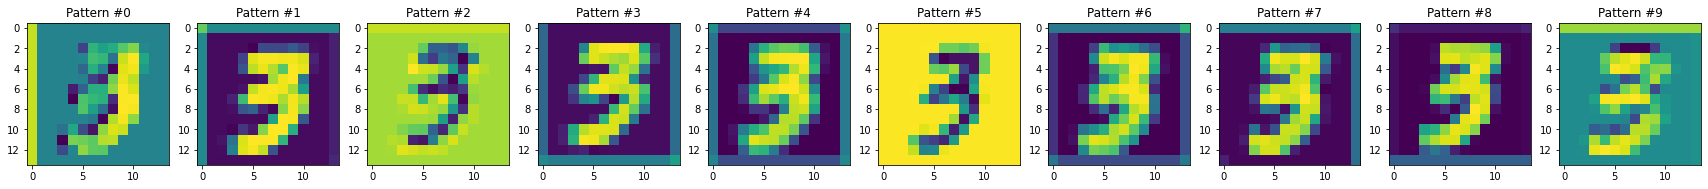

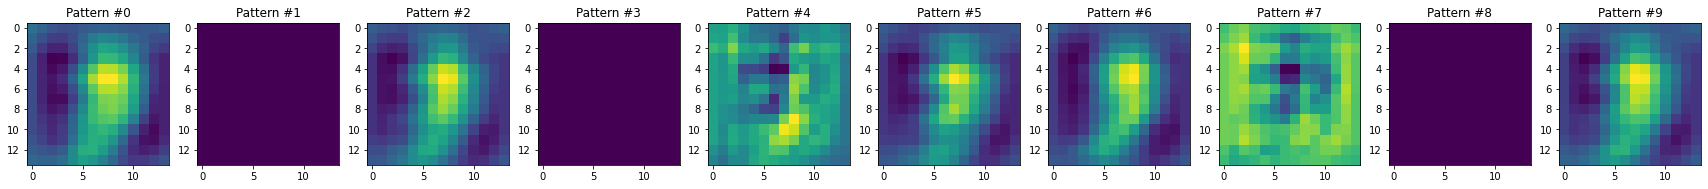

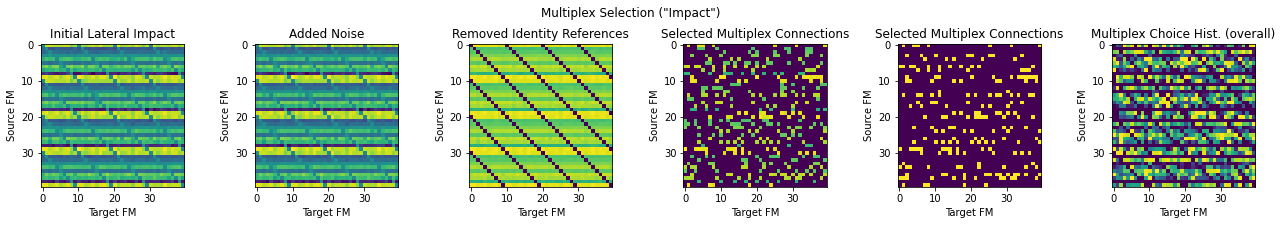

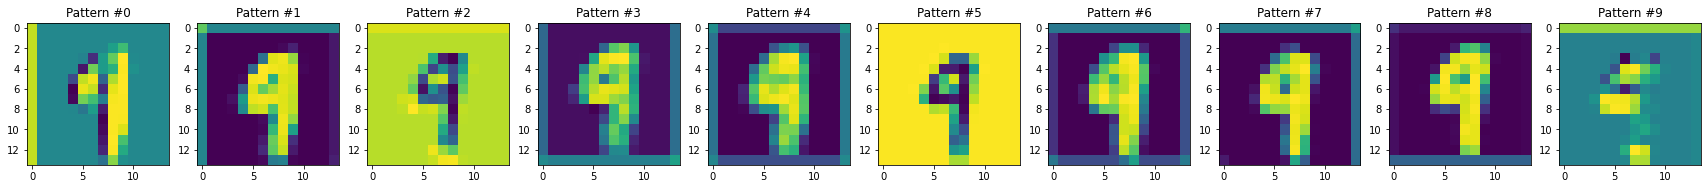

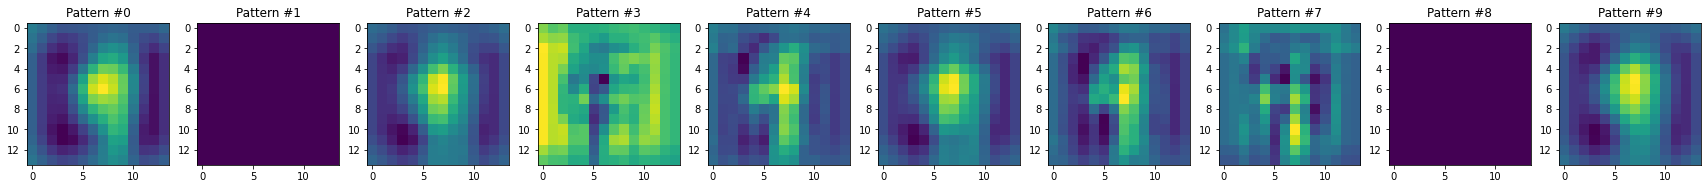

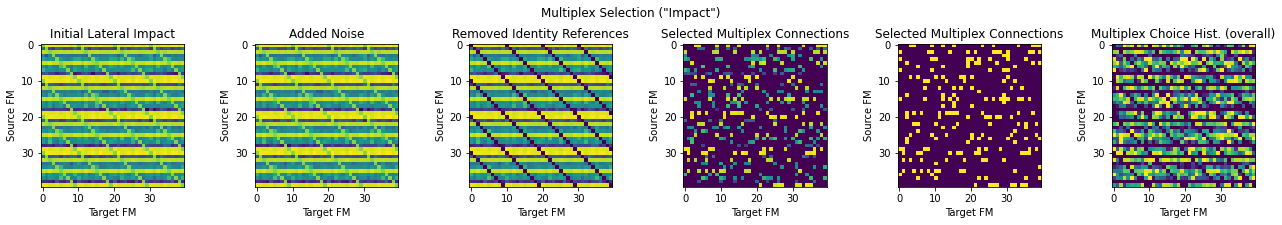

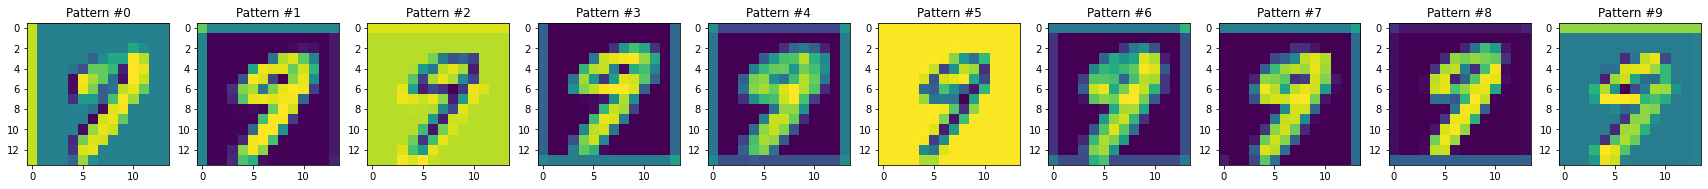

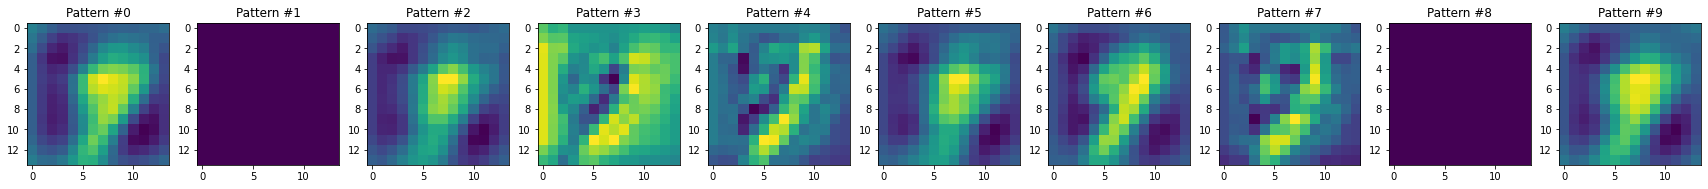

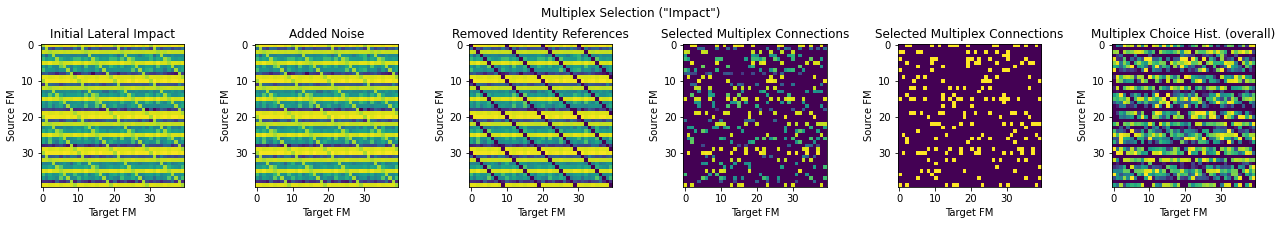

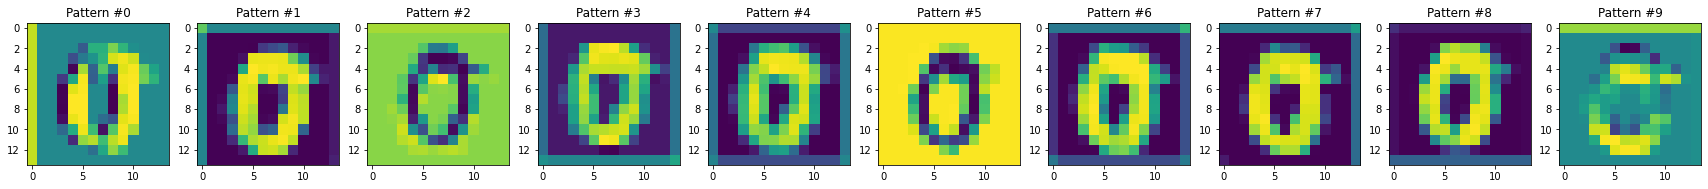

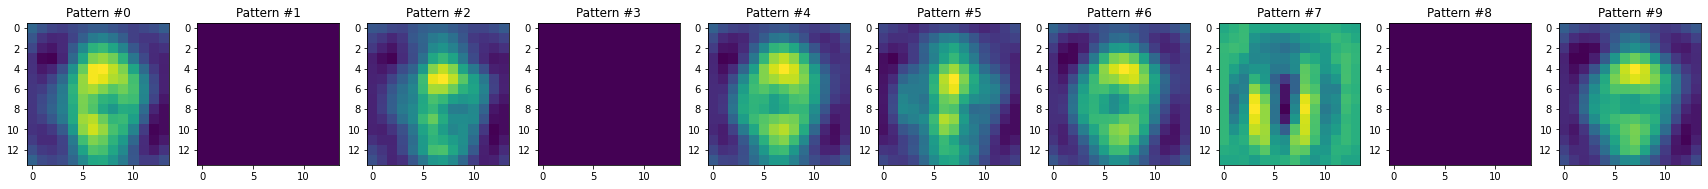

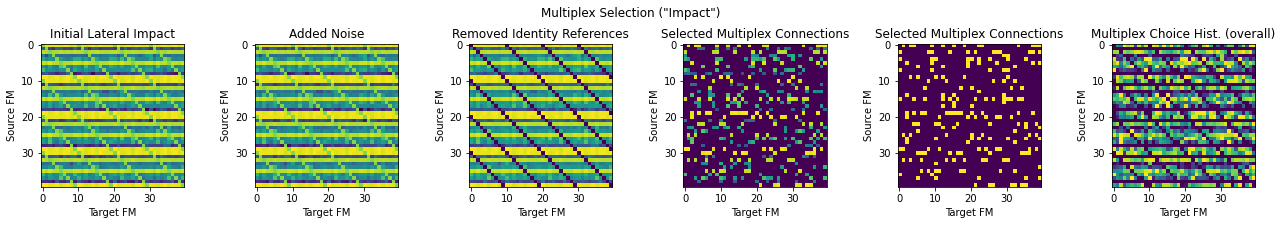

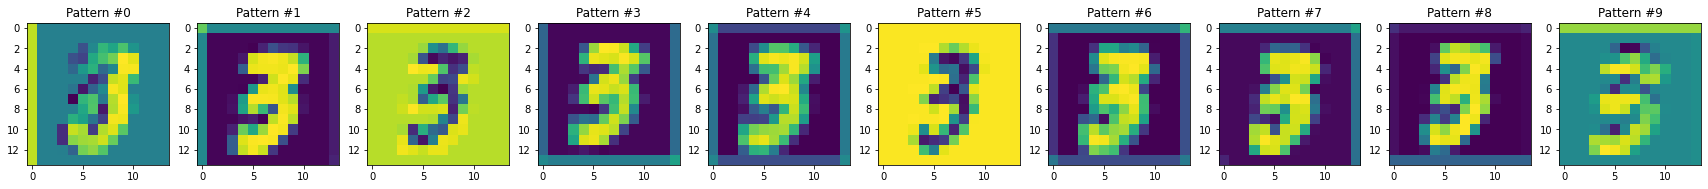

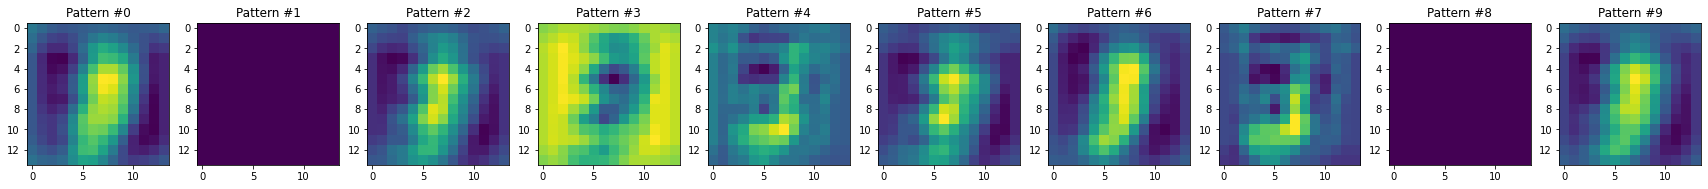

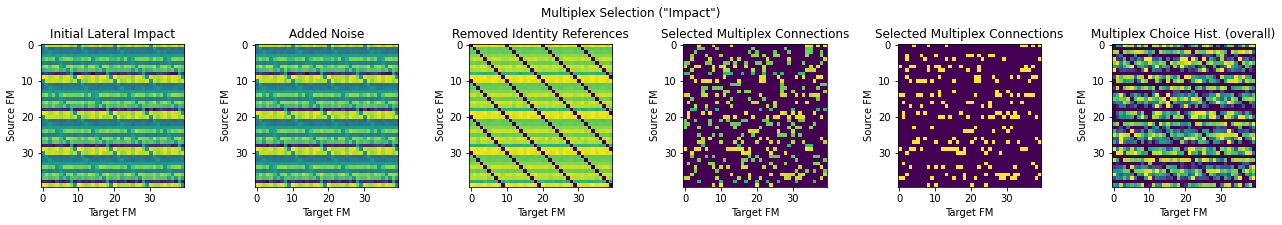

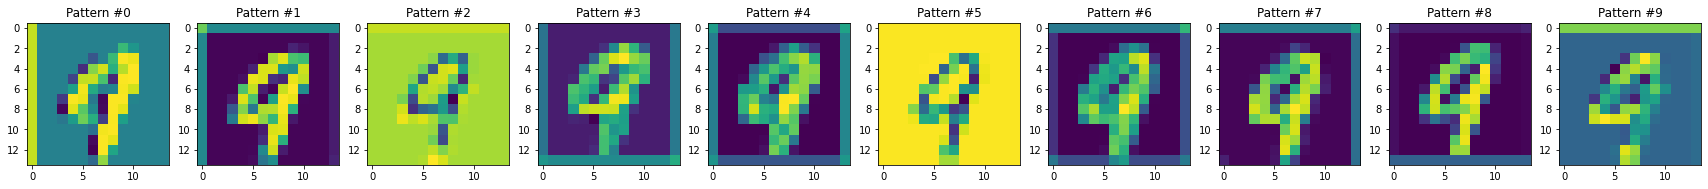

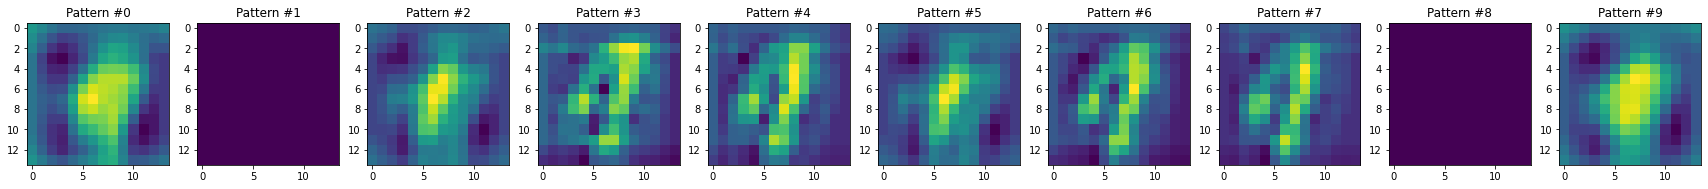

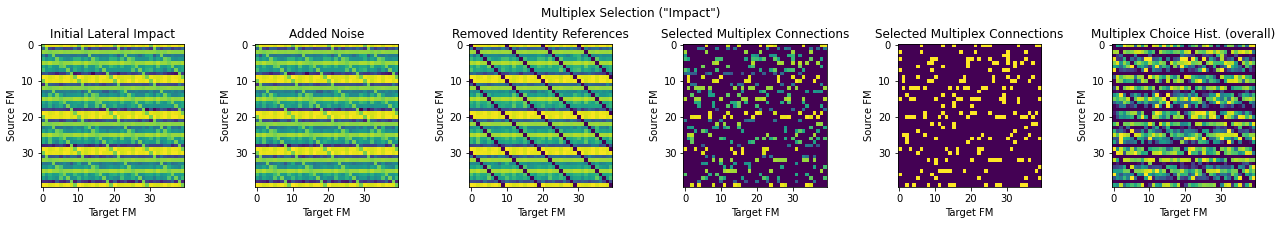

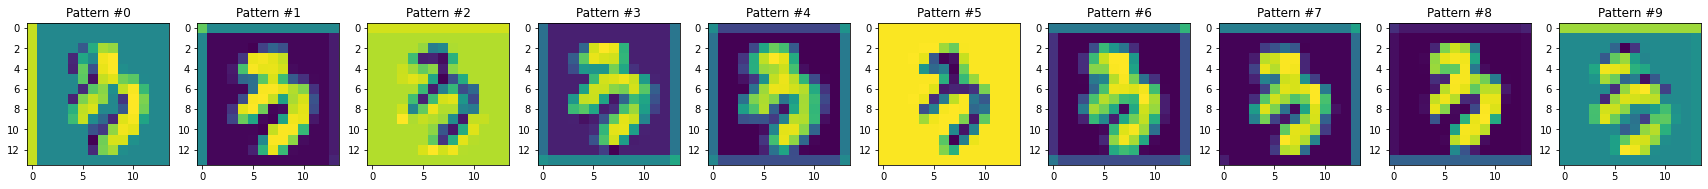

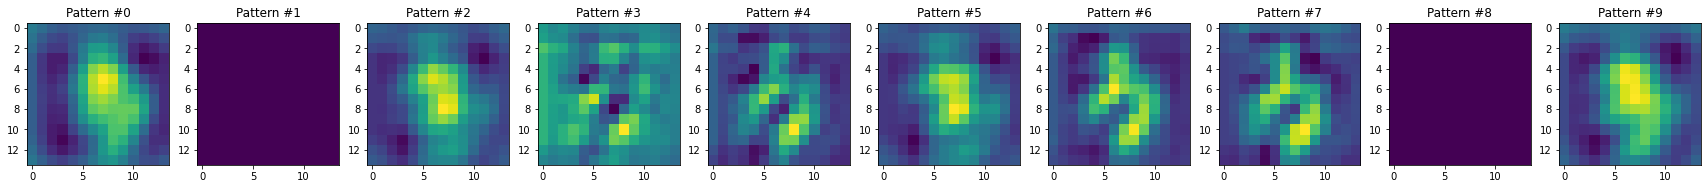

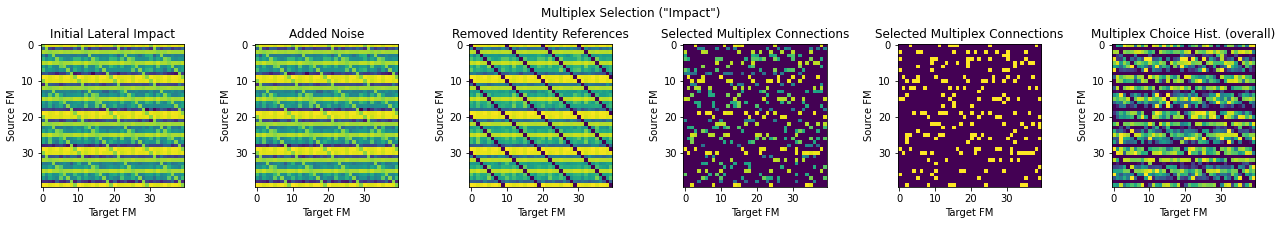

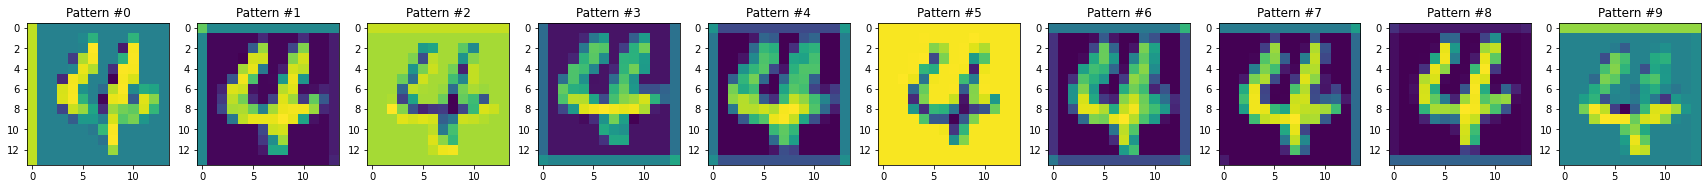

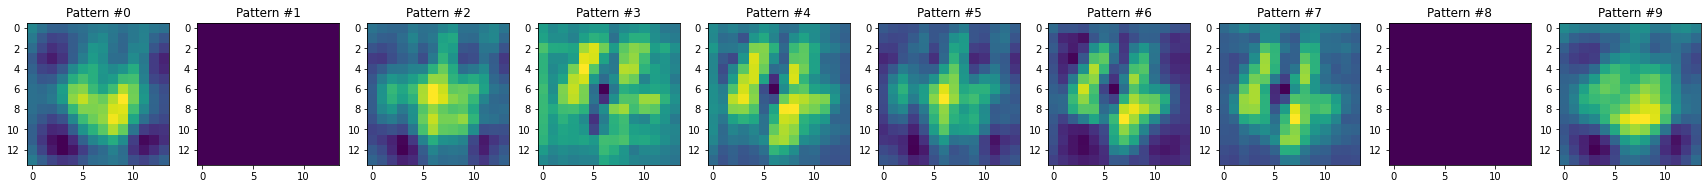

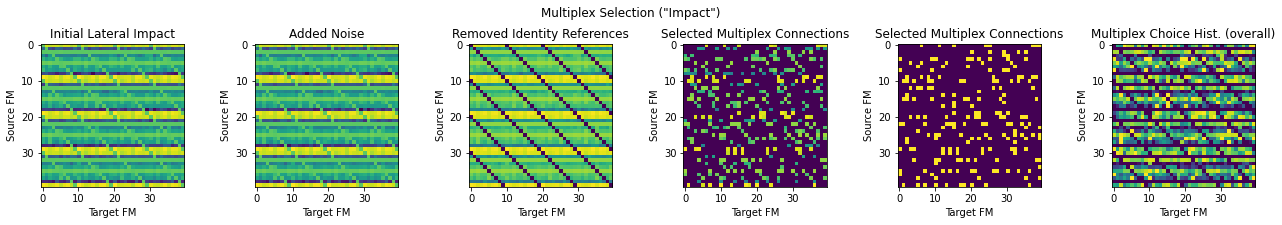

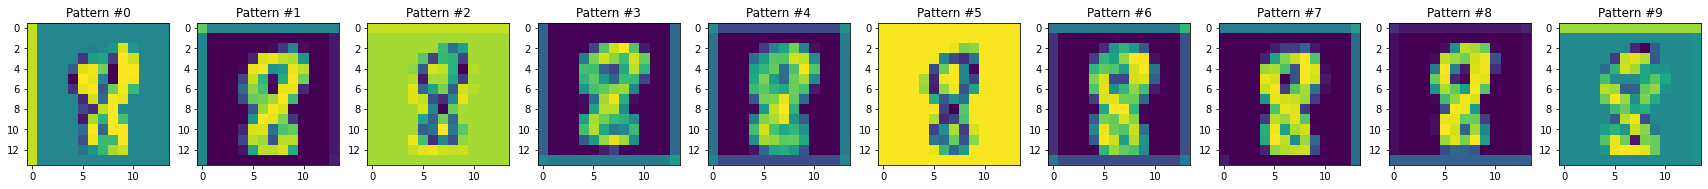

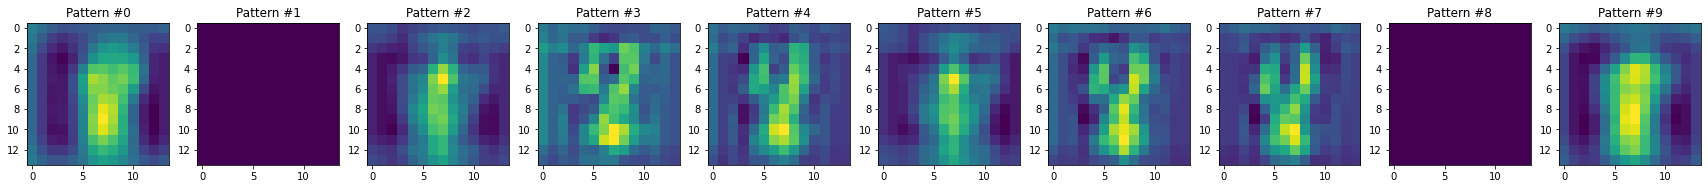

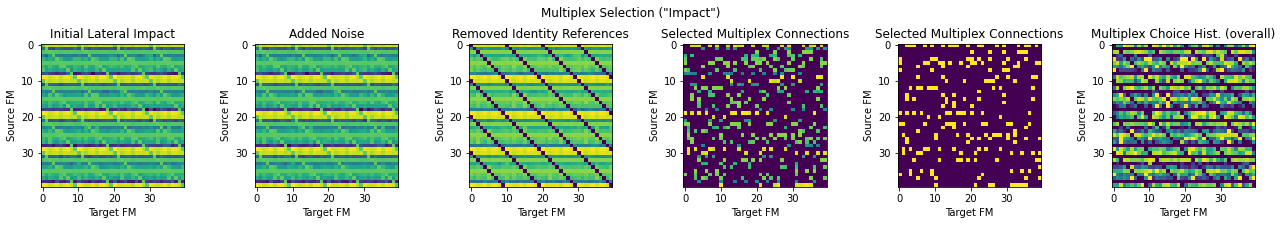

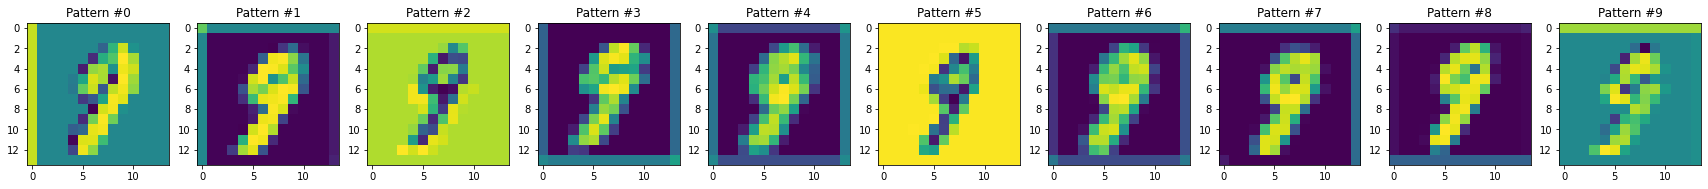

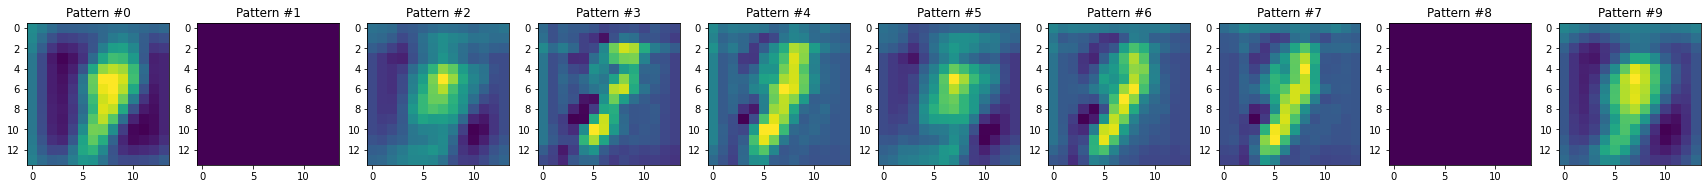

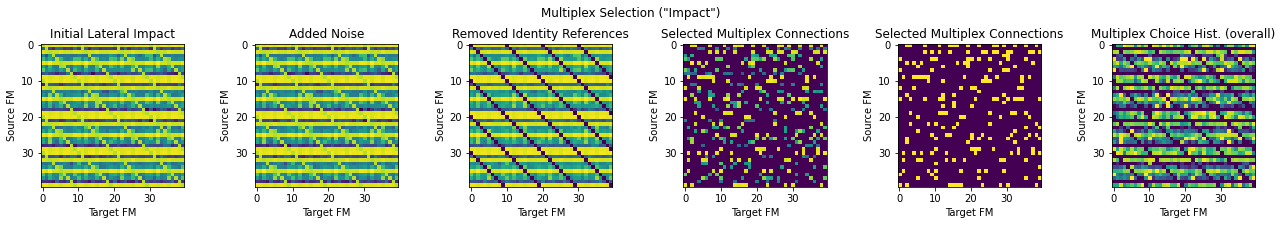

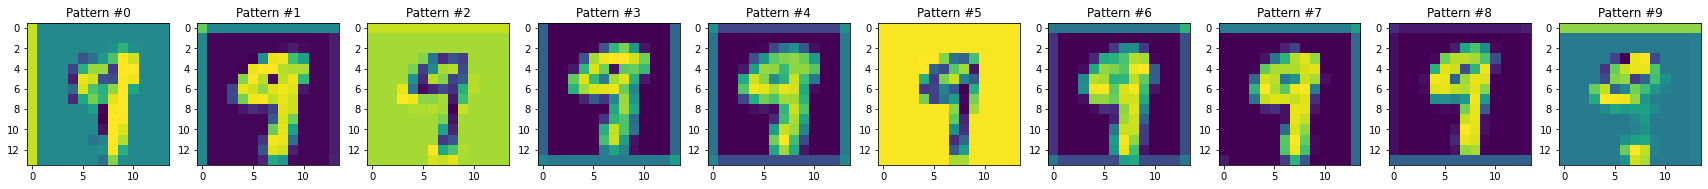

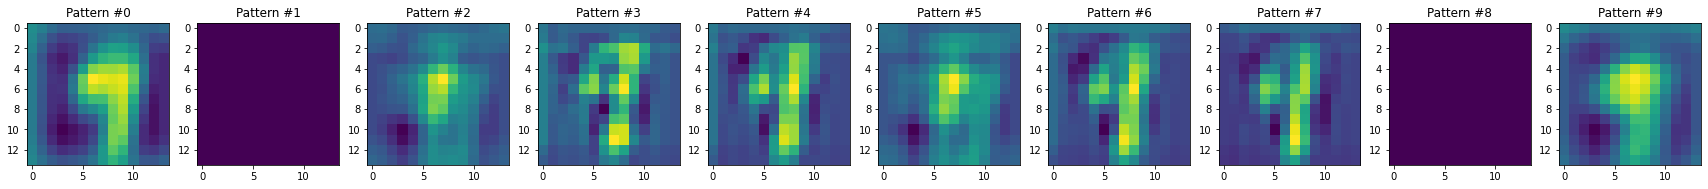

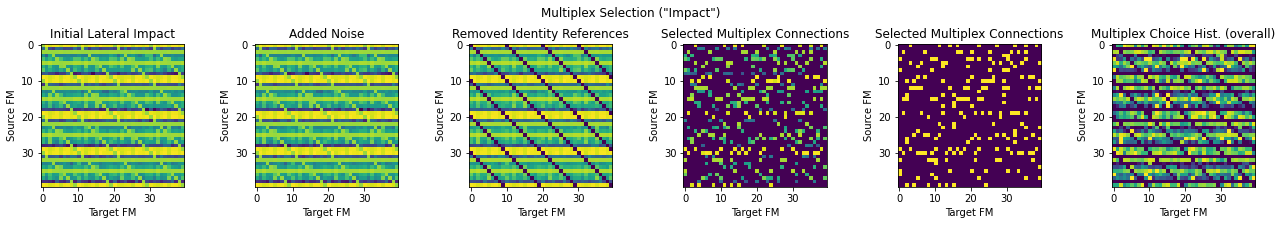

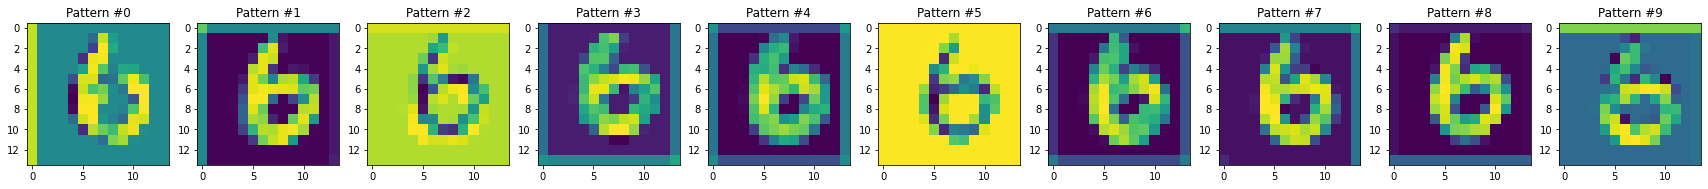

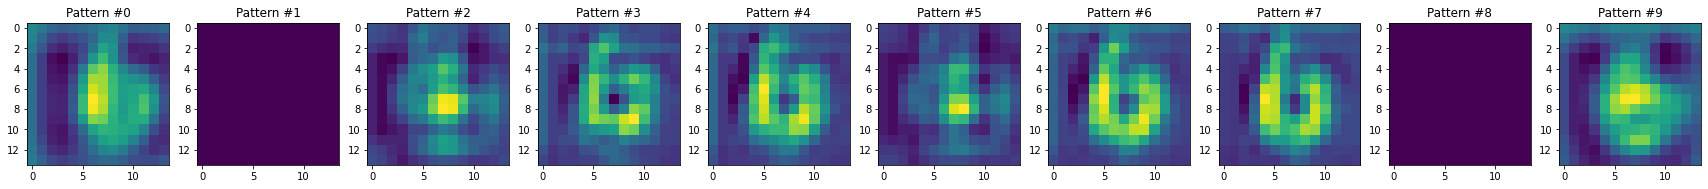

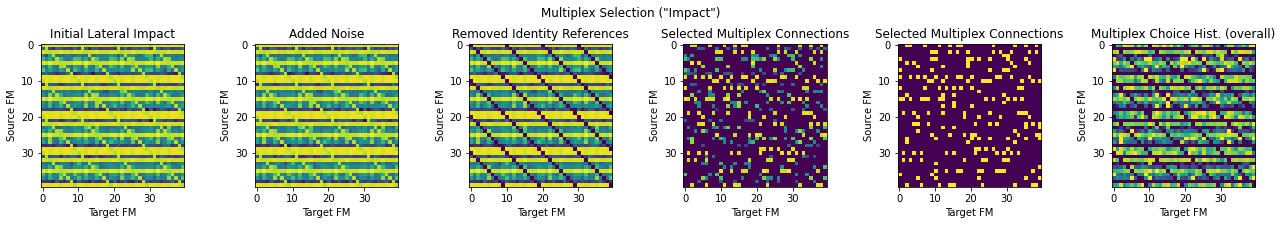

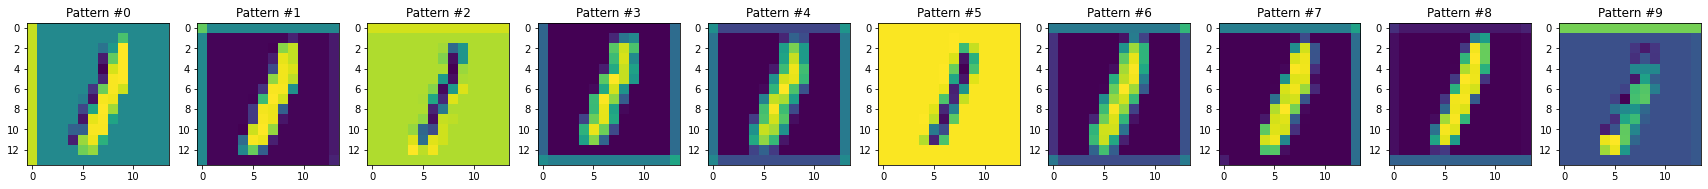

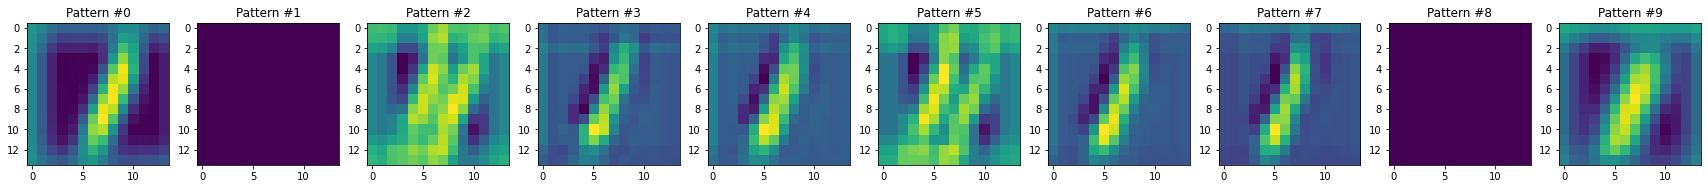

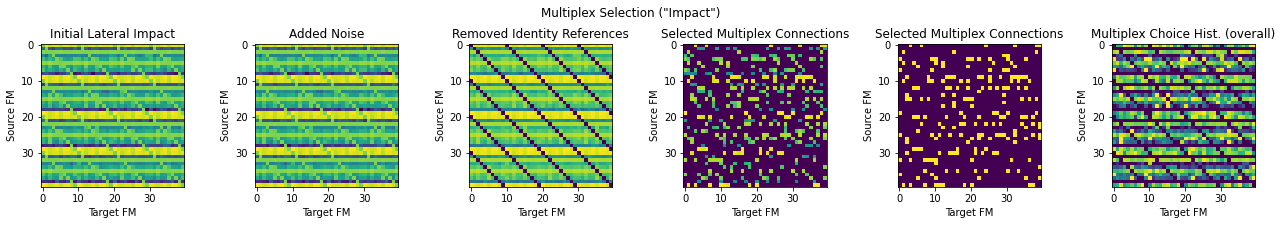

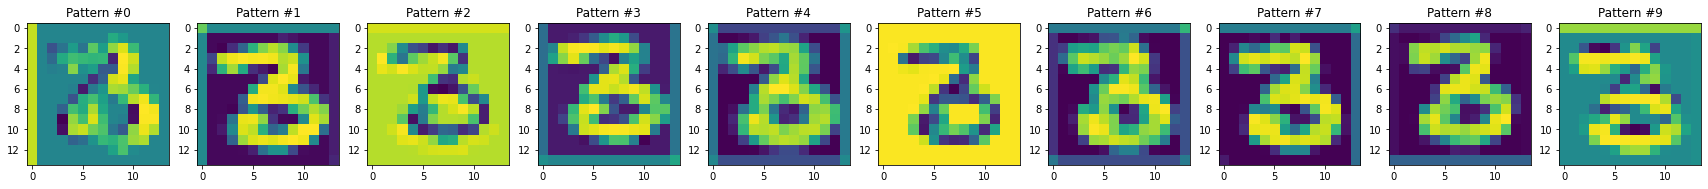

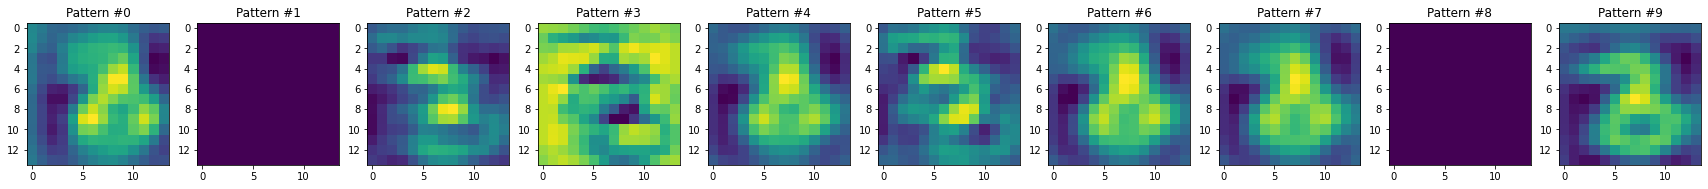

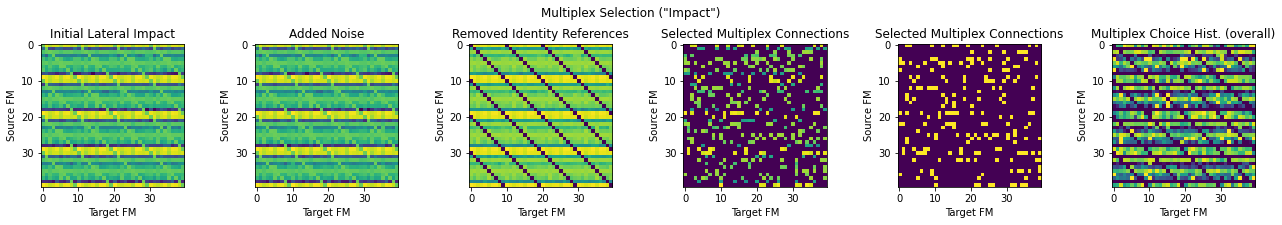

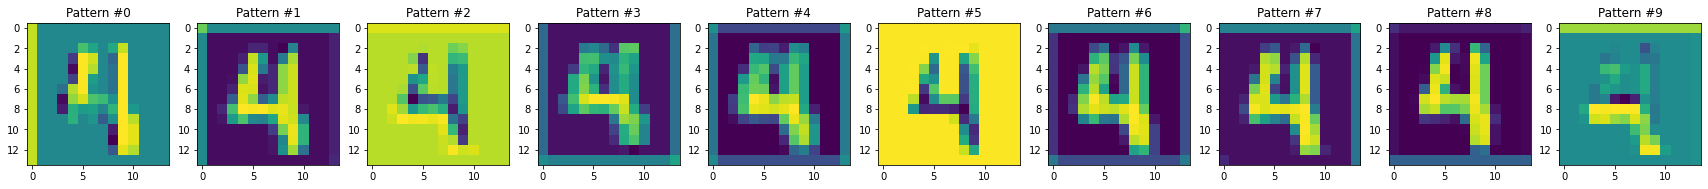

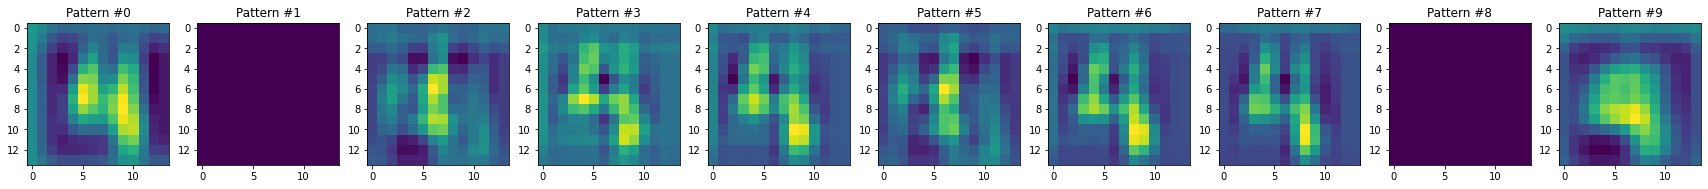

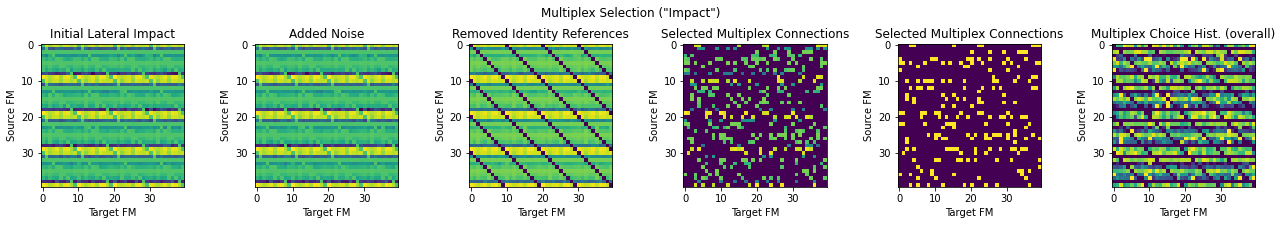

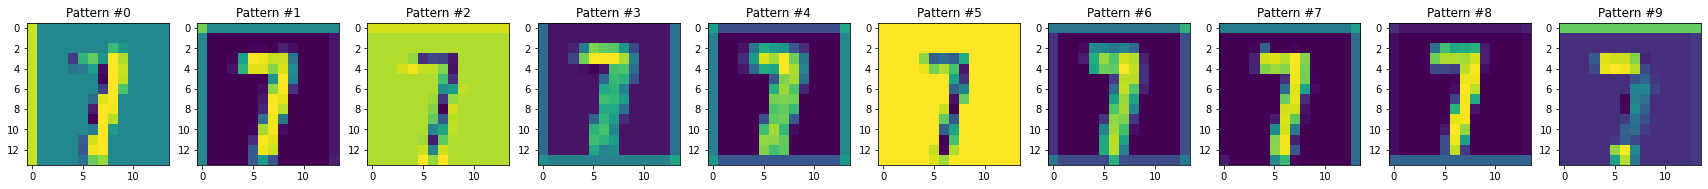

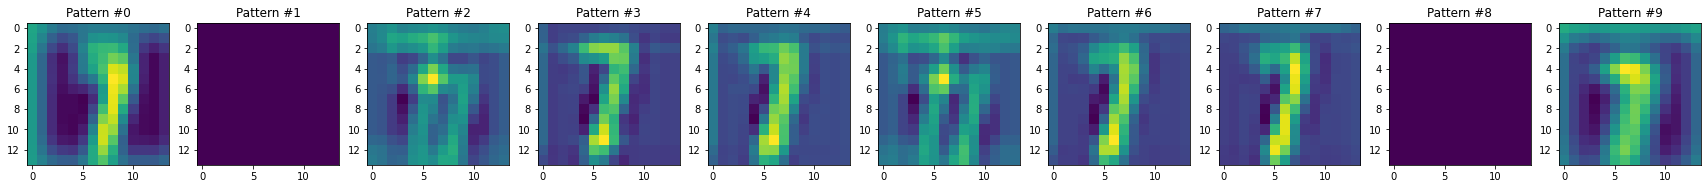

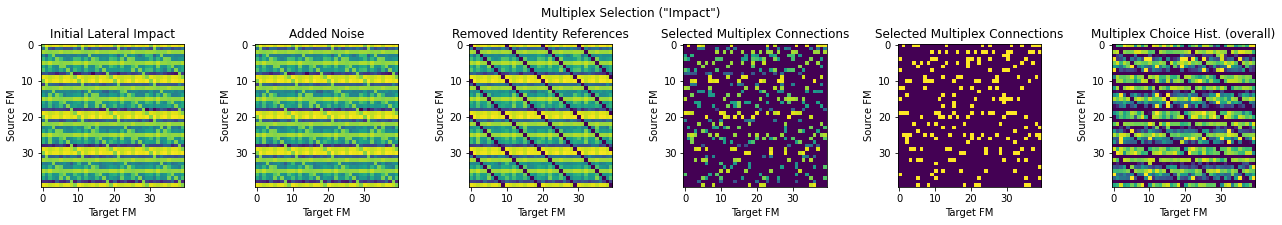

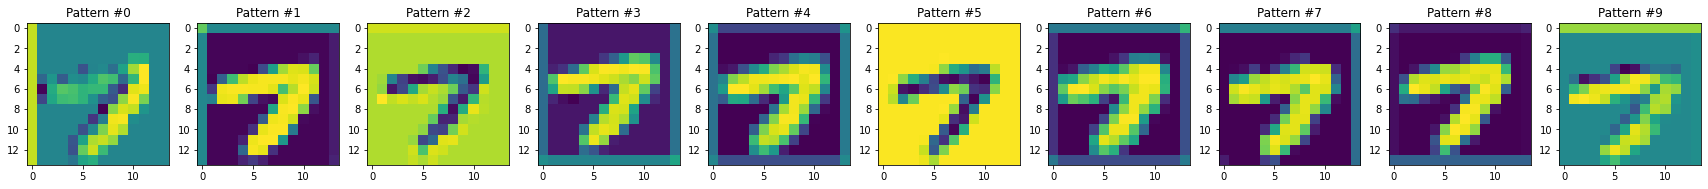

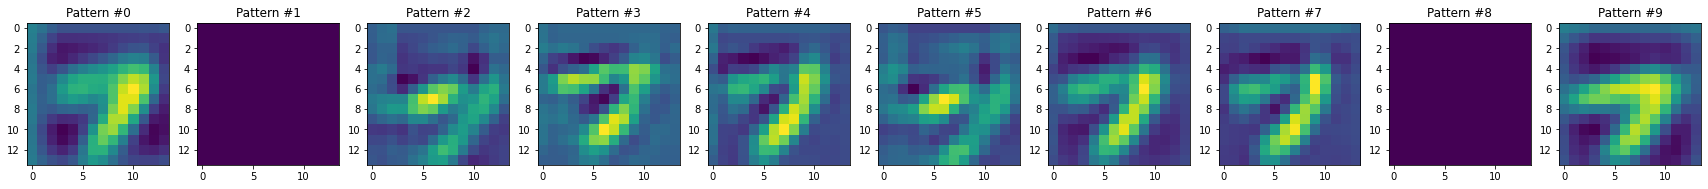

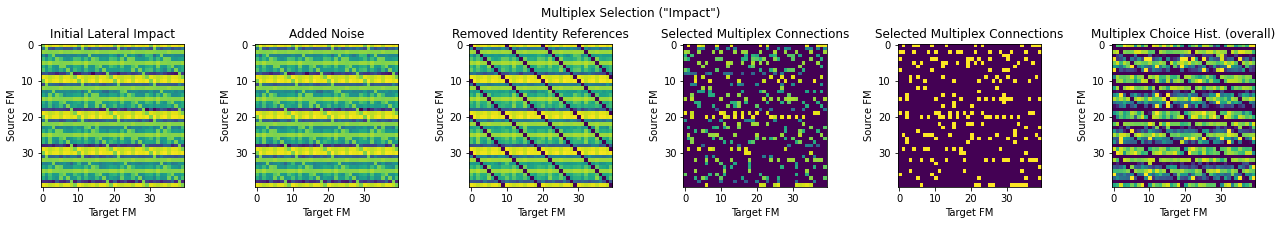

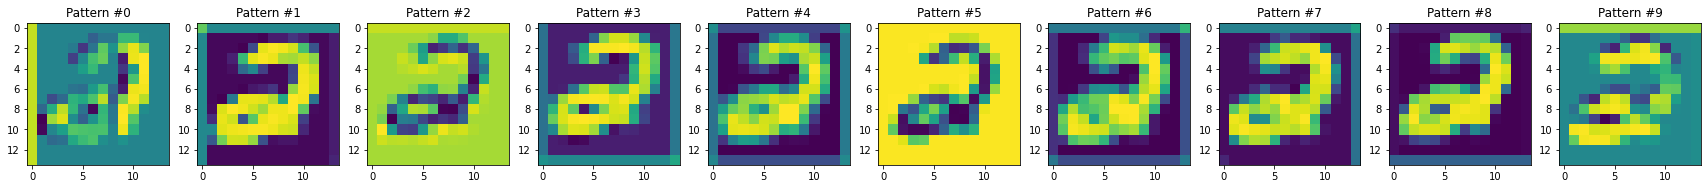

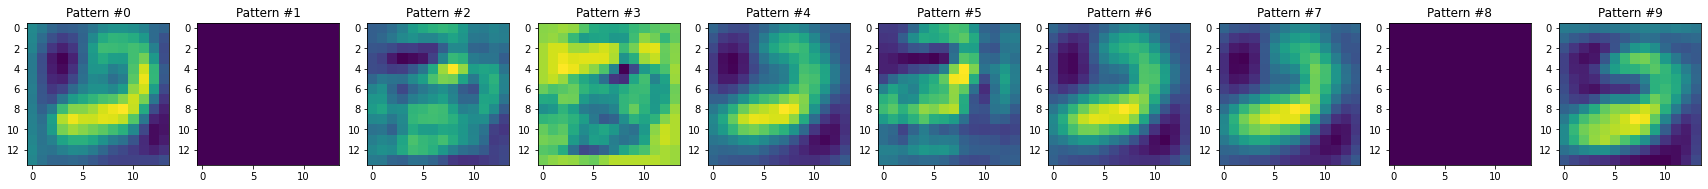

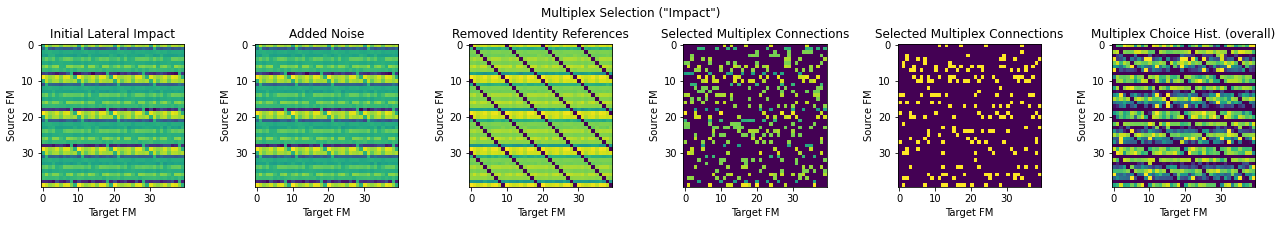

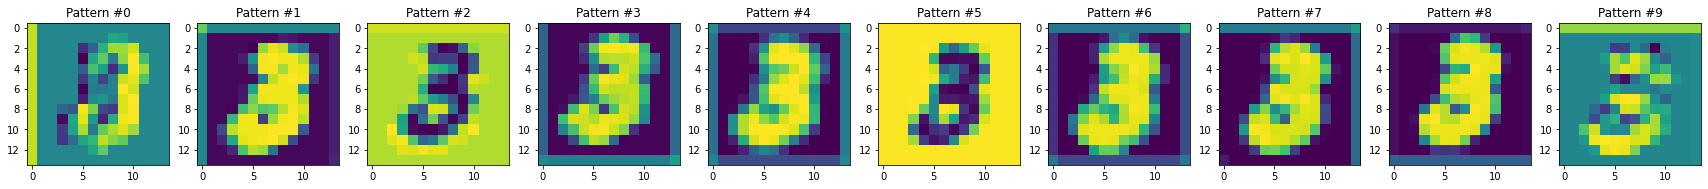

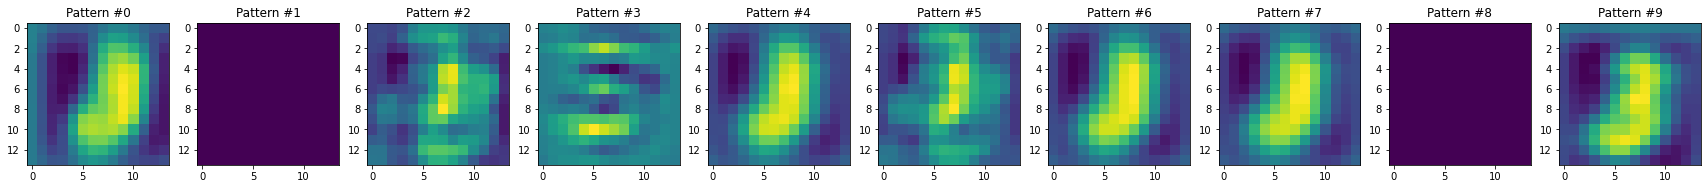

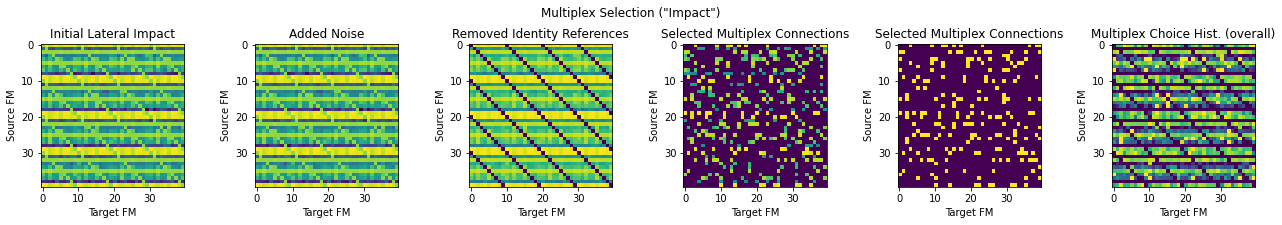

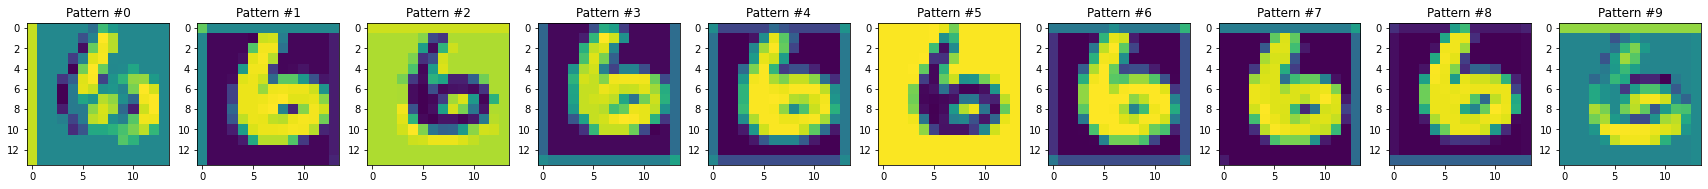

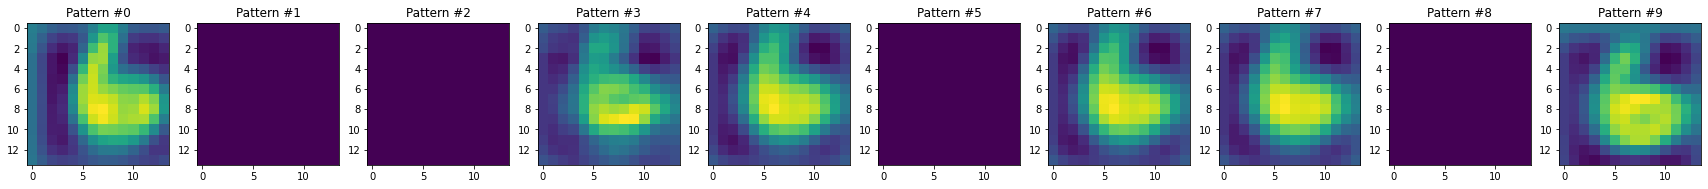

Testing:   0%|          | 0/1000 [00:00<?, ?it/s]

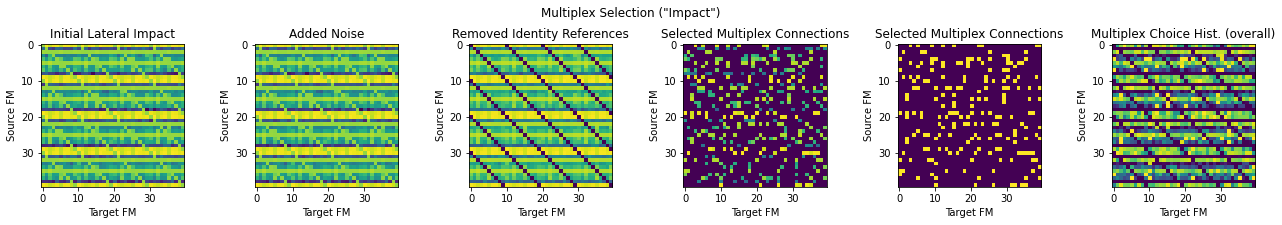

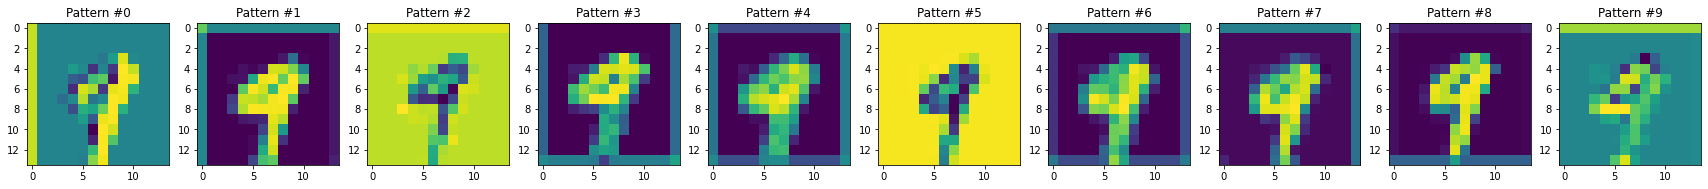

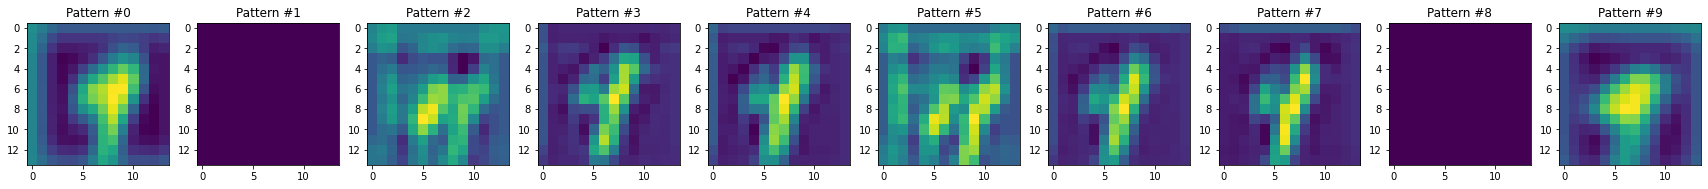

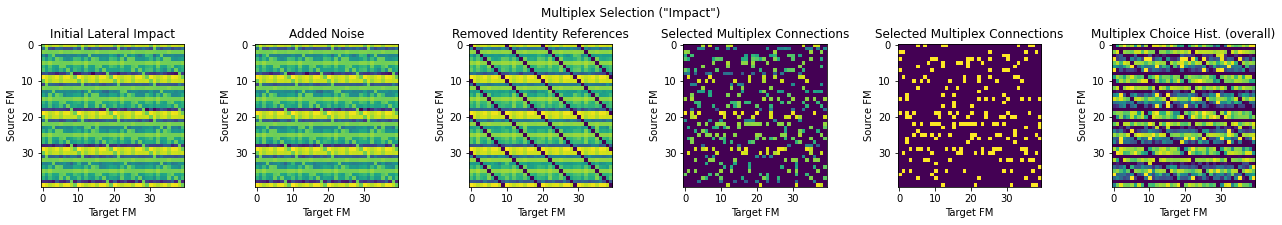

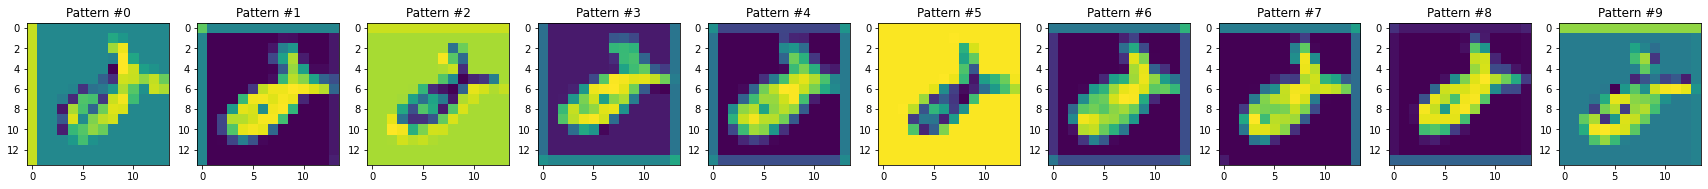

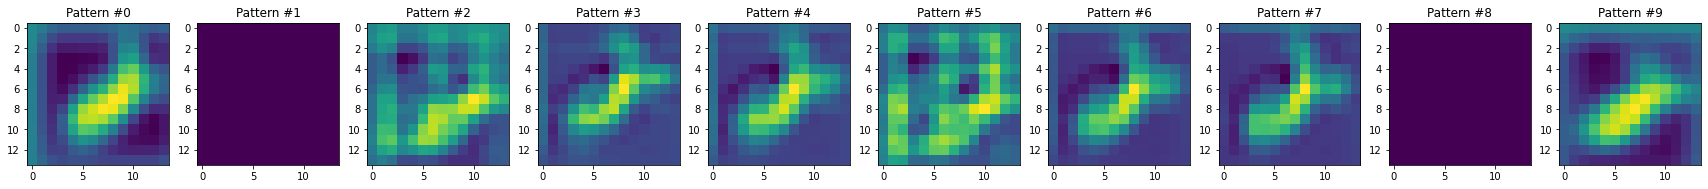

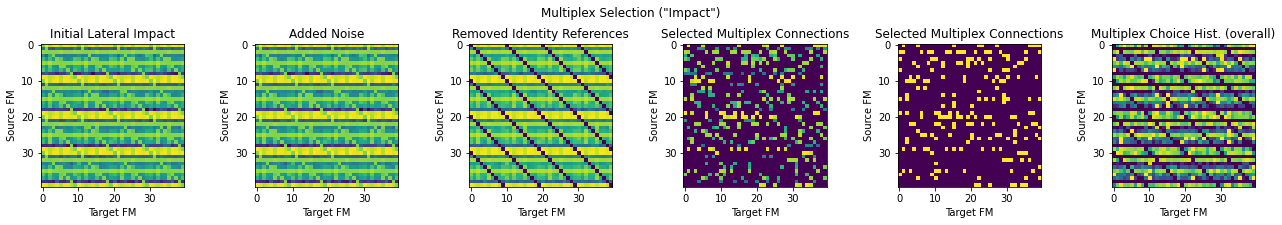

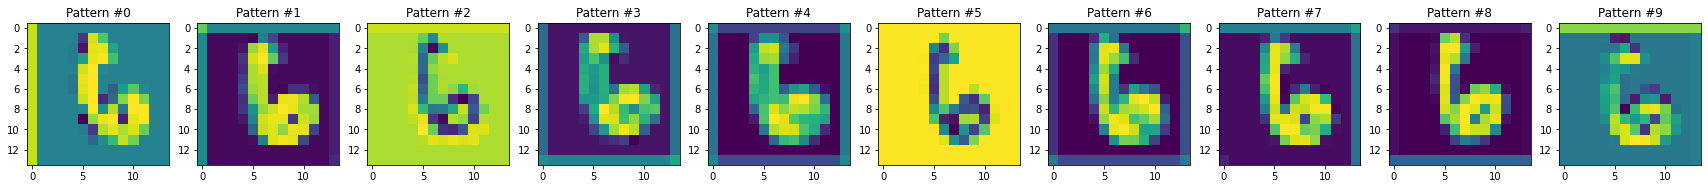

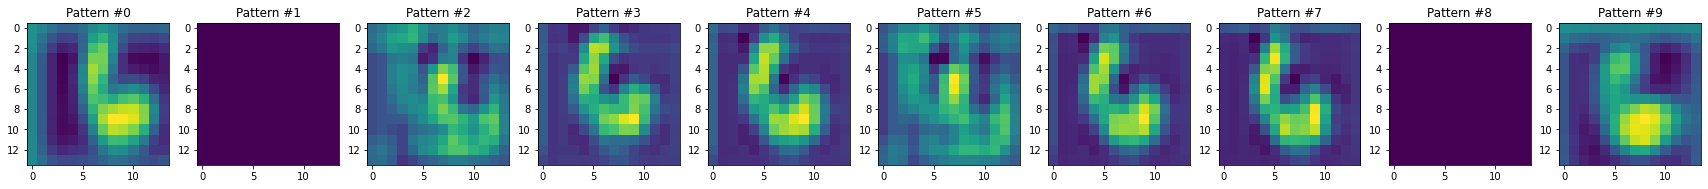

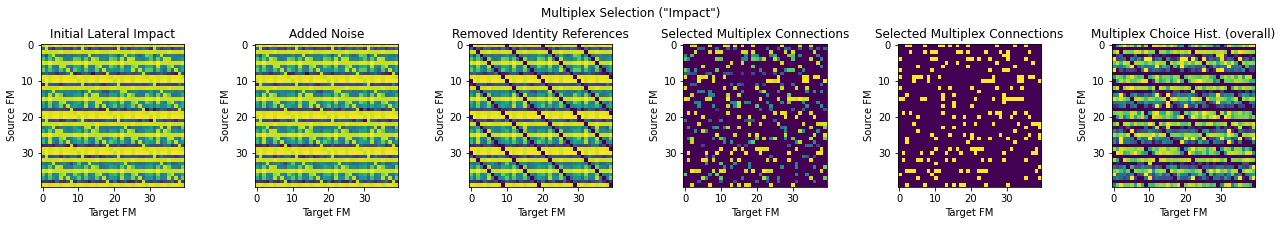

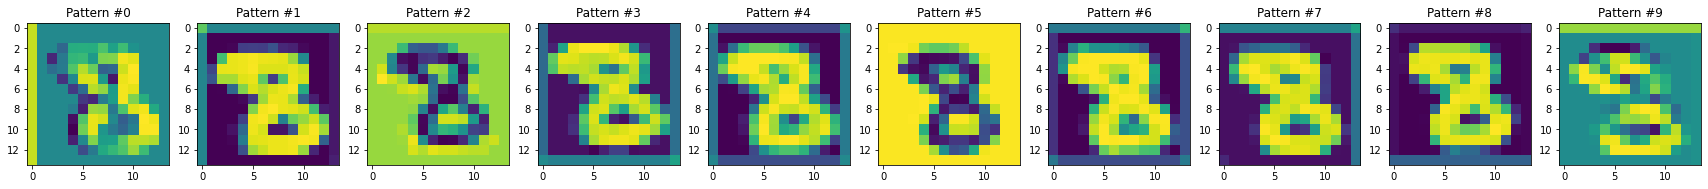

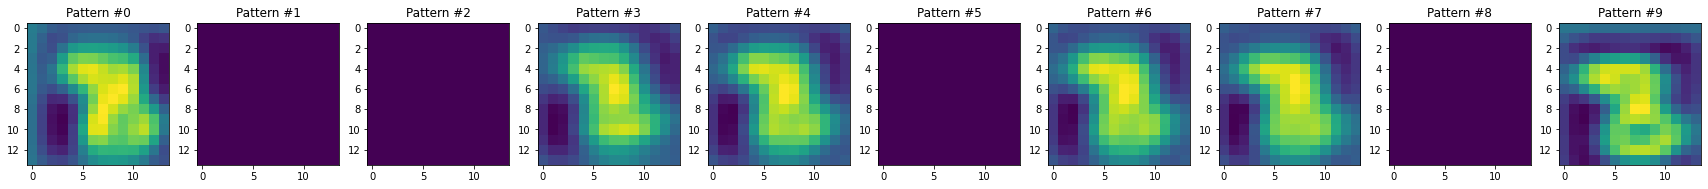

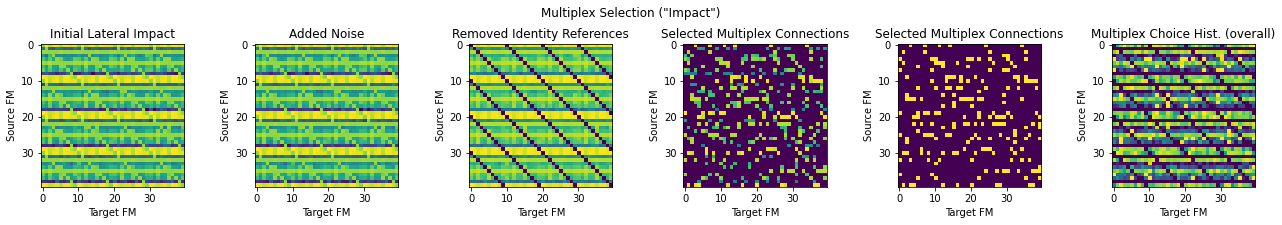

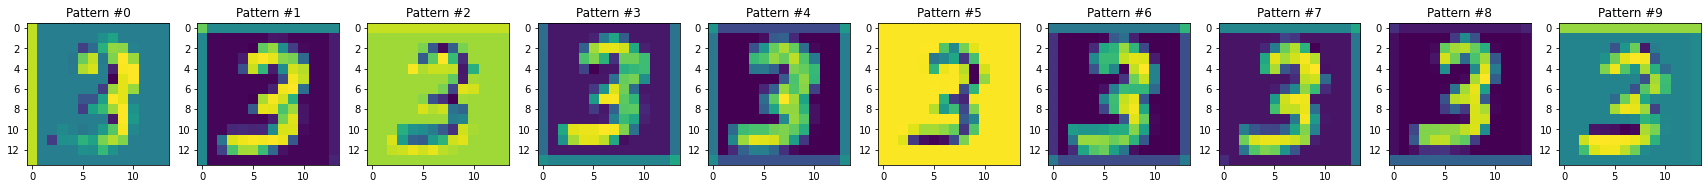

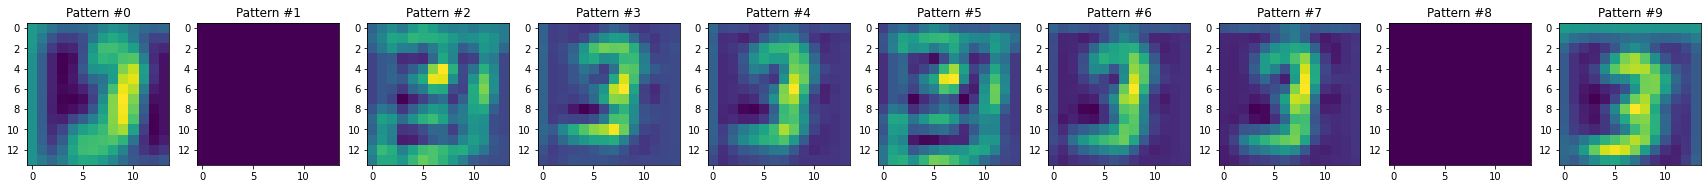

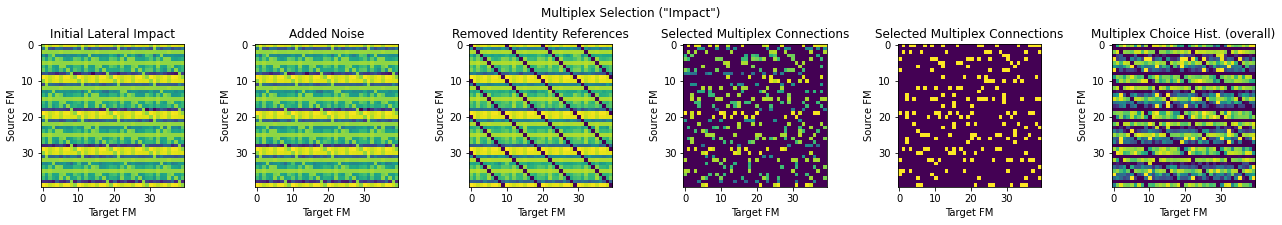

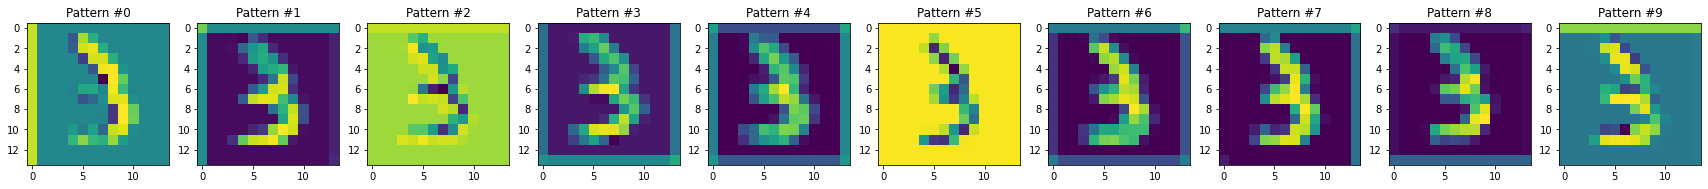

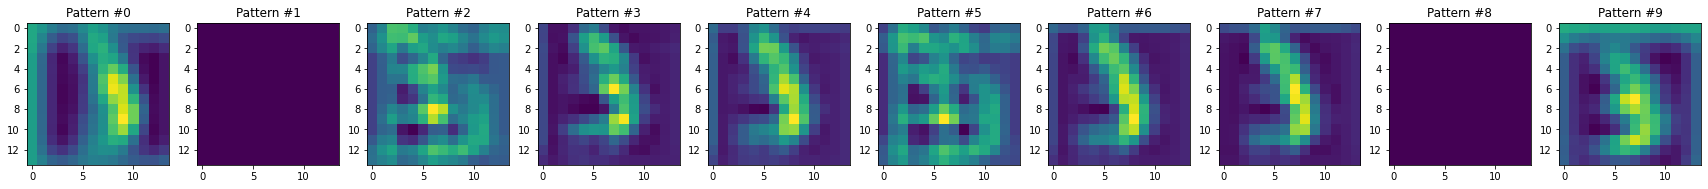

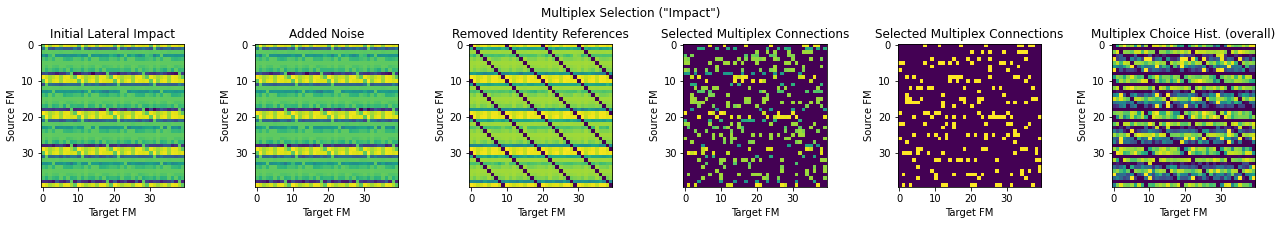

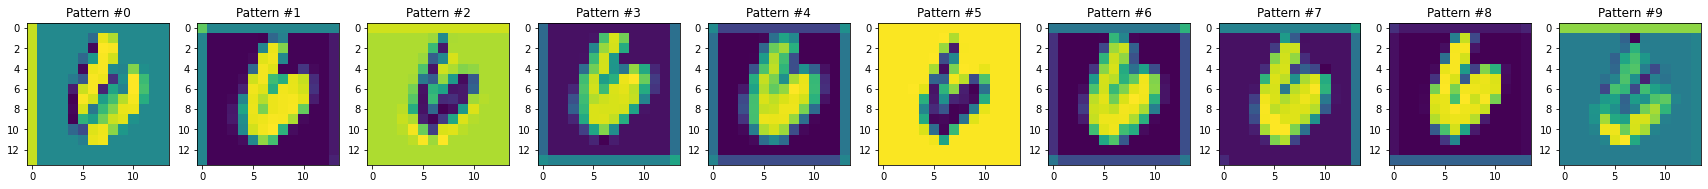

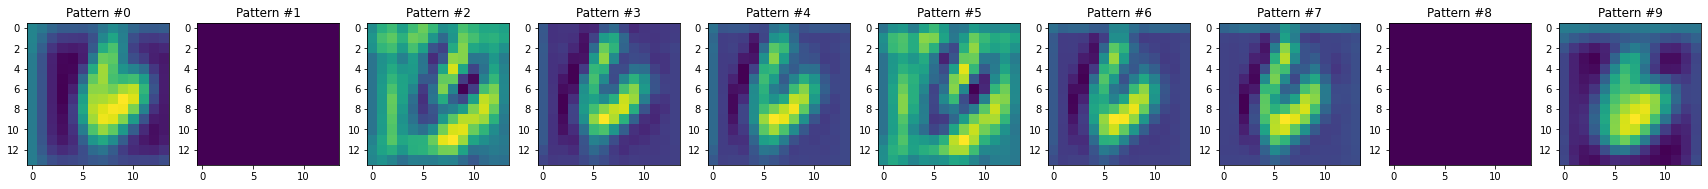

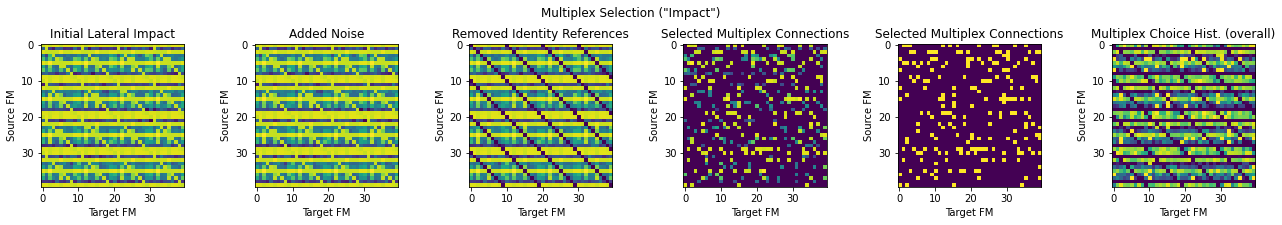

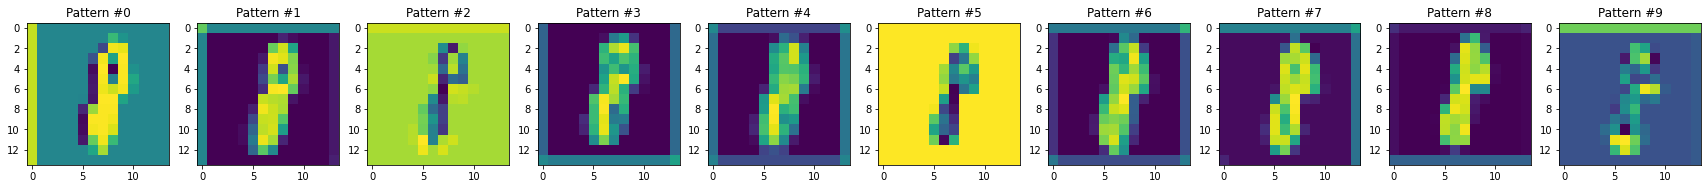

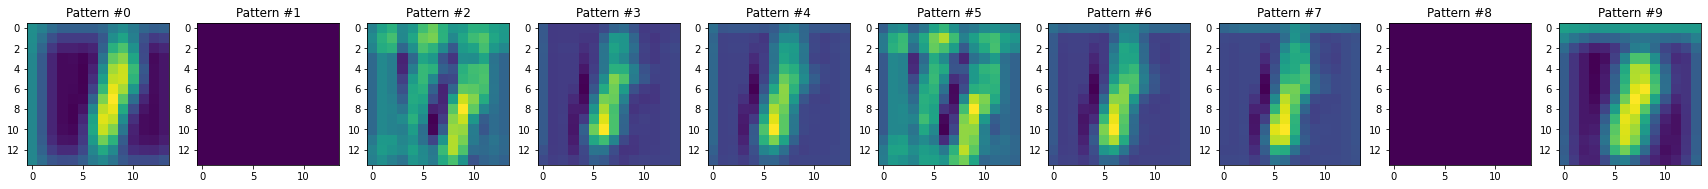

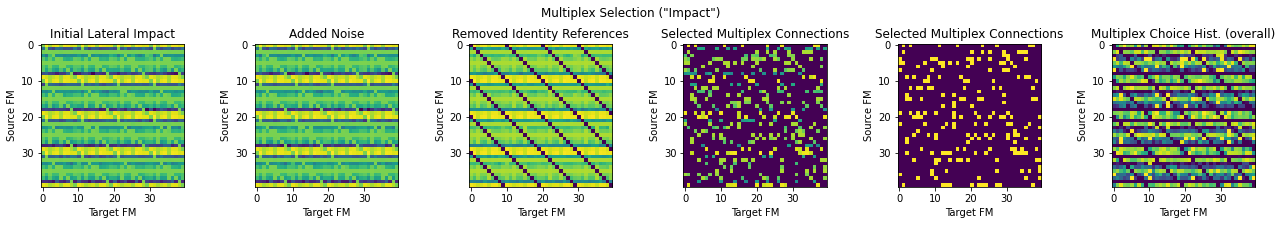

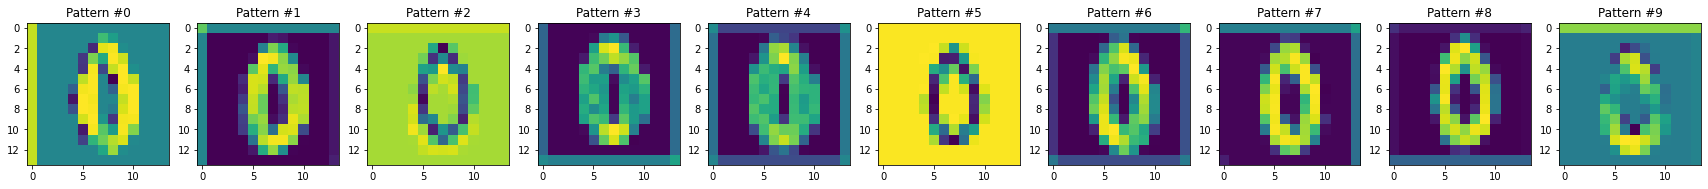

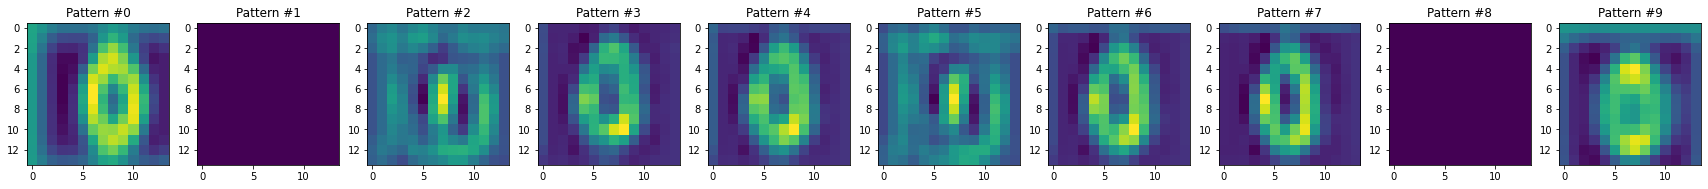

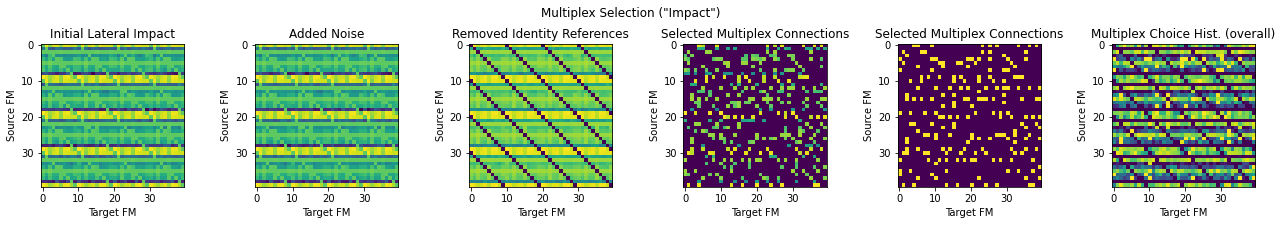

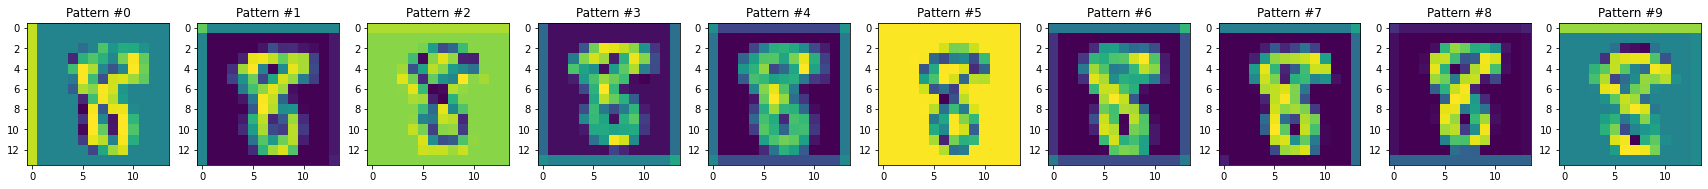

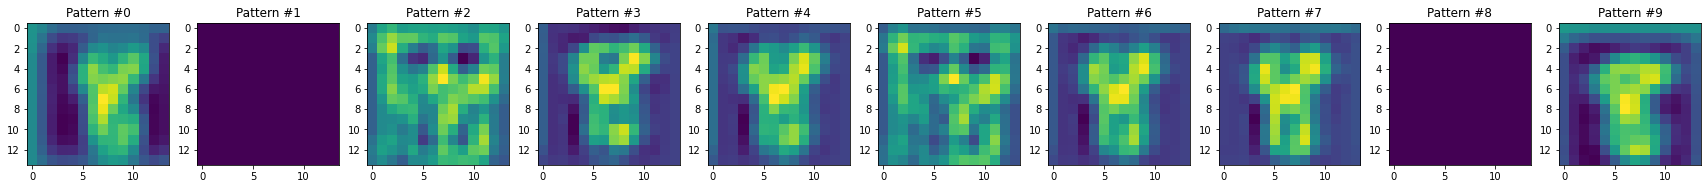

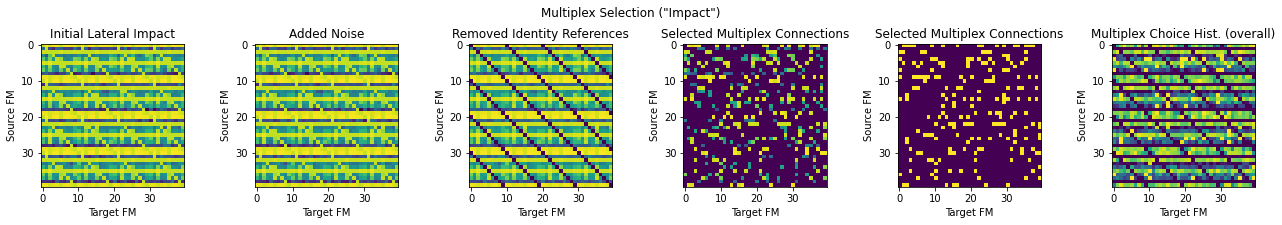

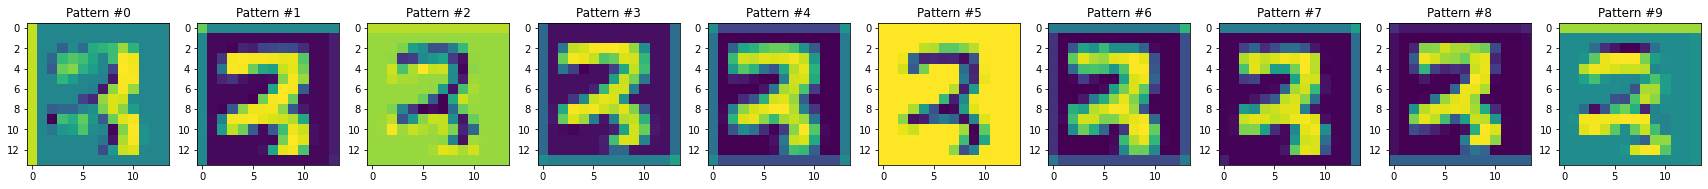

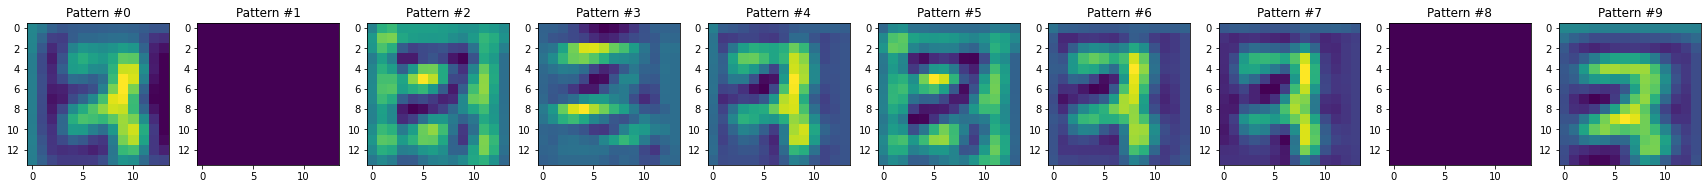

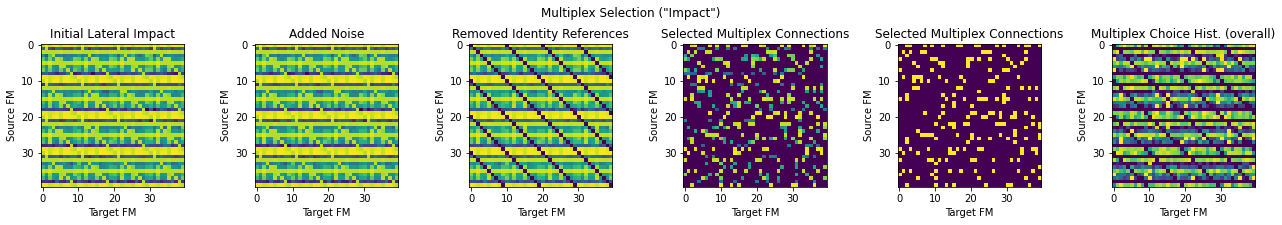

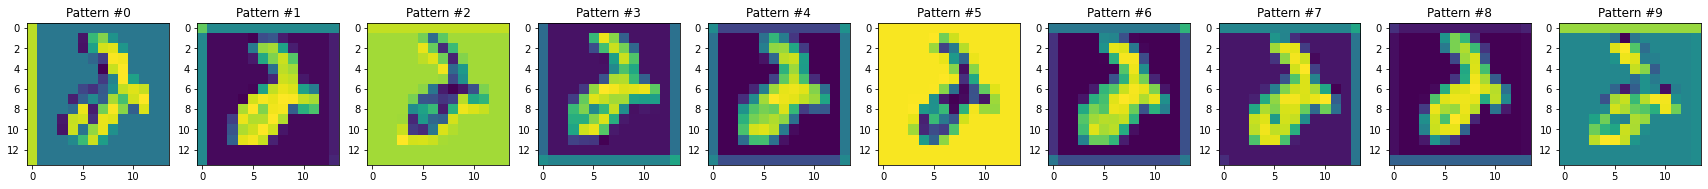

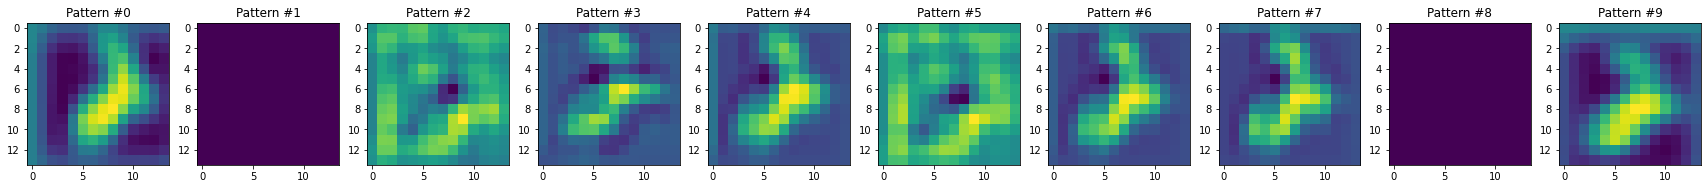

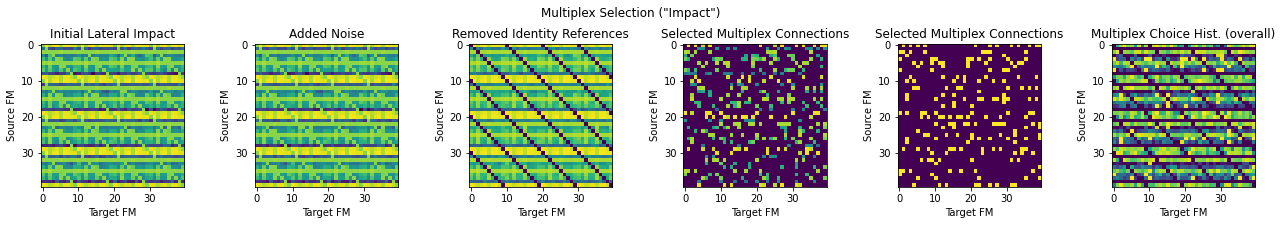

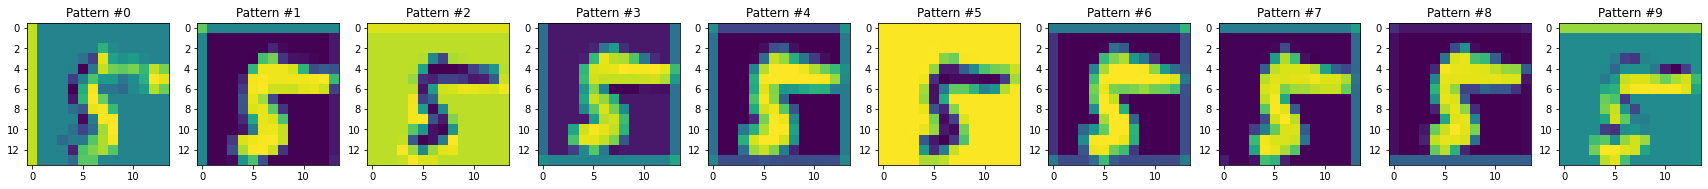

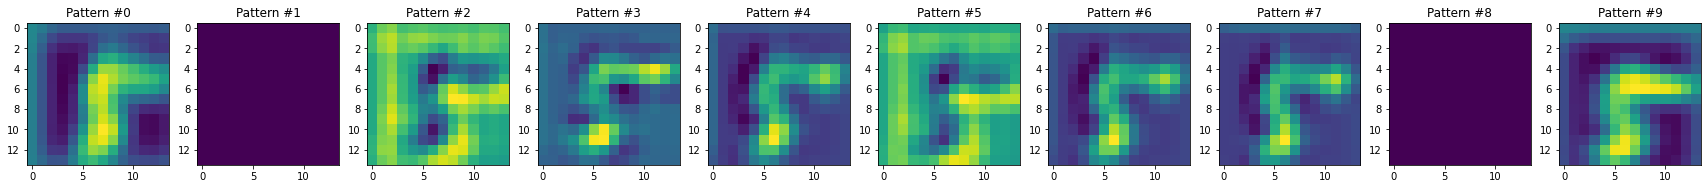

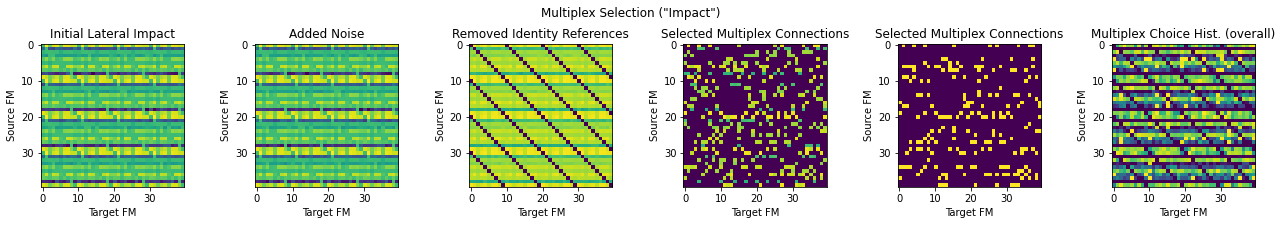

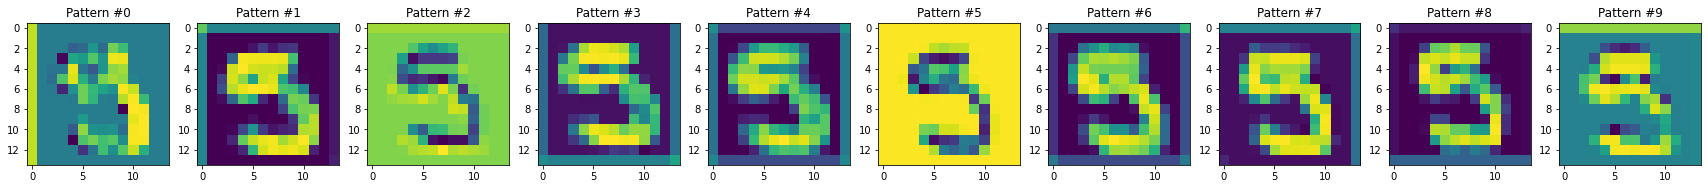

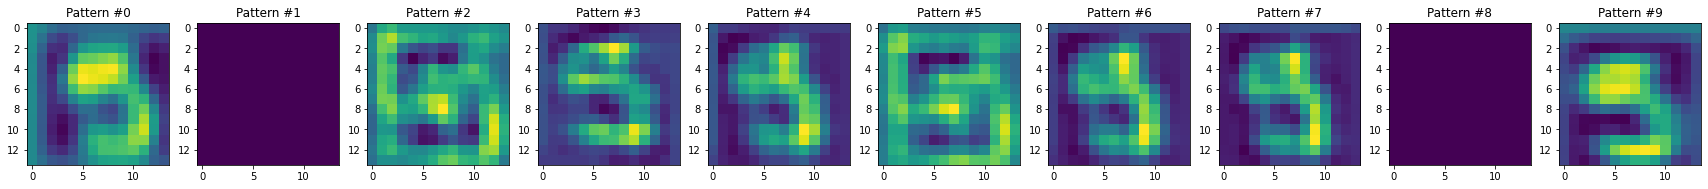

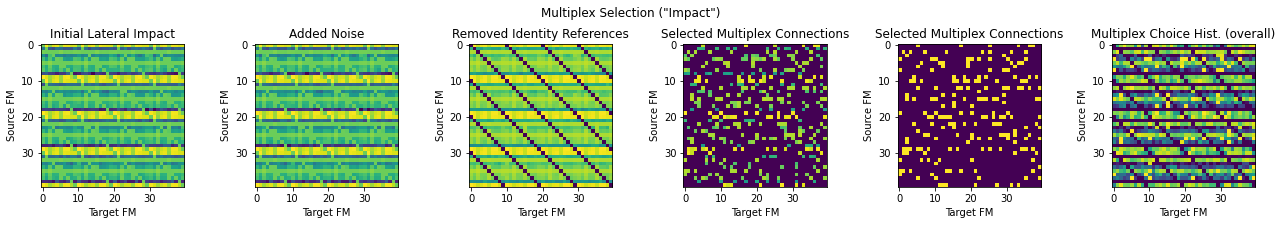

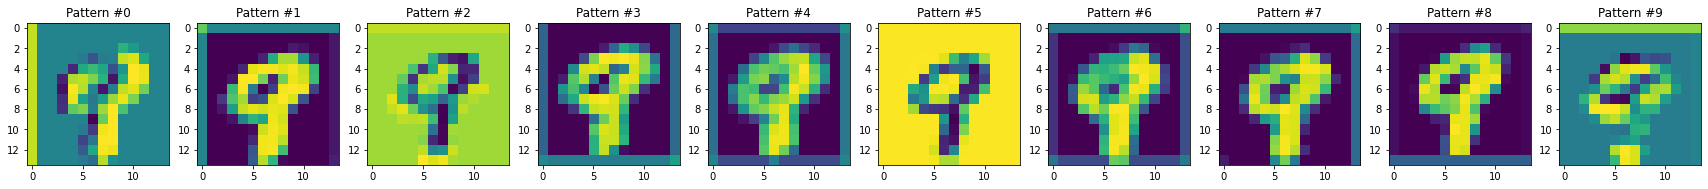

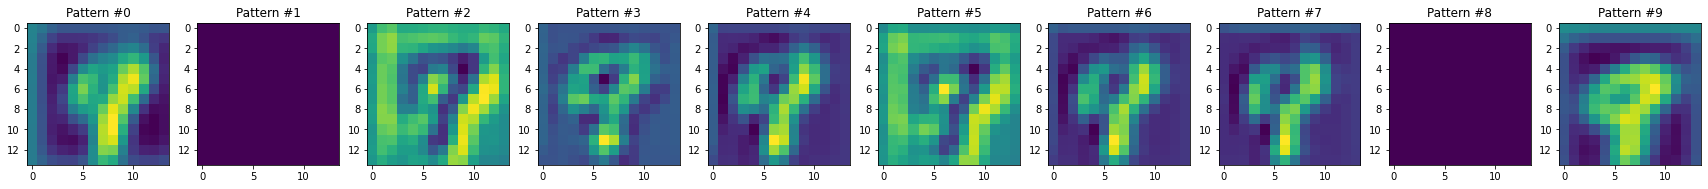

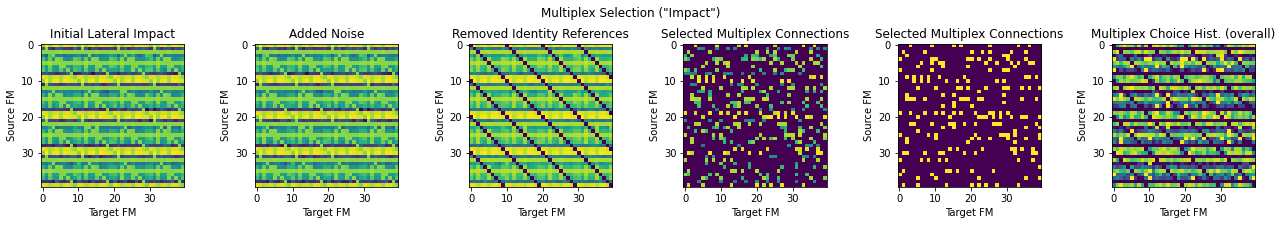

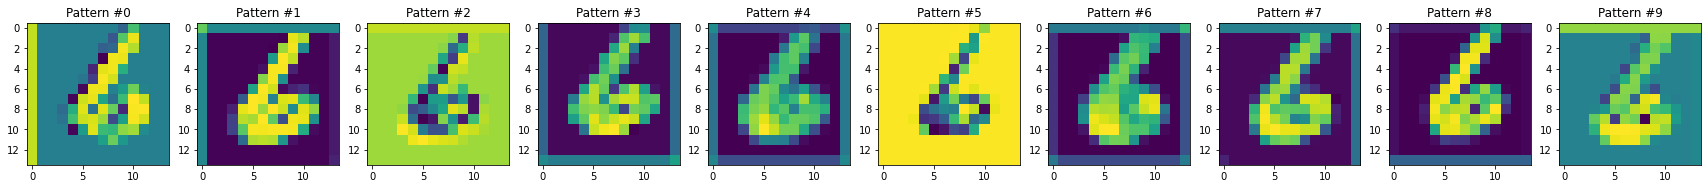

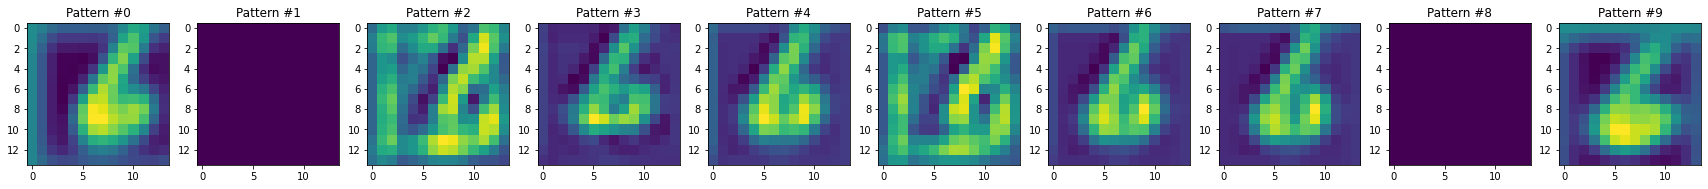

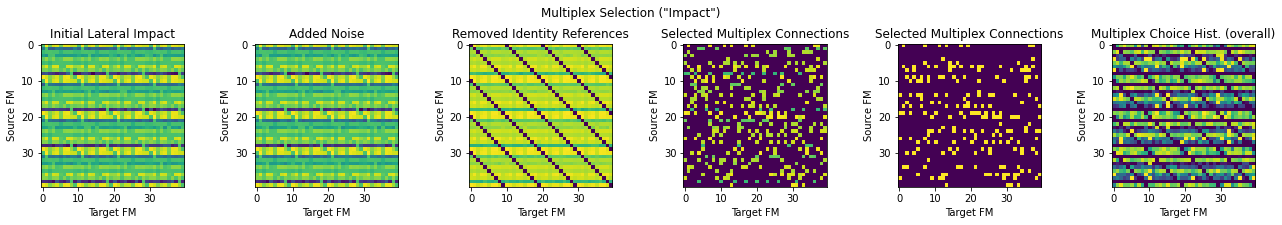

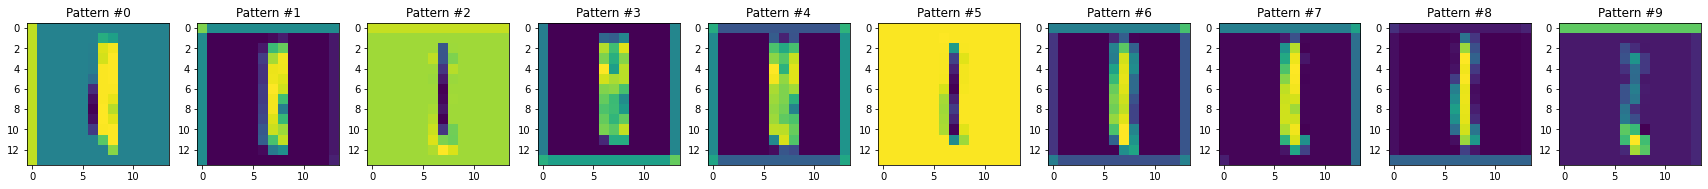

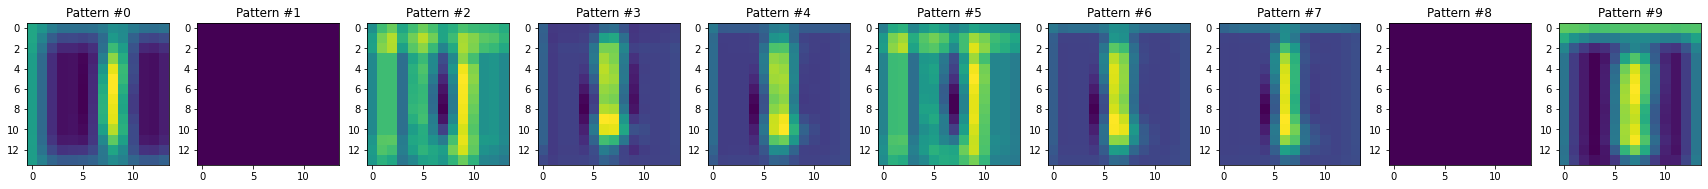

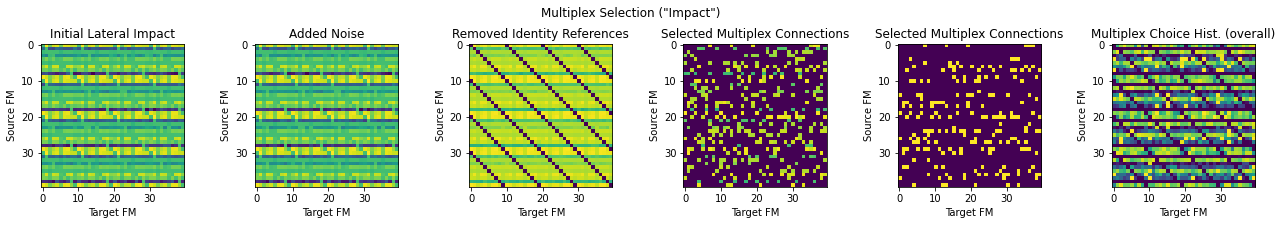

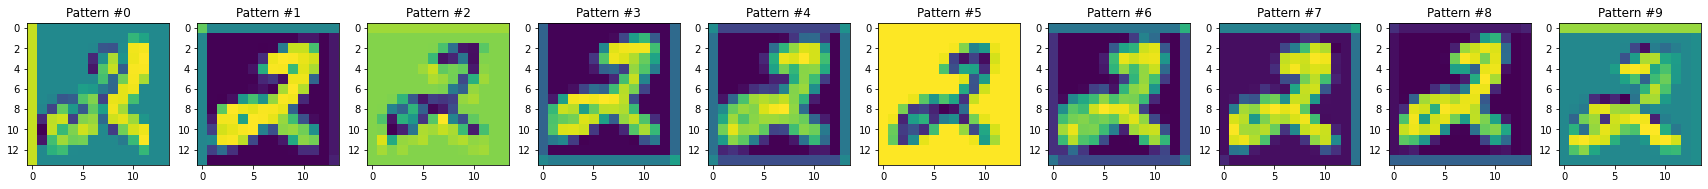

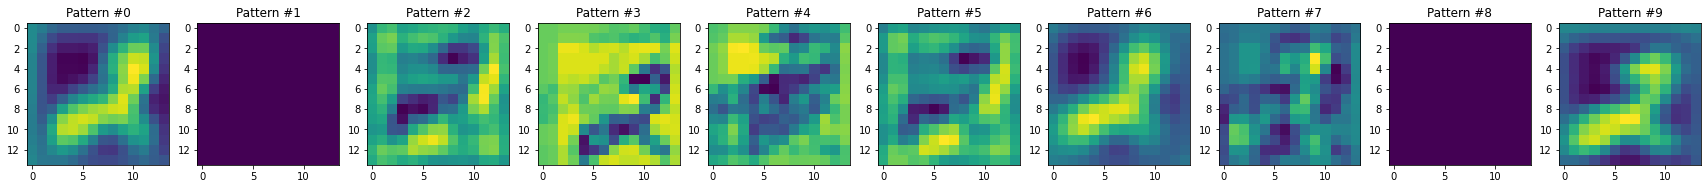

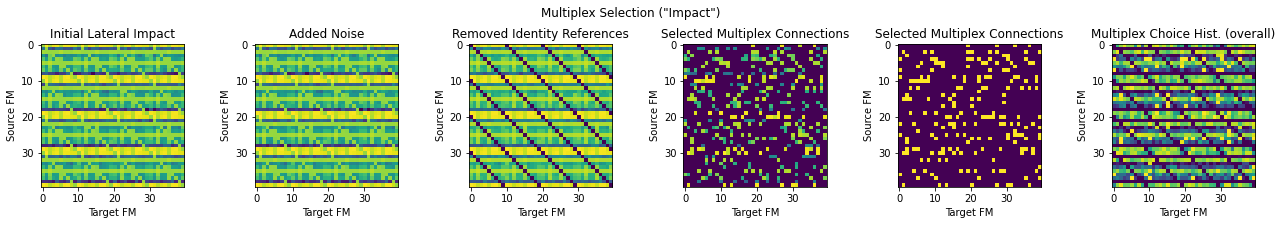

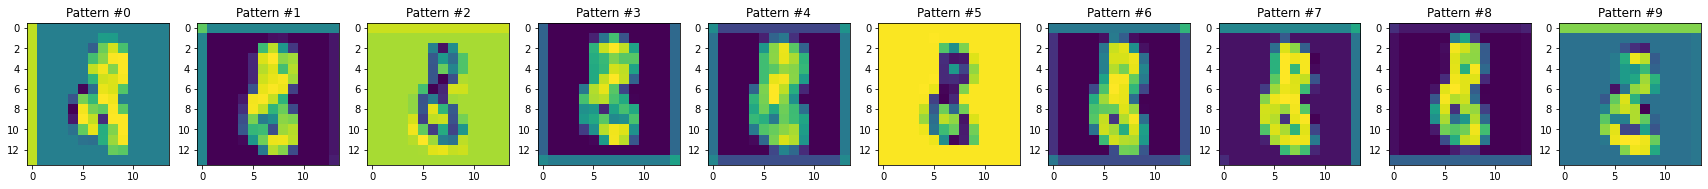

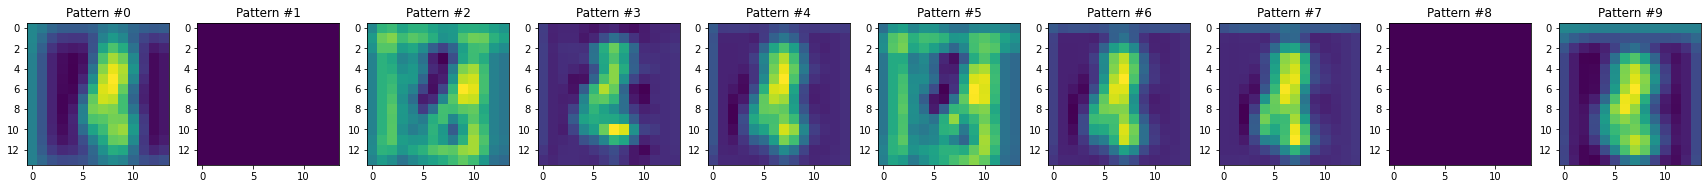

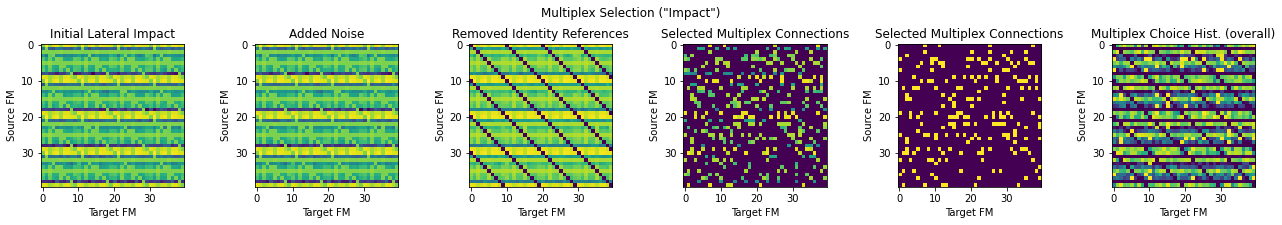

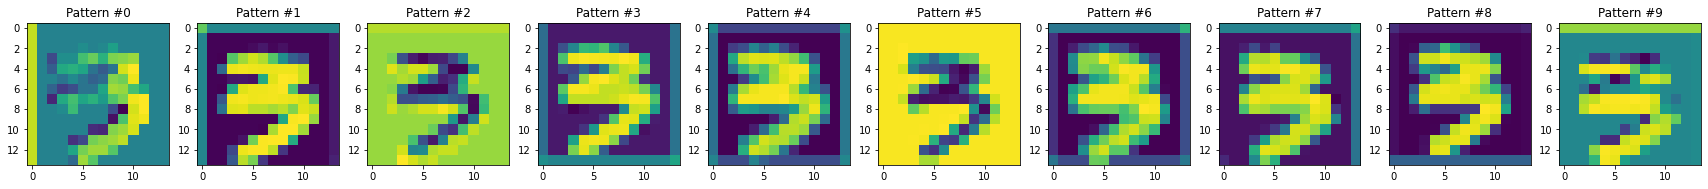

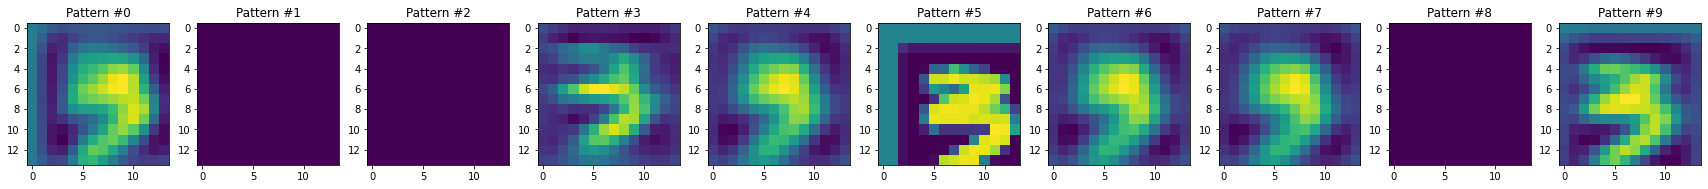

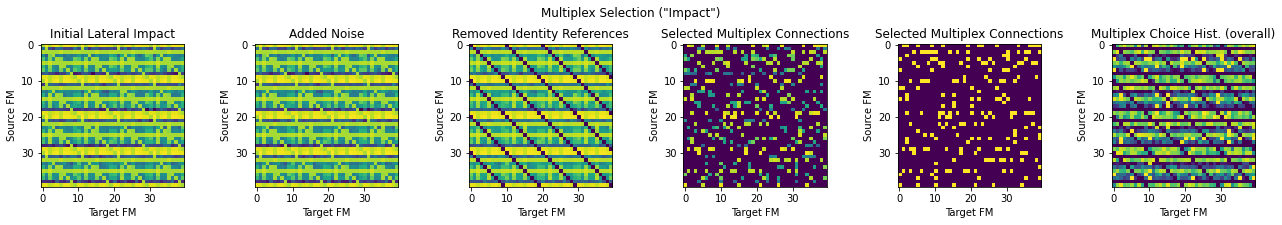

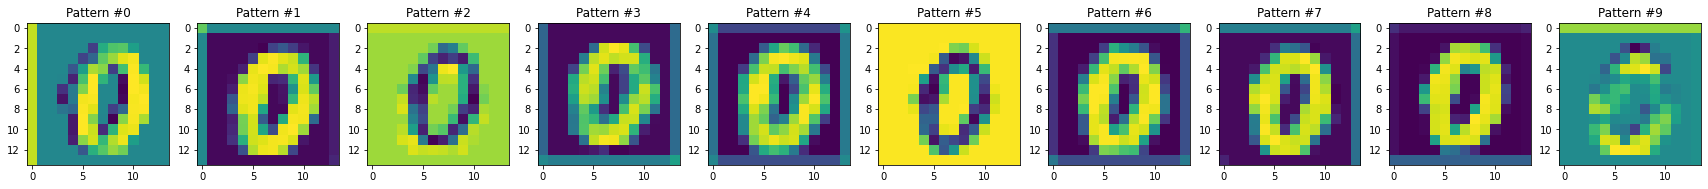

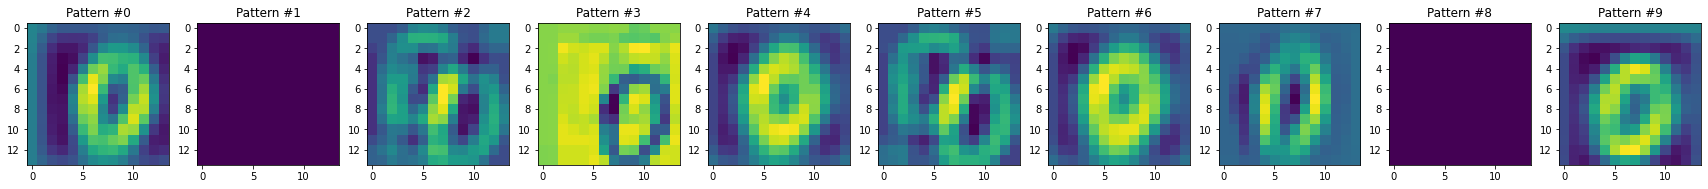

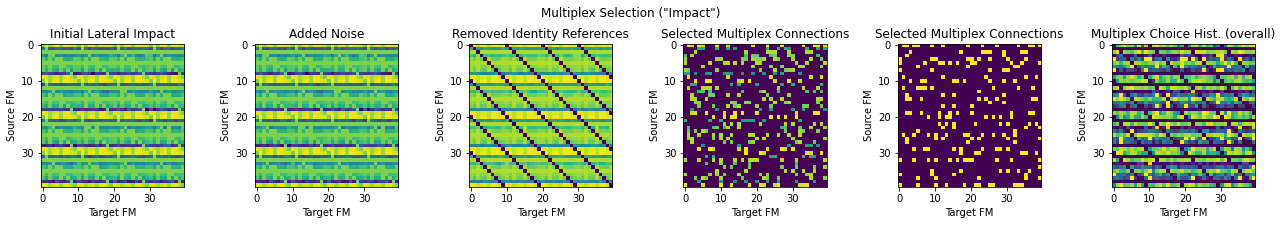

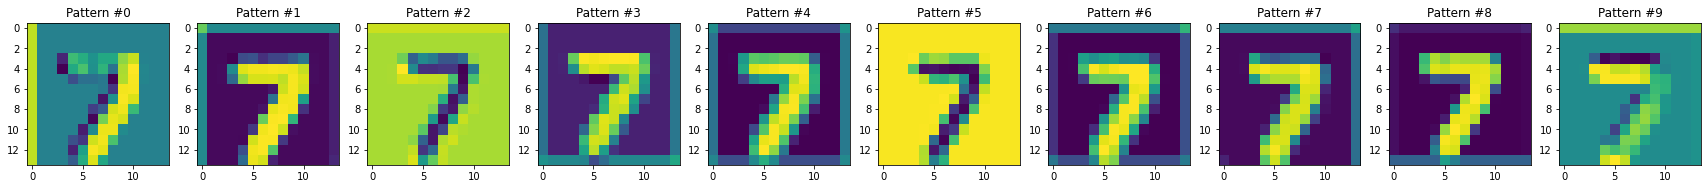

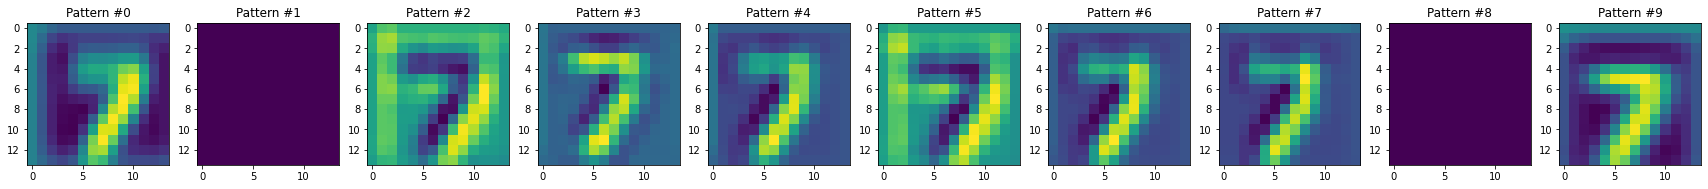

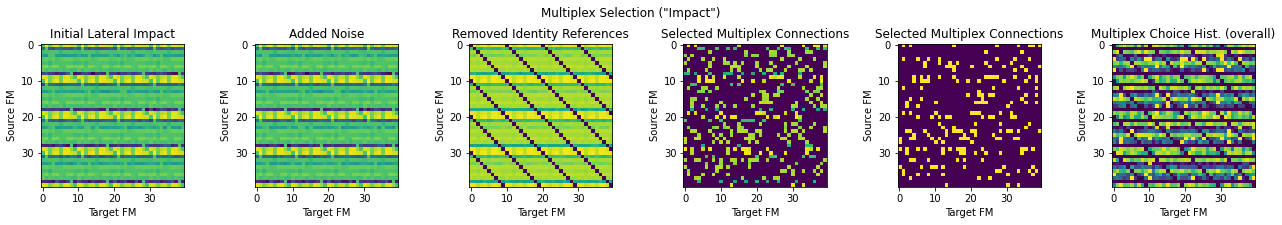

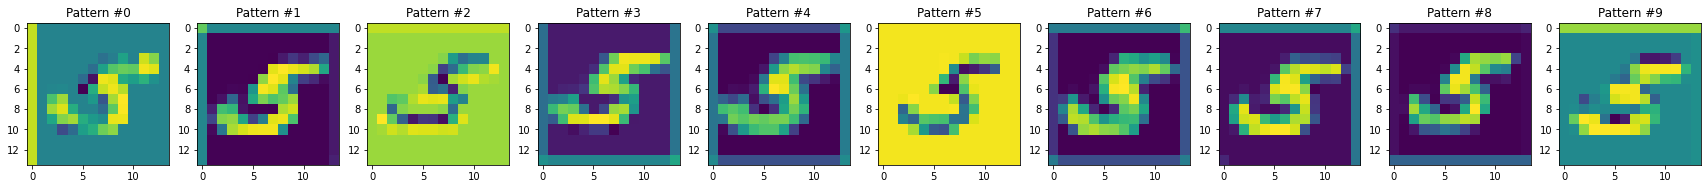

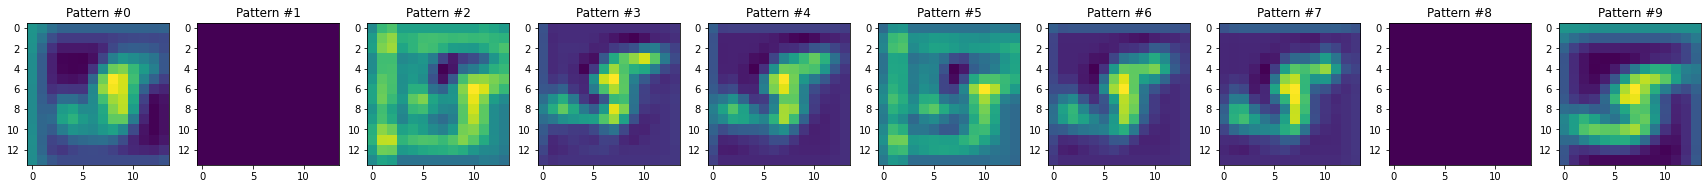

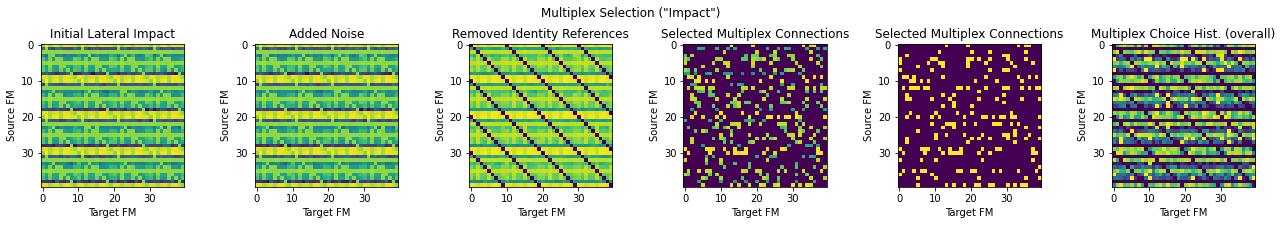

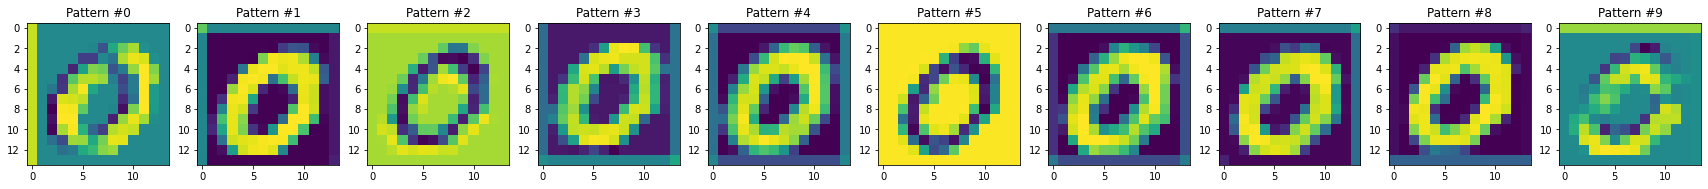

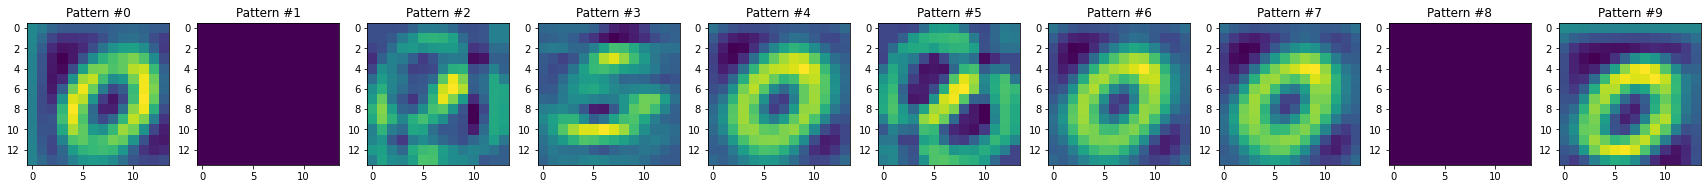

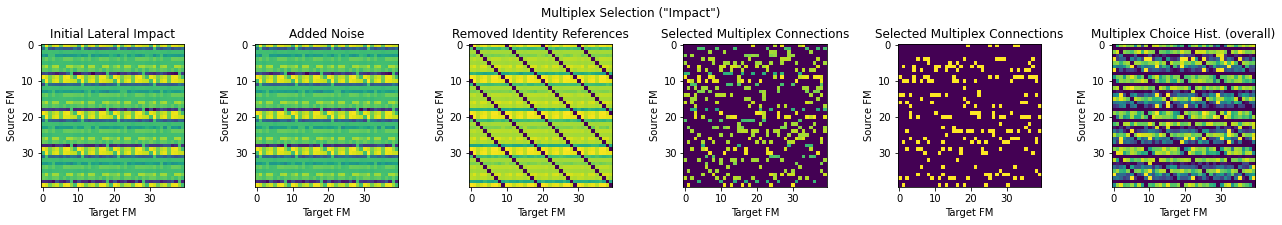

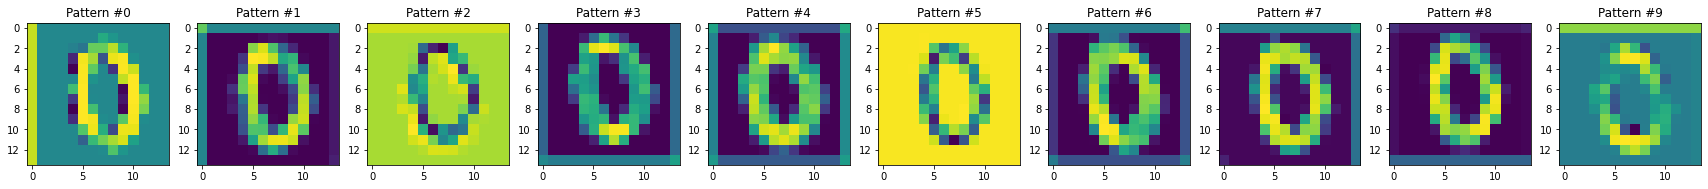

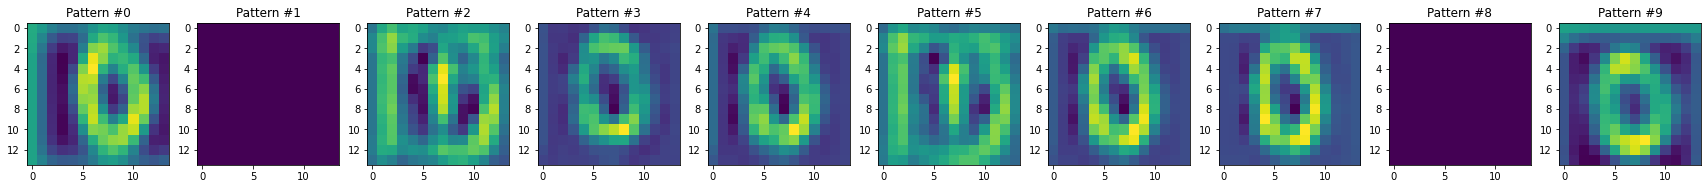

Testing:   0%|          | 0/1000 [00:00<?, ?it/s]

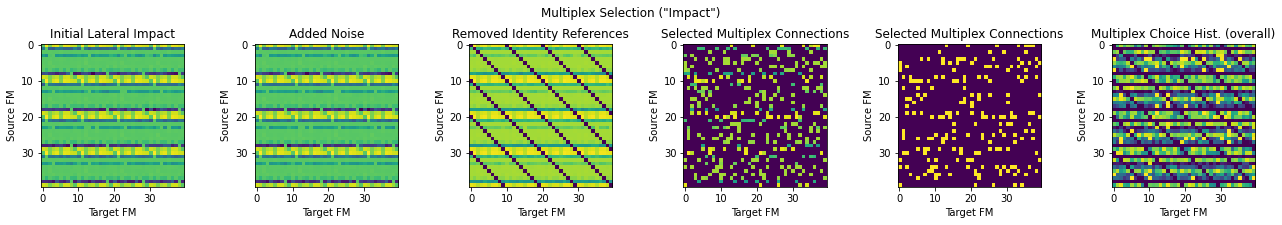

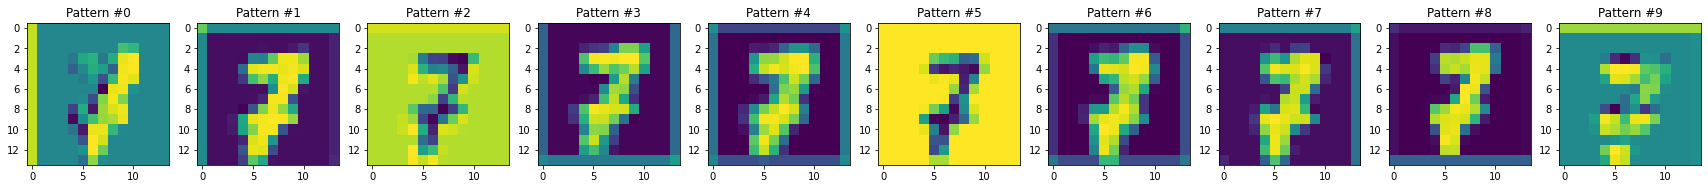

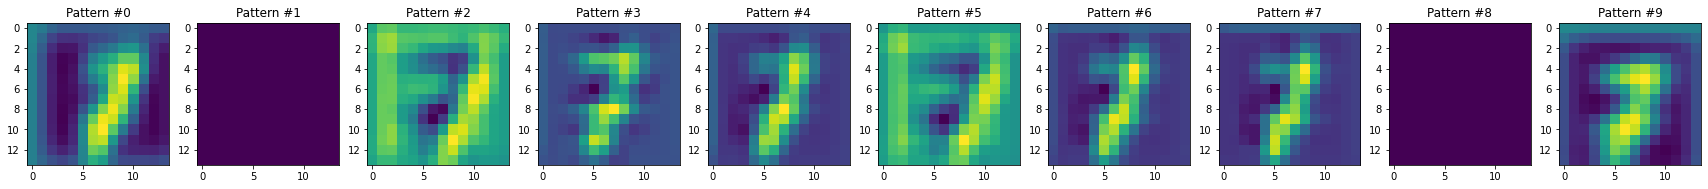

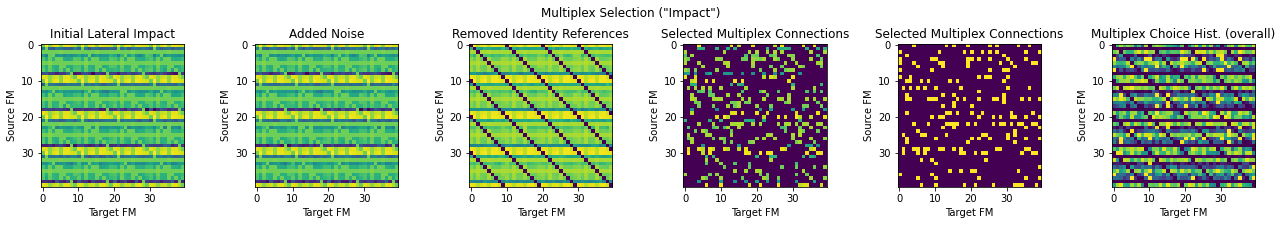

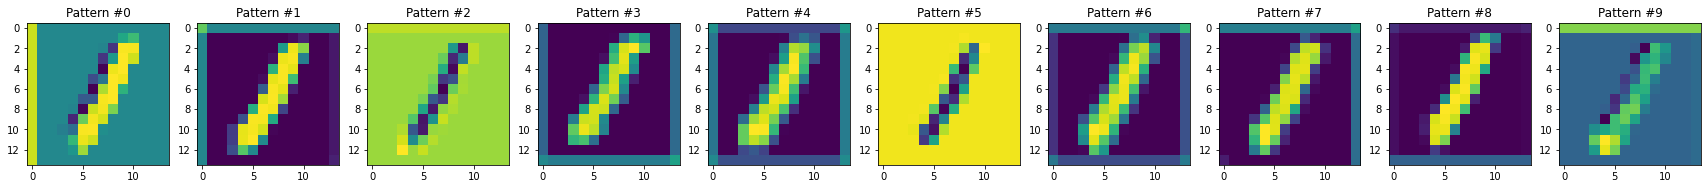

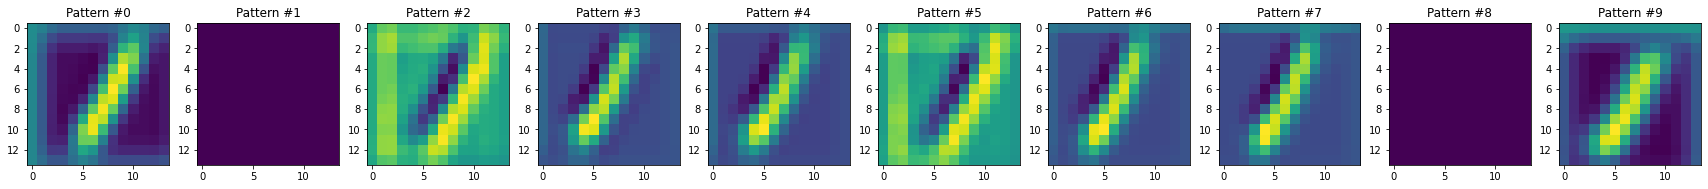

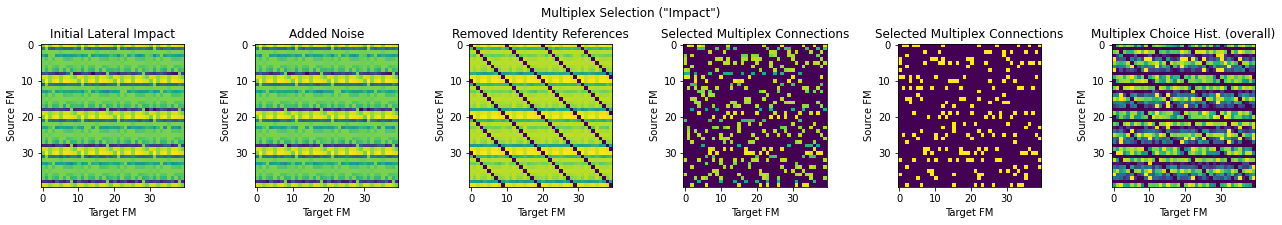

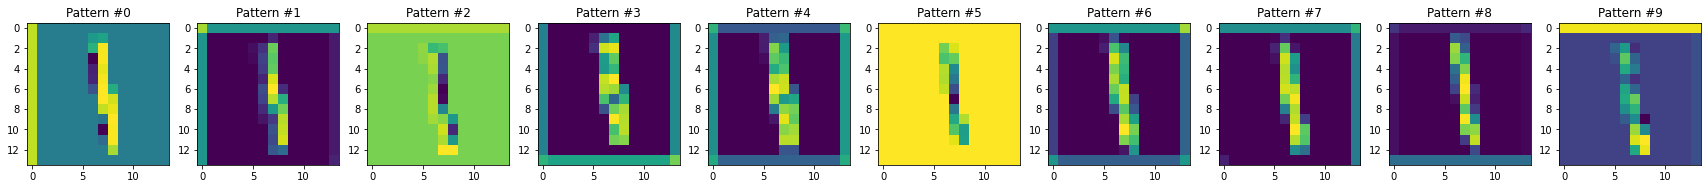

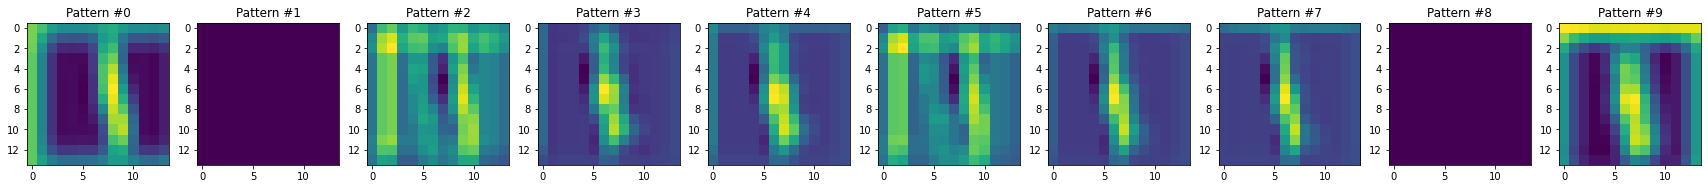

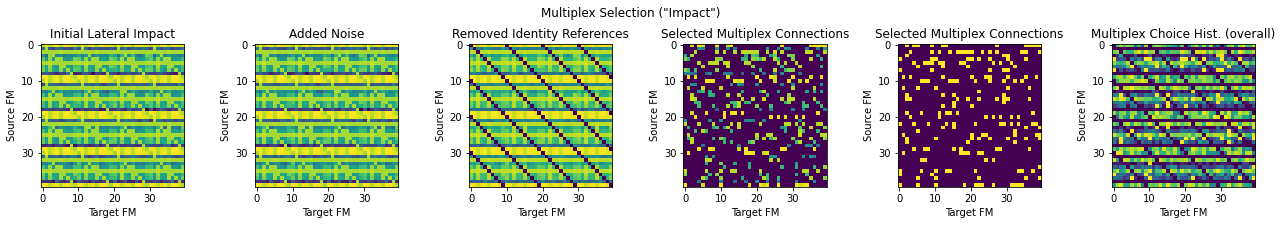

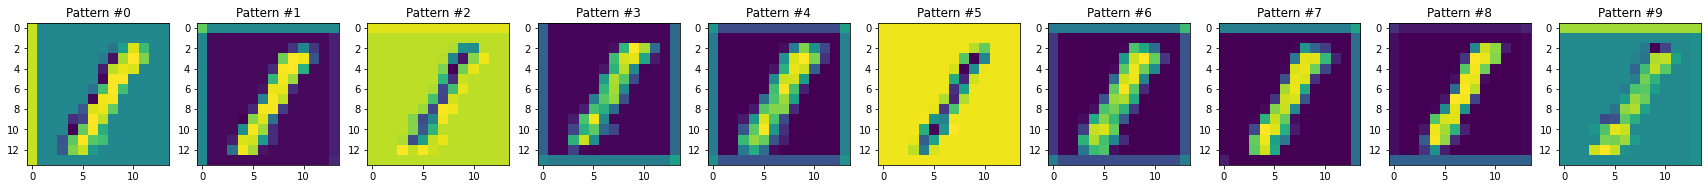

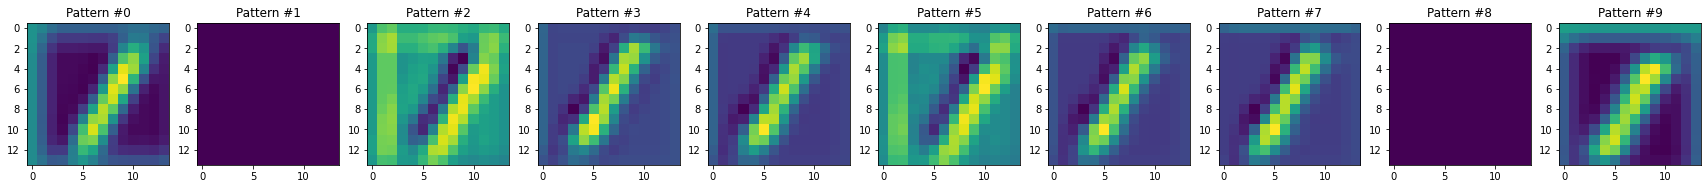

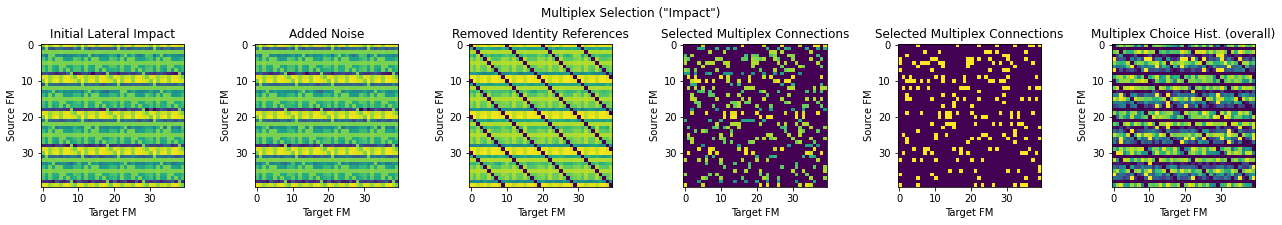

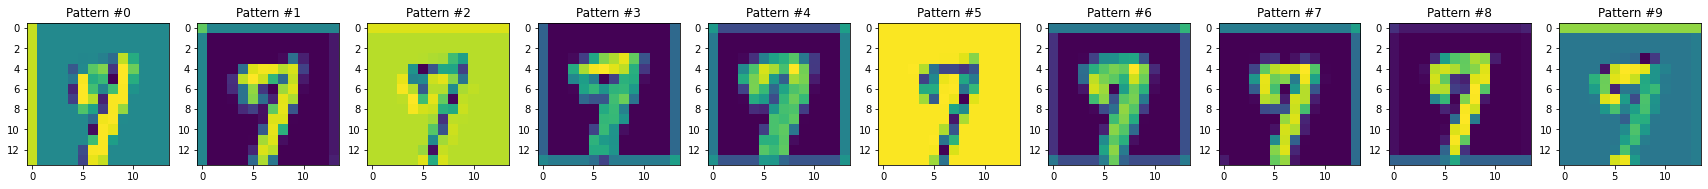

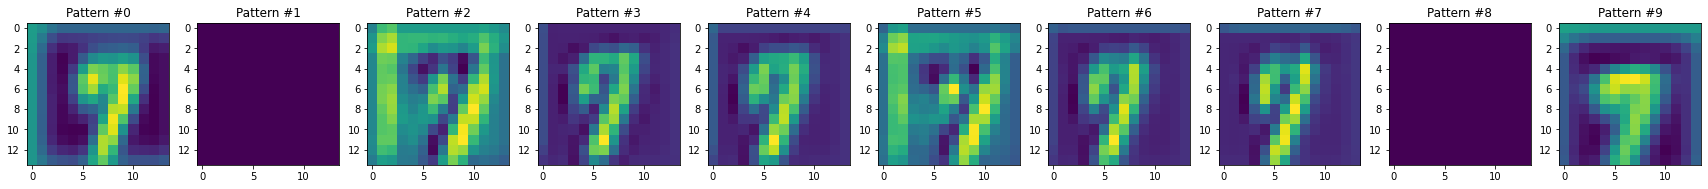

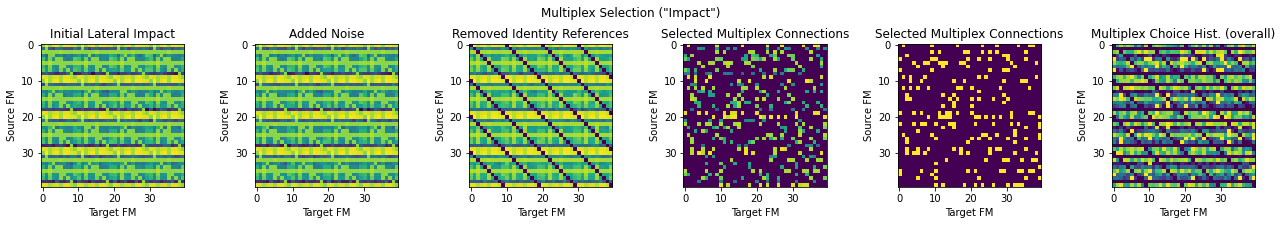

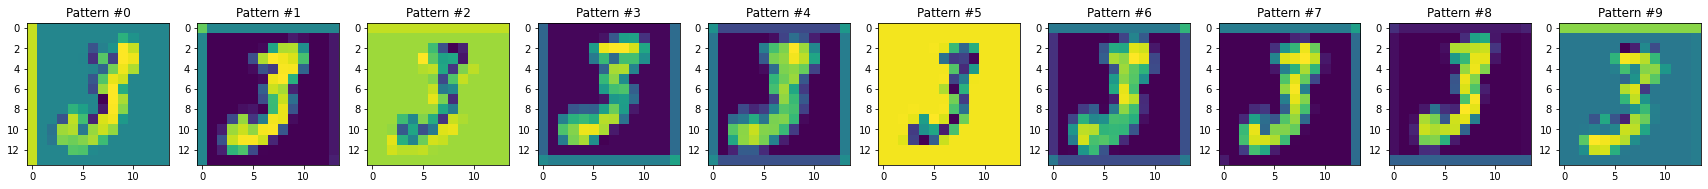

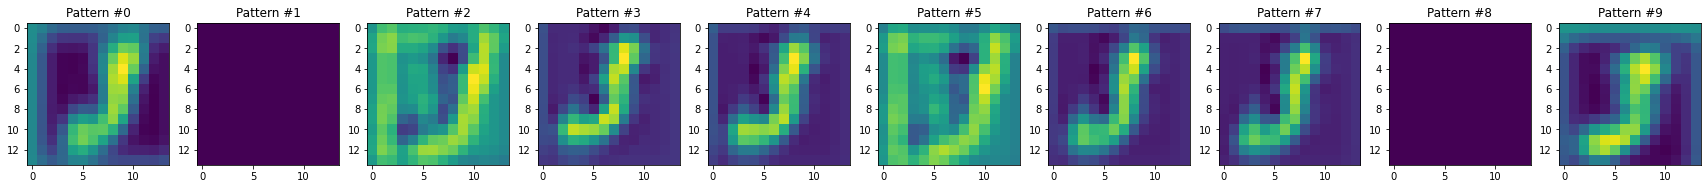

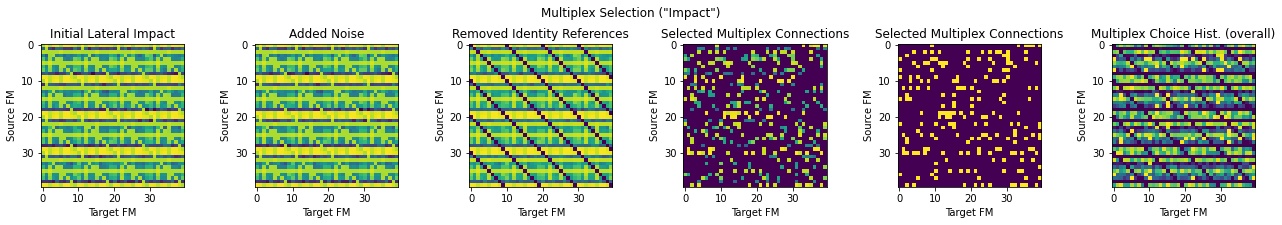

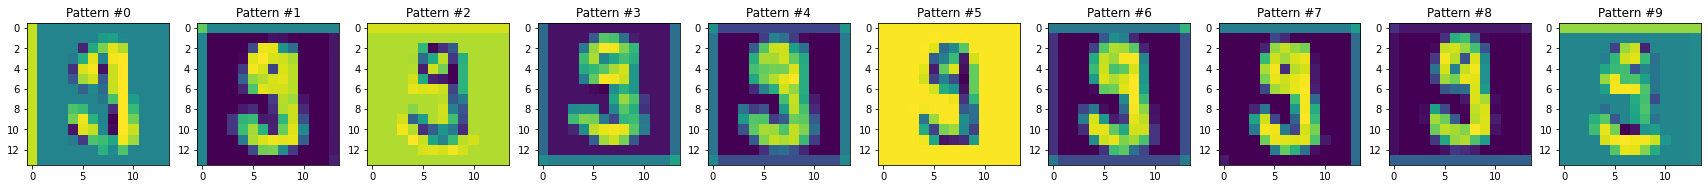

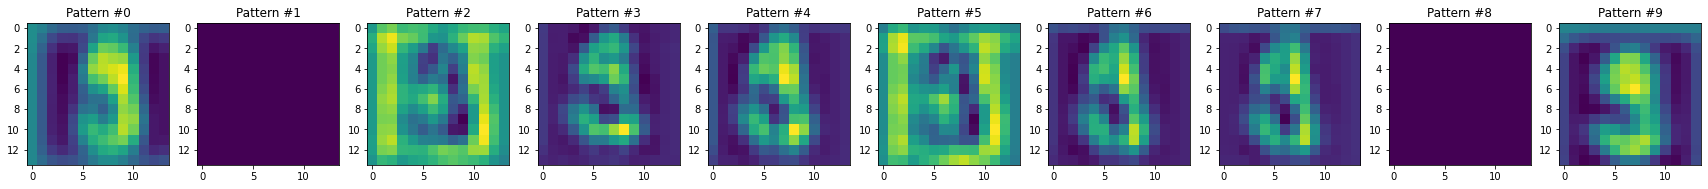

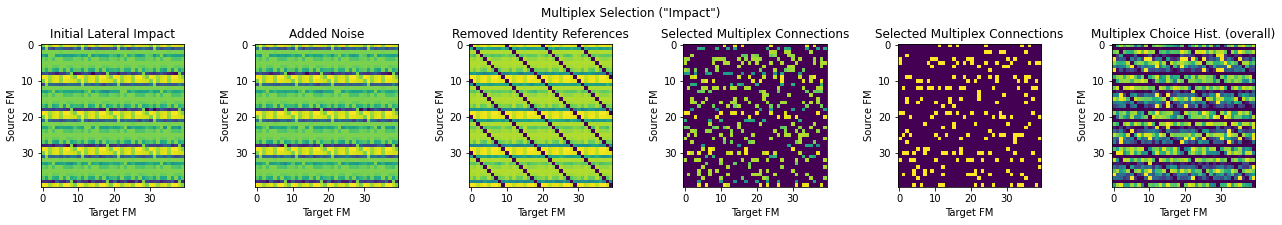

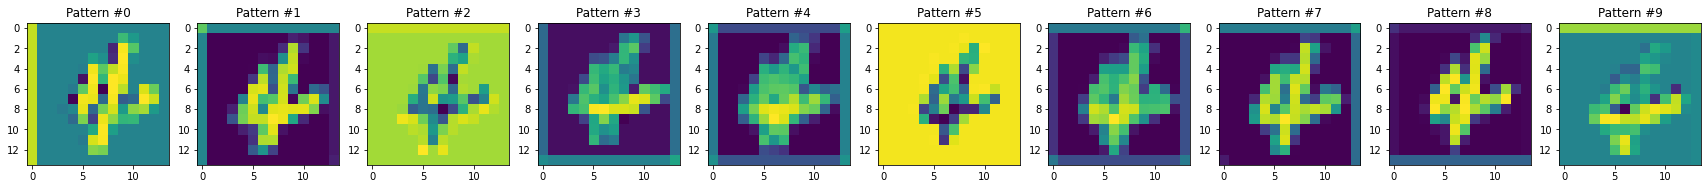

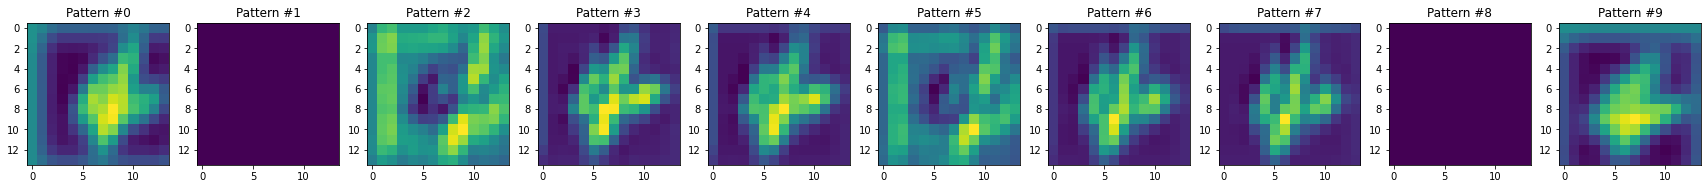

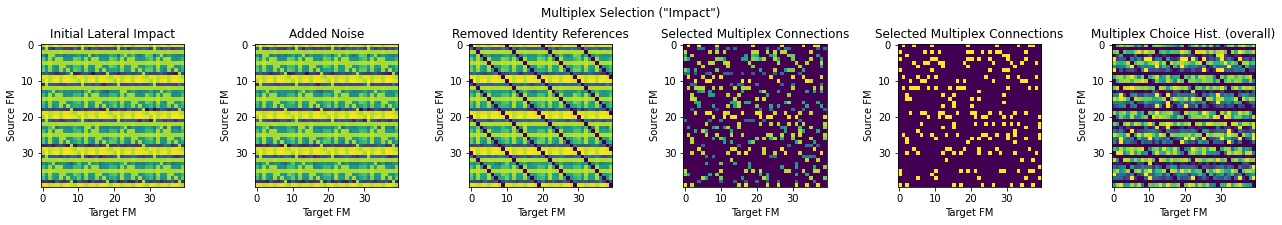

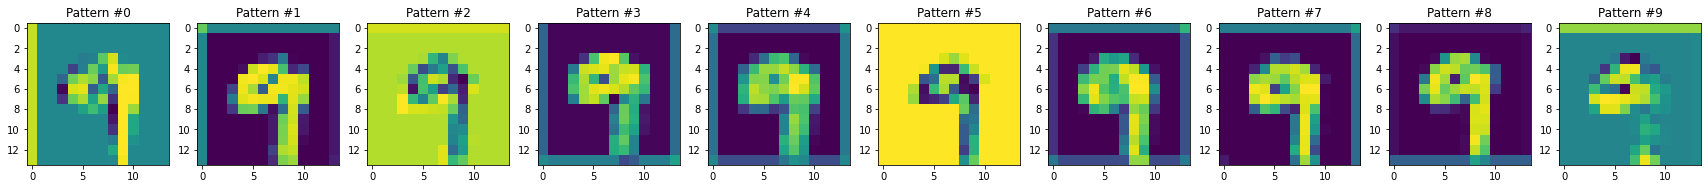

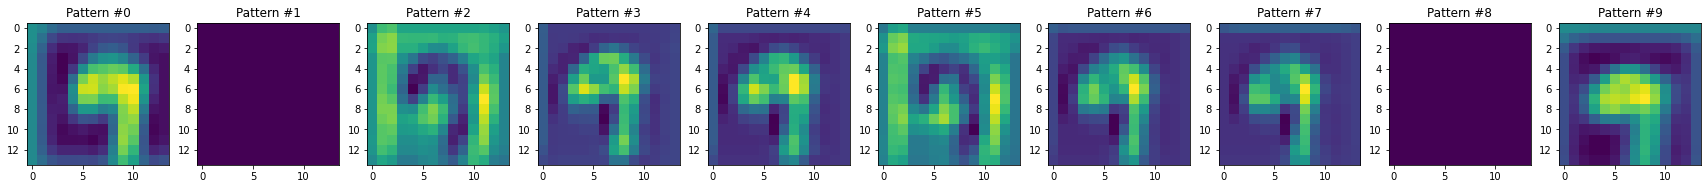

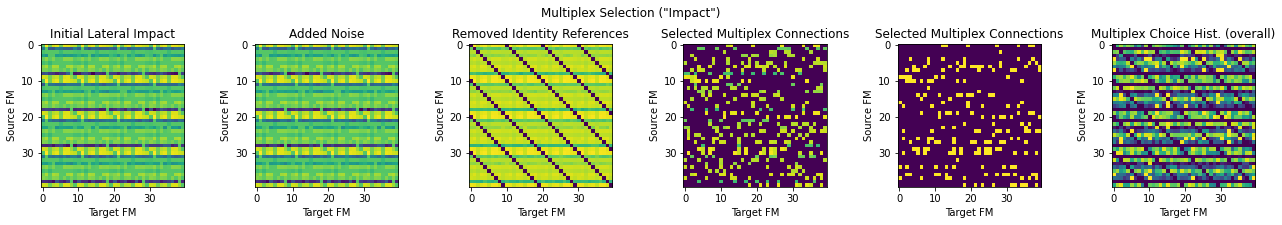

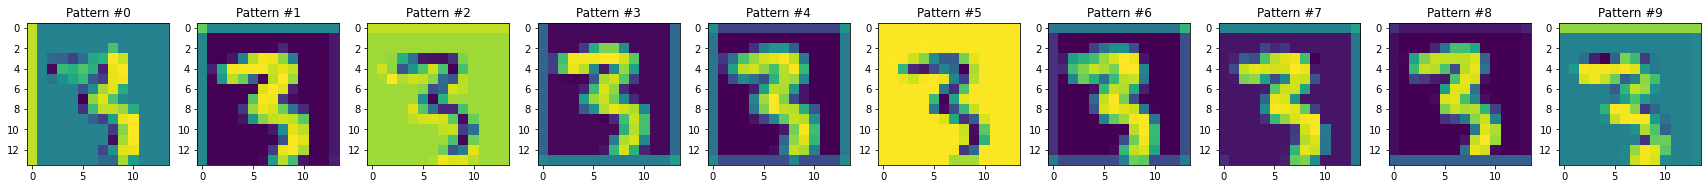

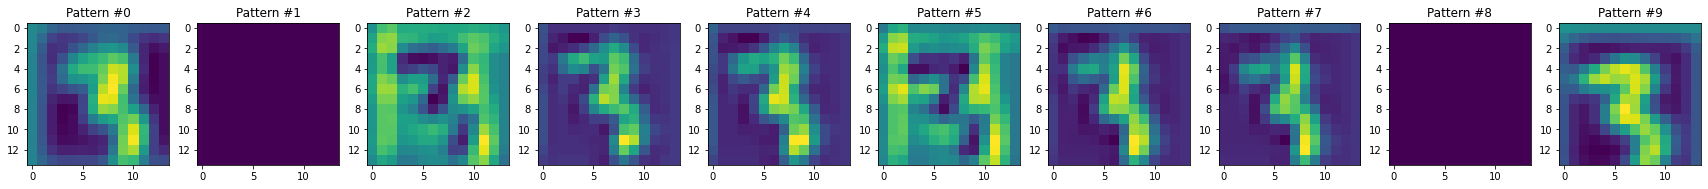

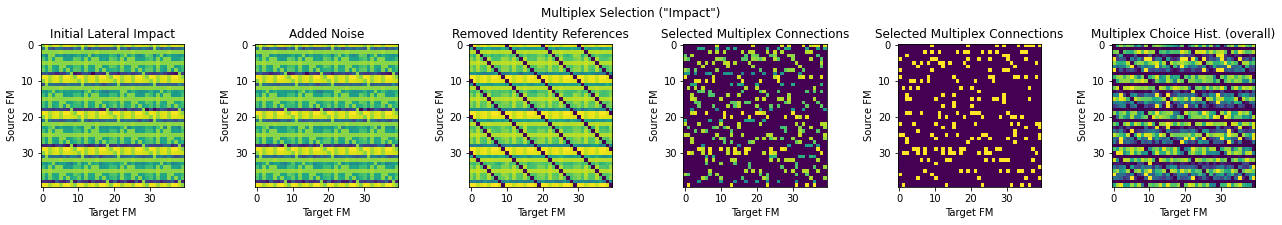

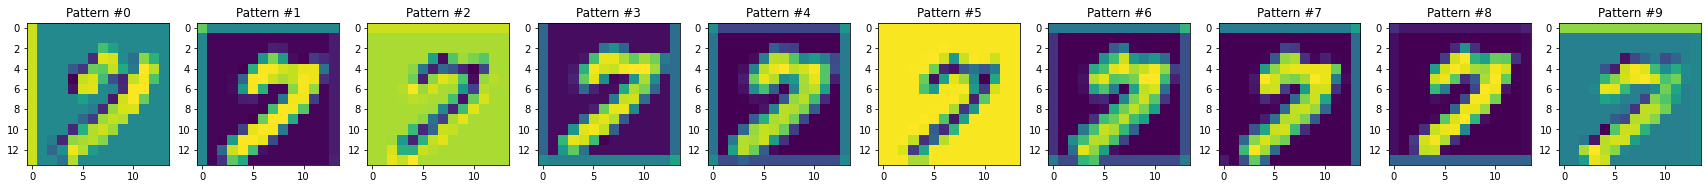

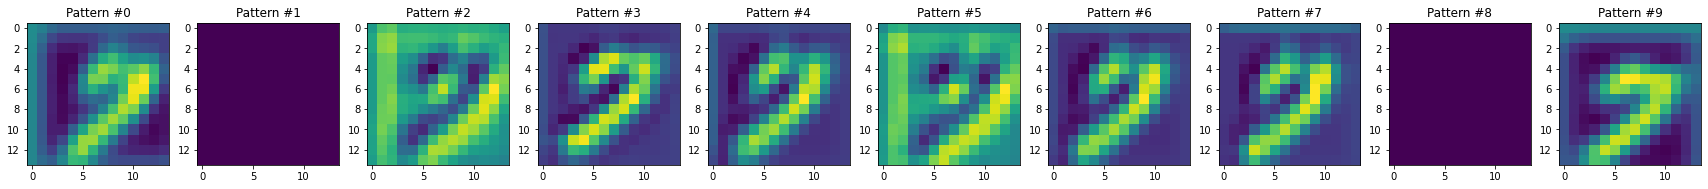

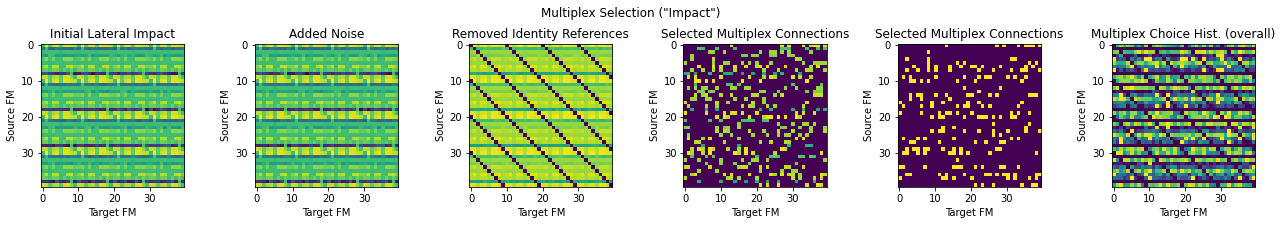

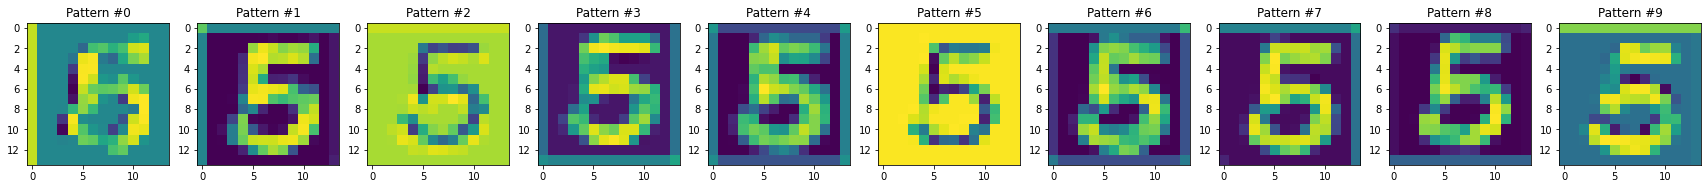

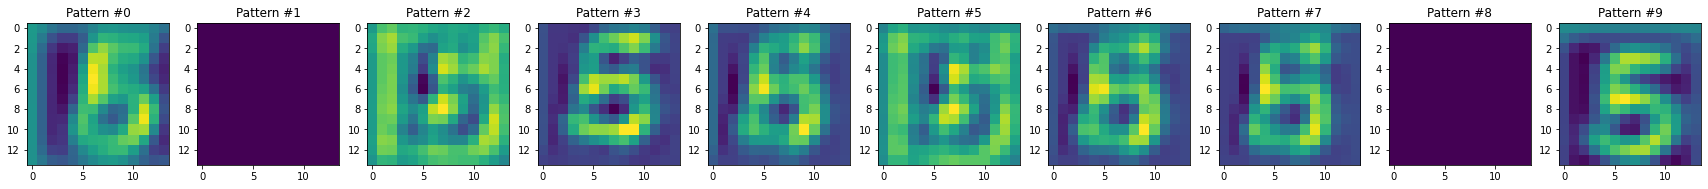

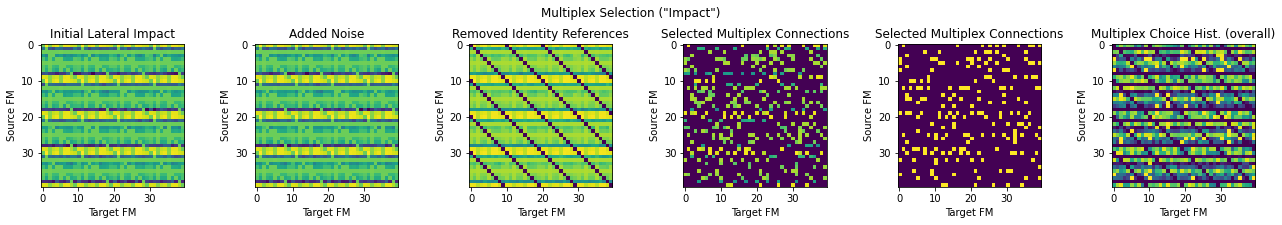

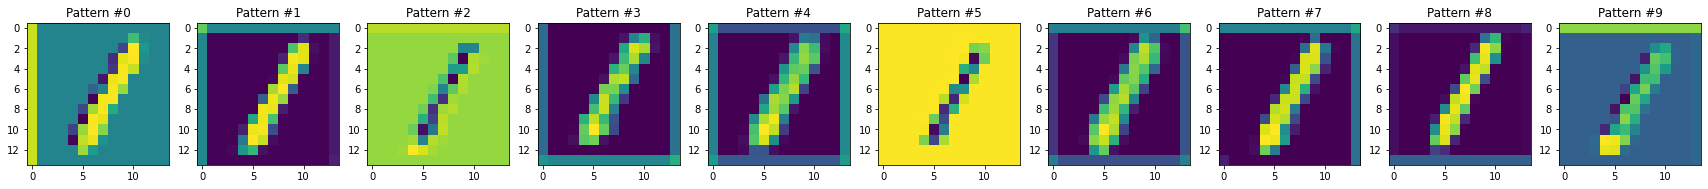

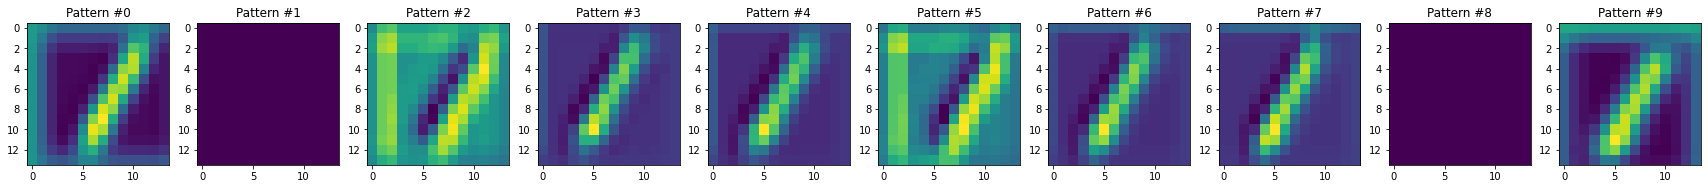

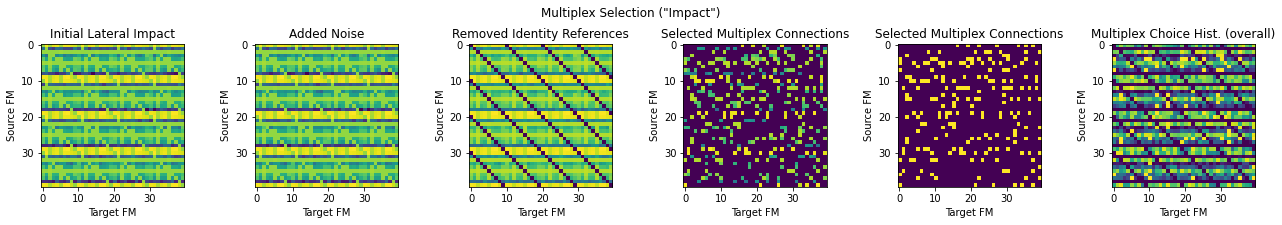

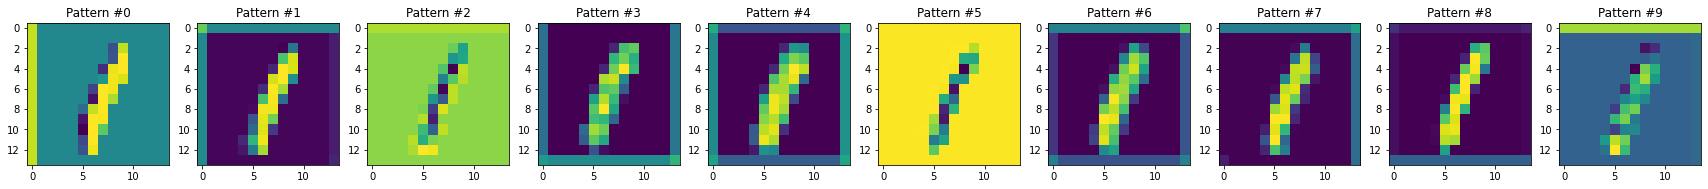

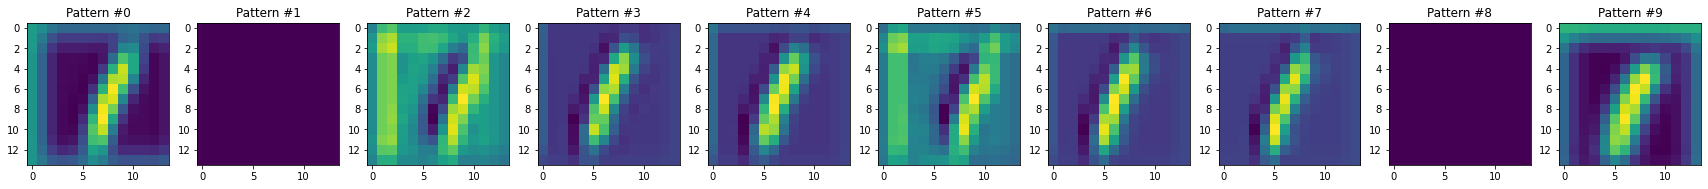

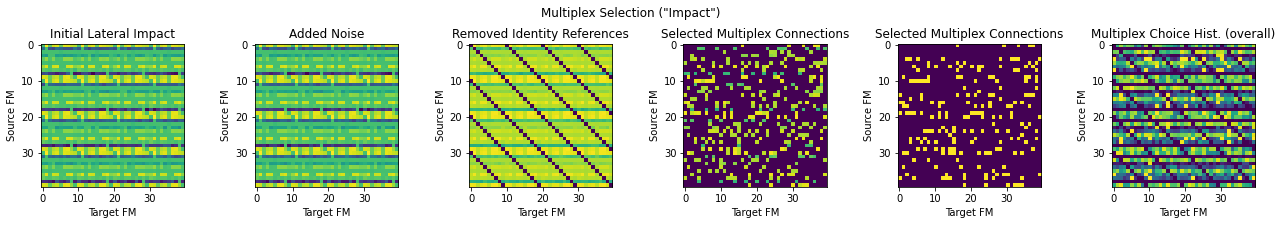

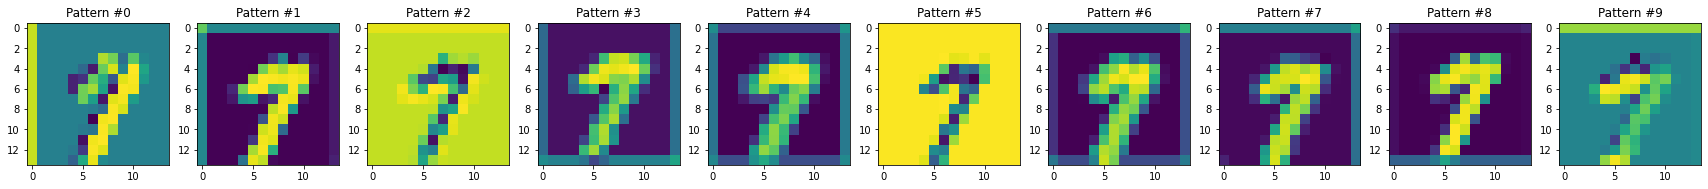

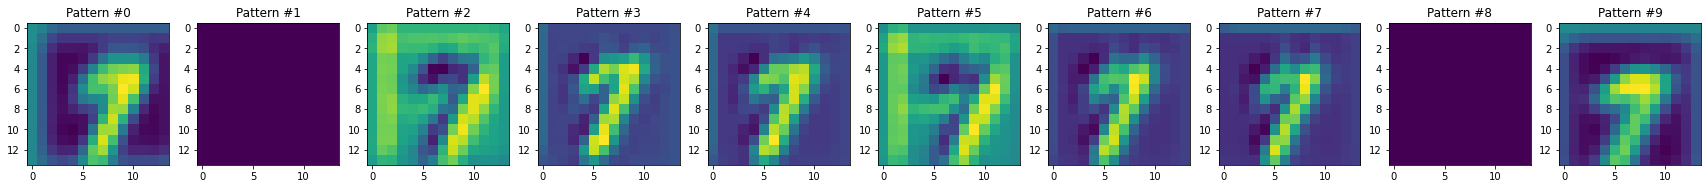

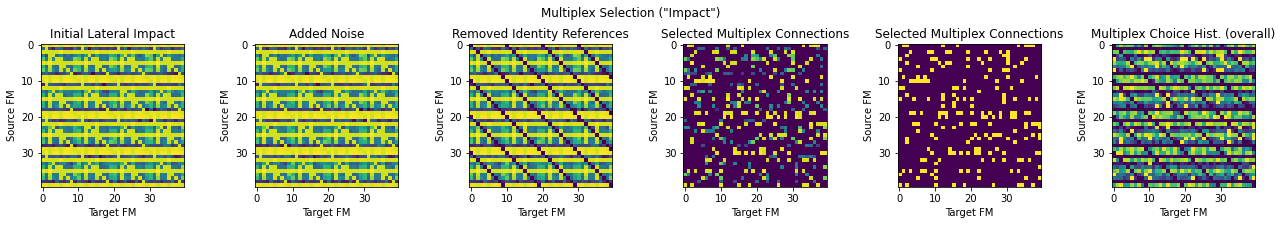

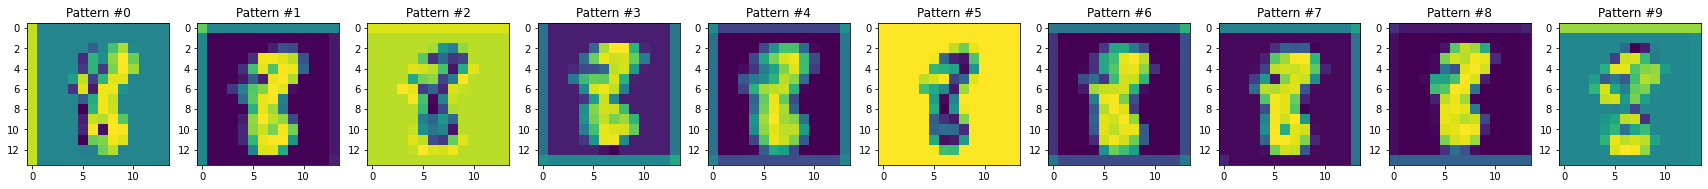

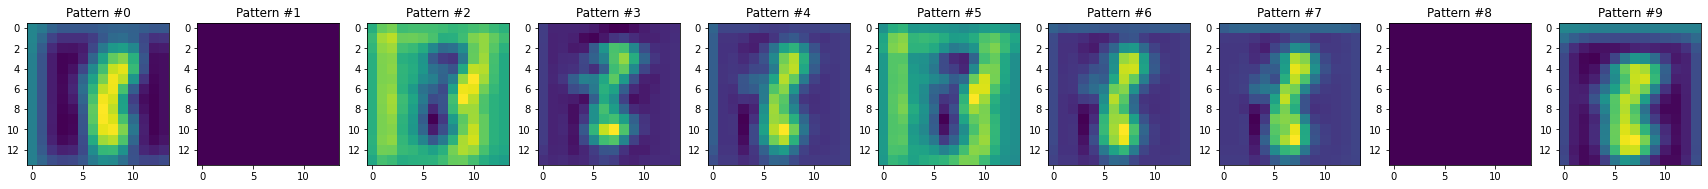

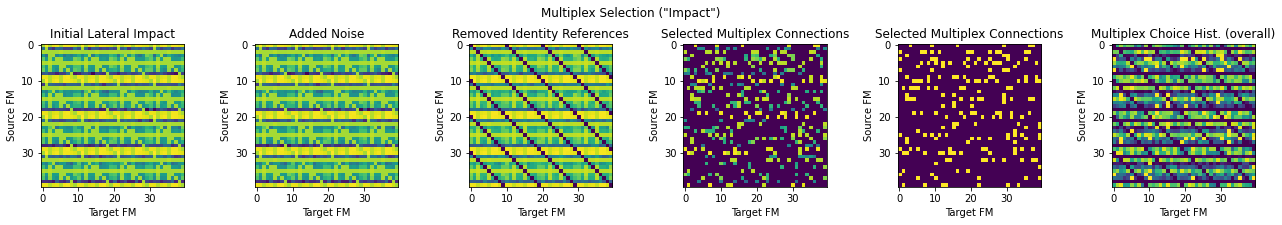

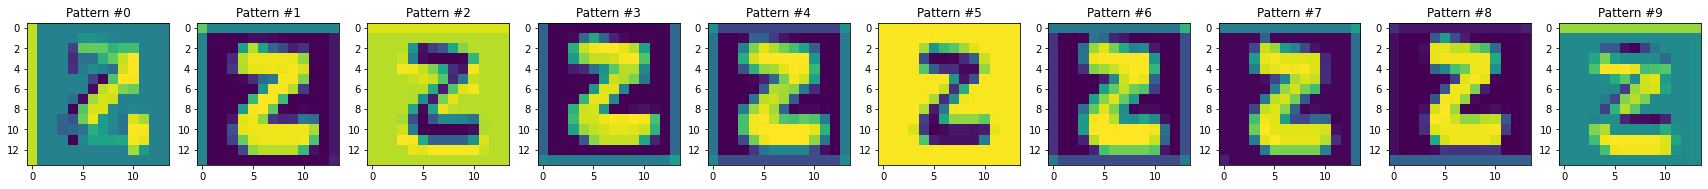

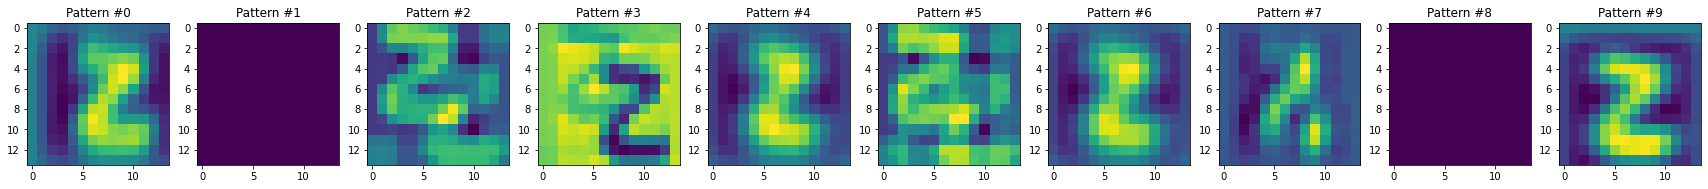

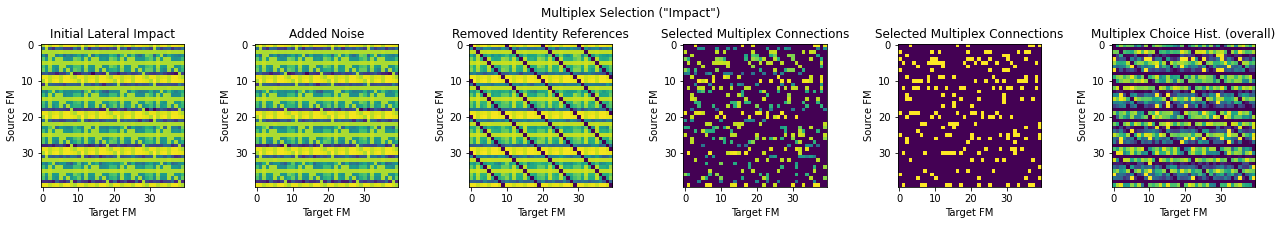

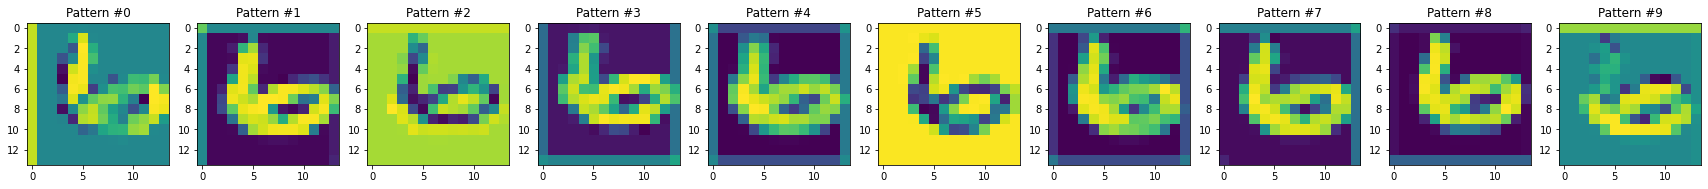

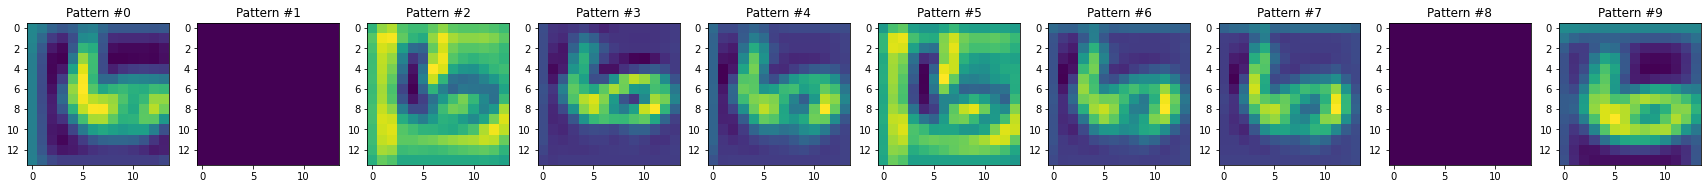

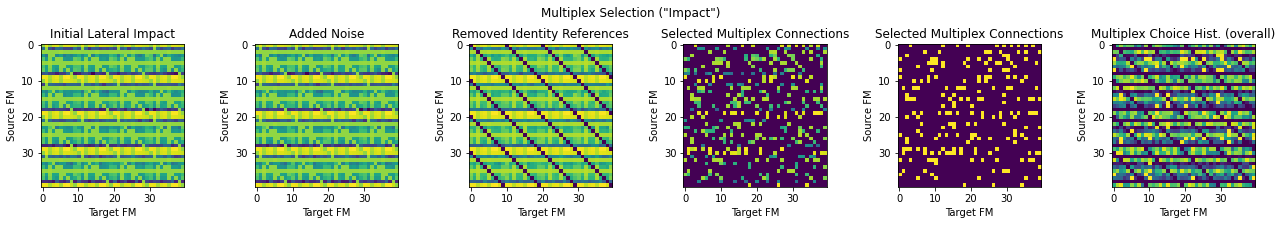

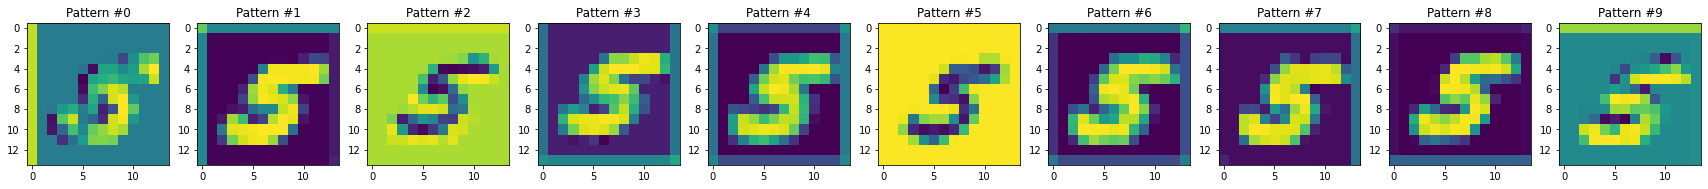

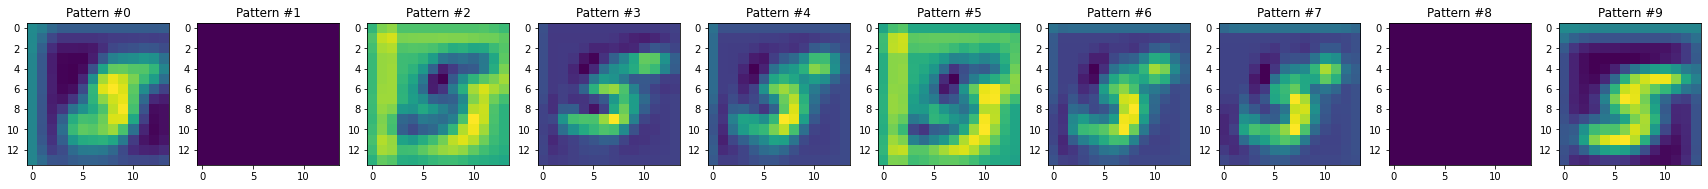

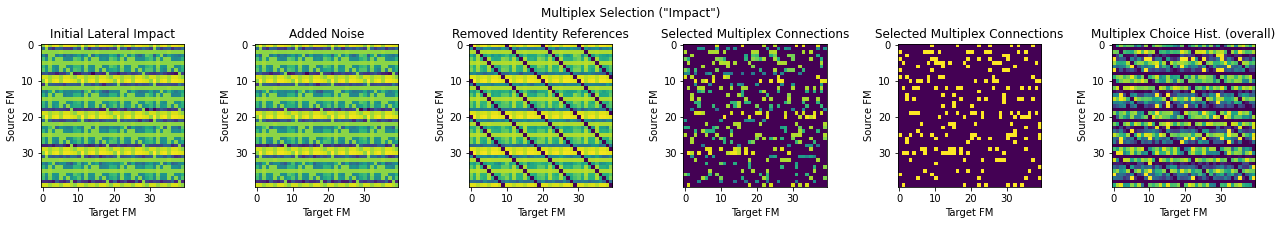

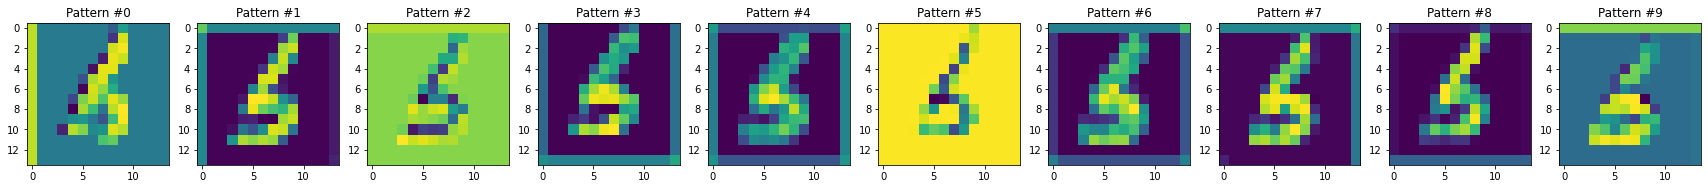

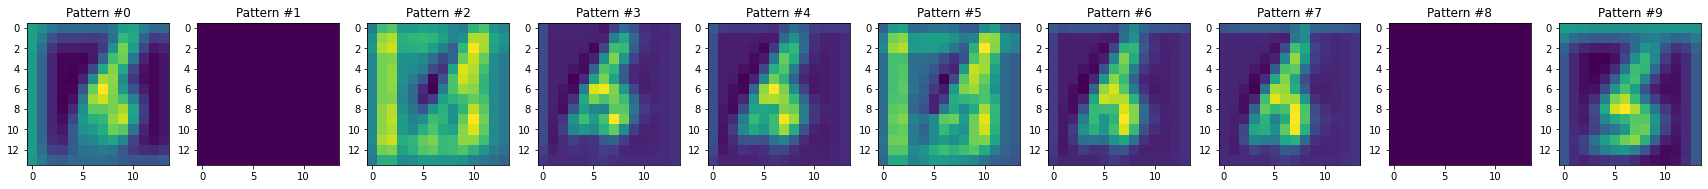

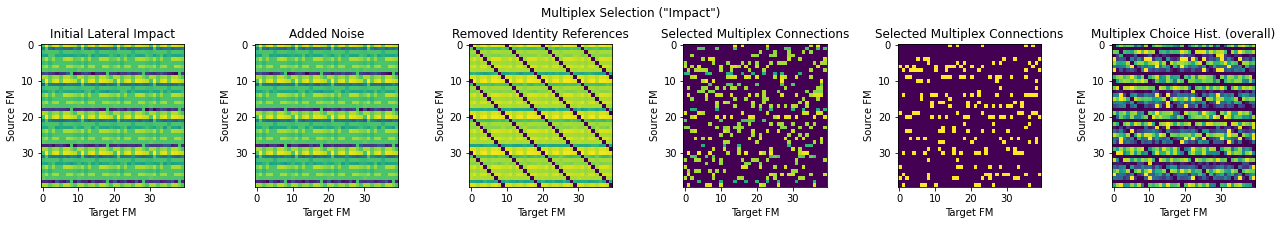

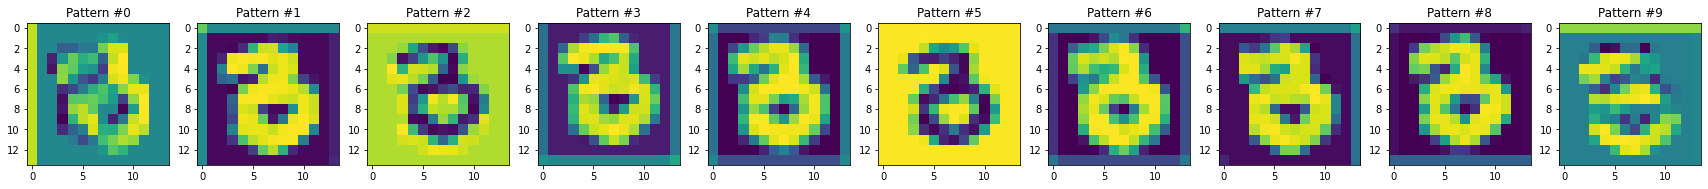

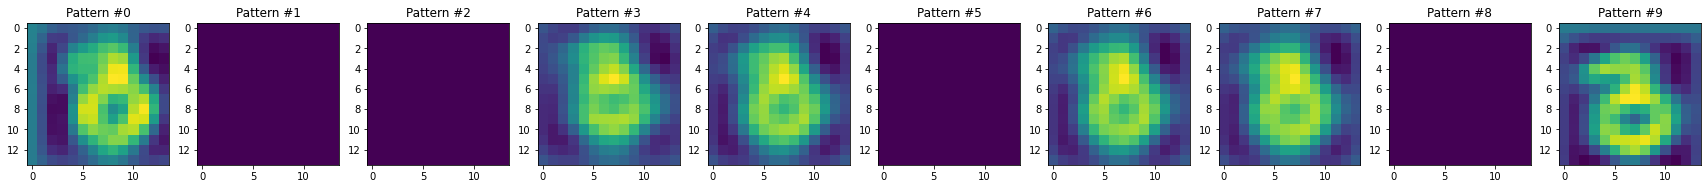

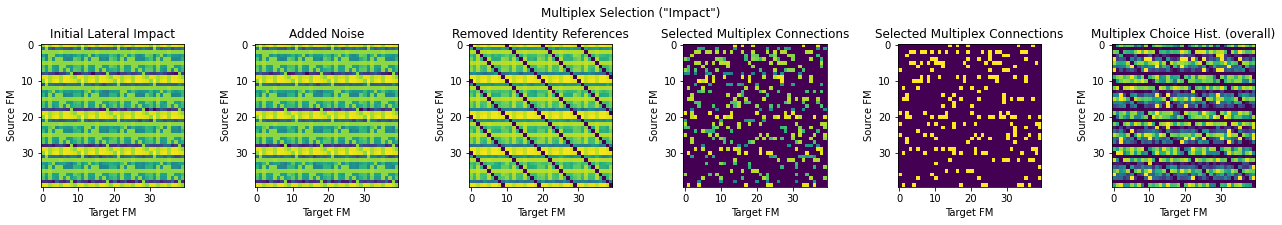

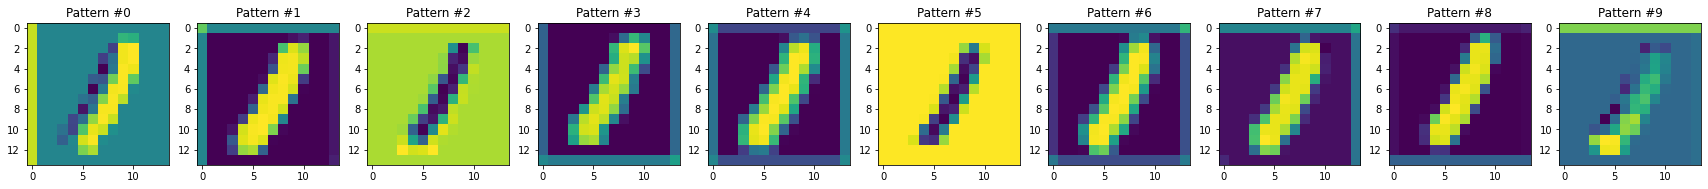

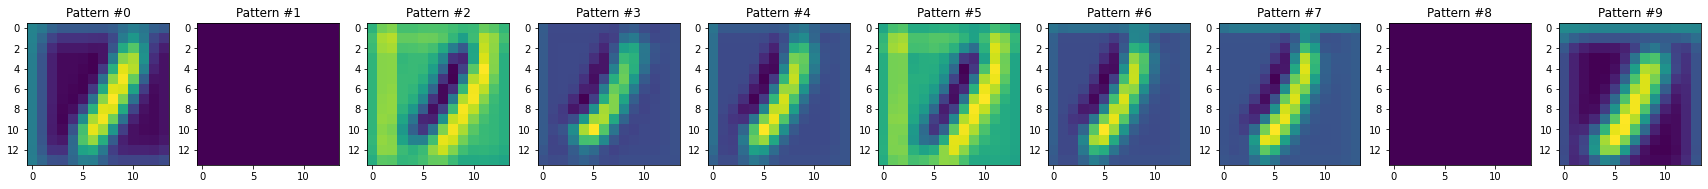

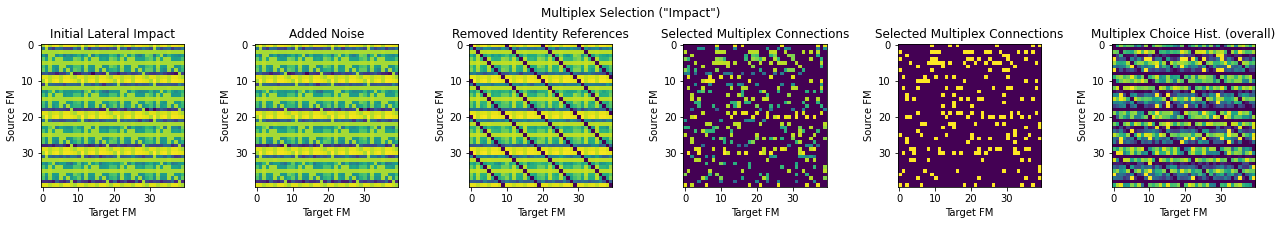

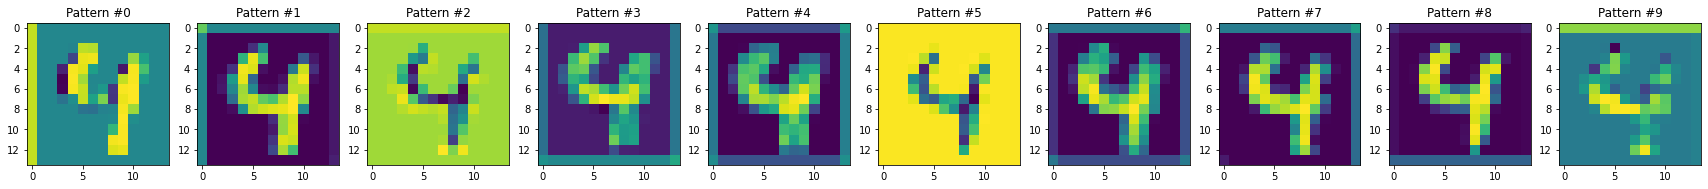

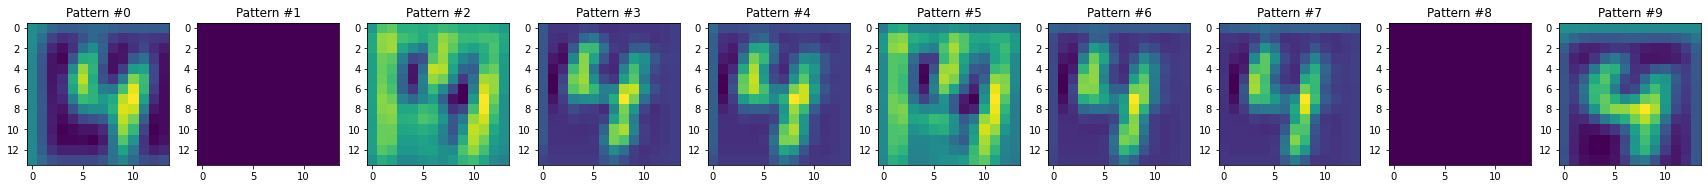

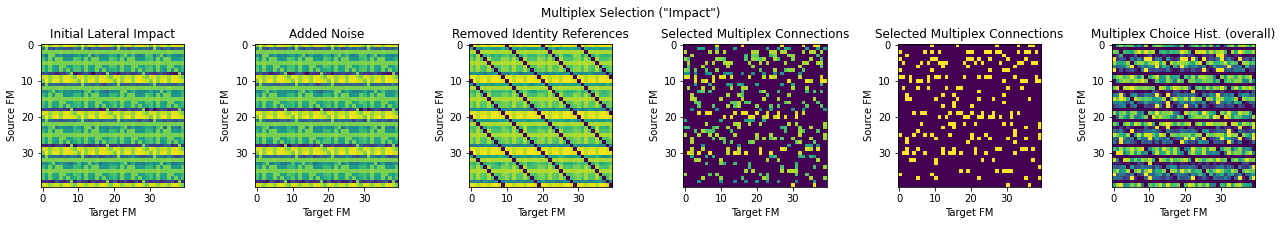

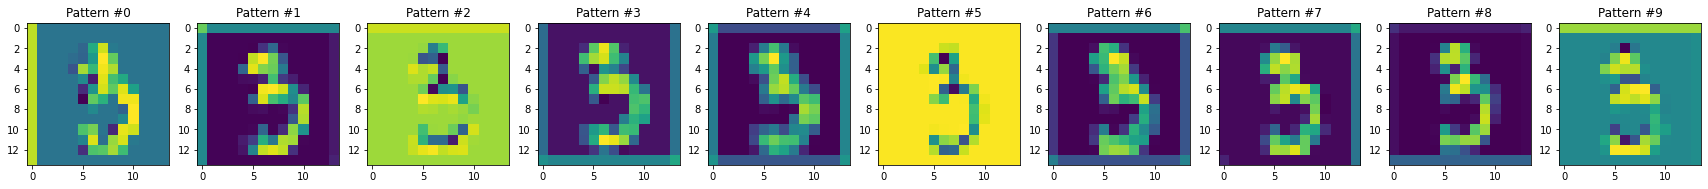

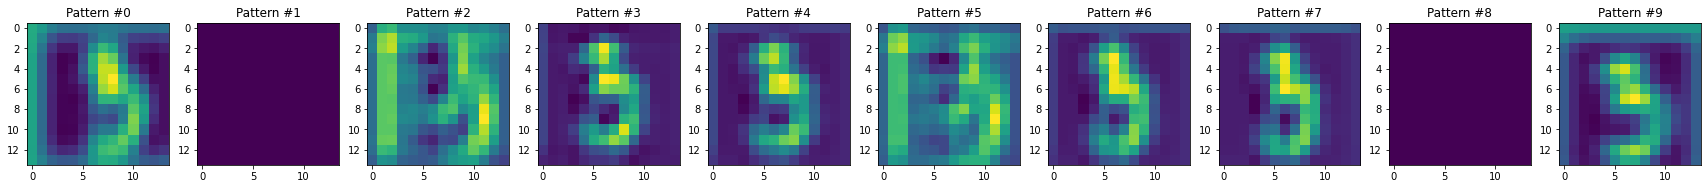

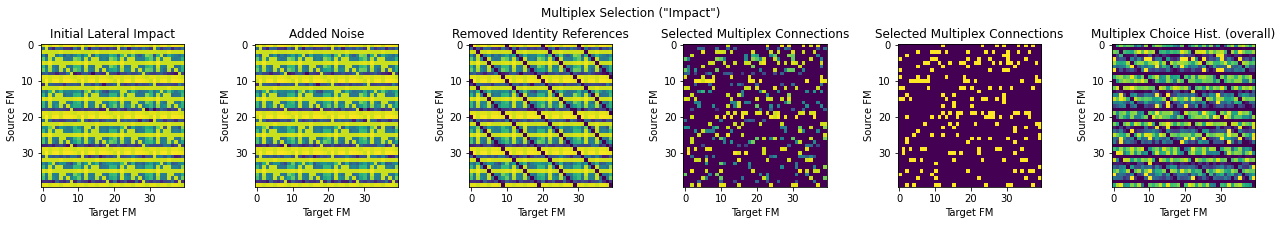

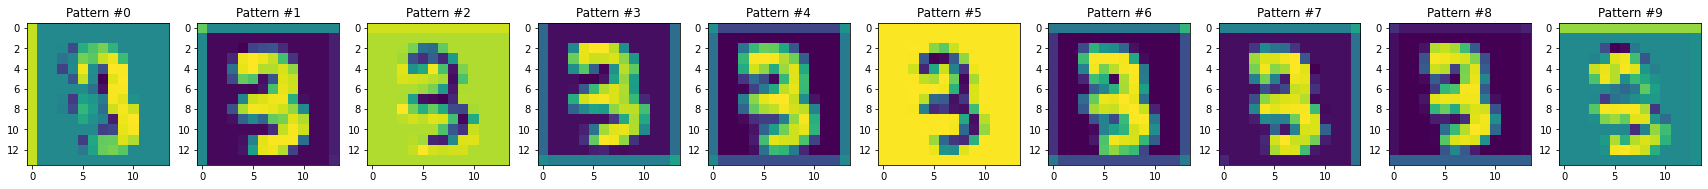

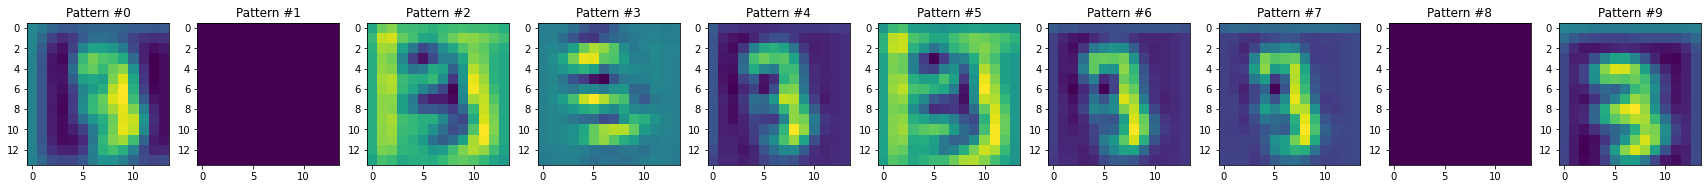

Testing:   0%|          | 0/1000 [00:00<?, ?it/s]

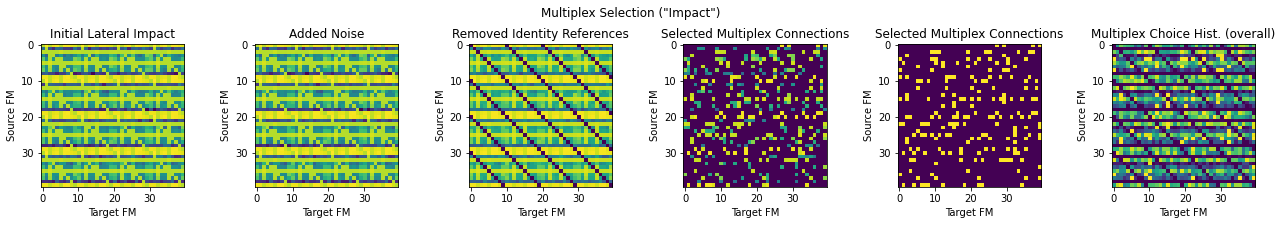

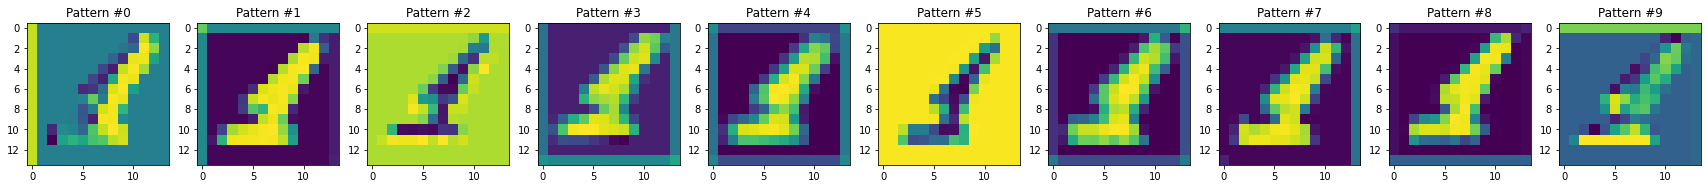

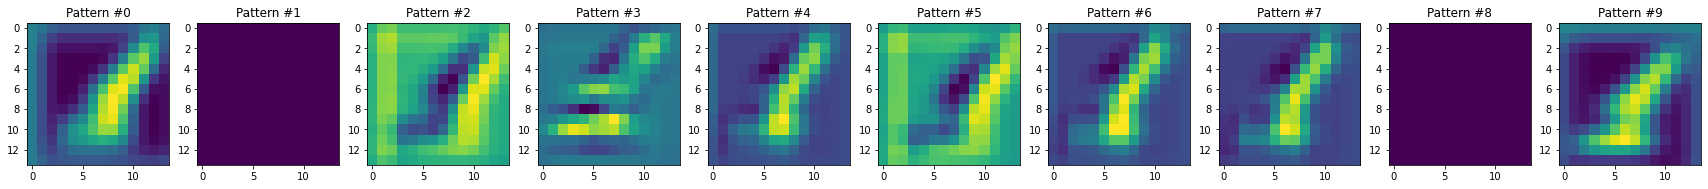

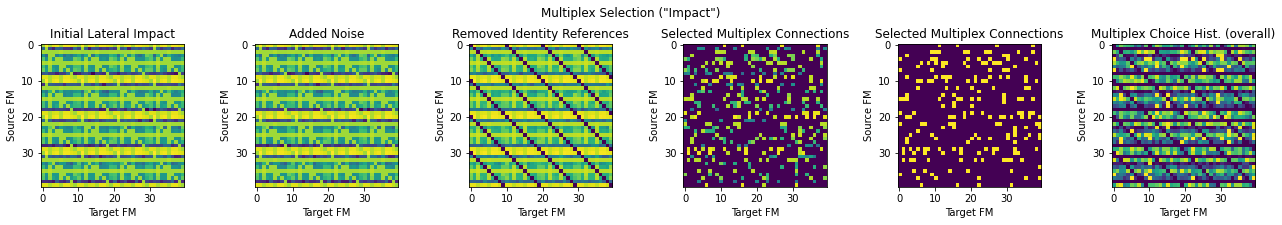

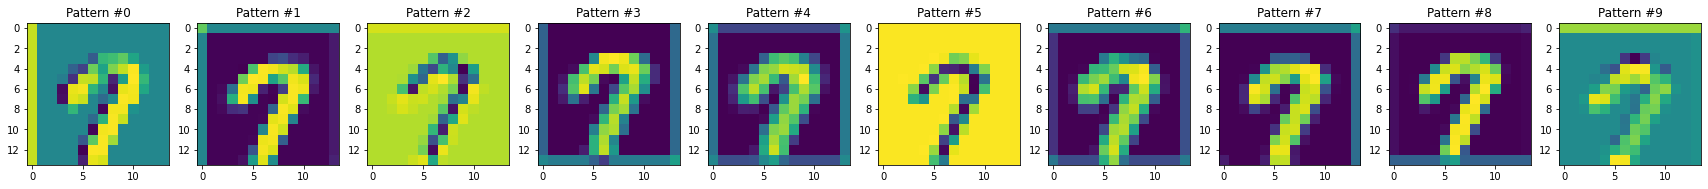

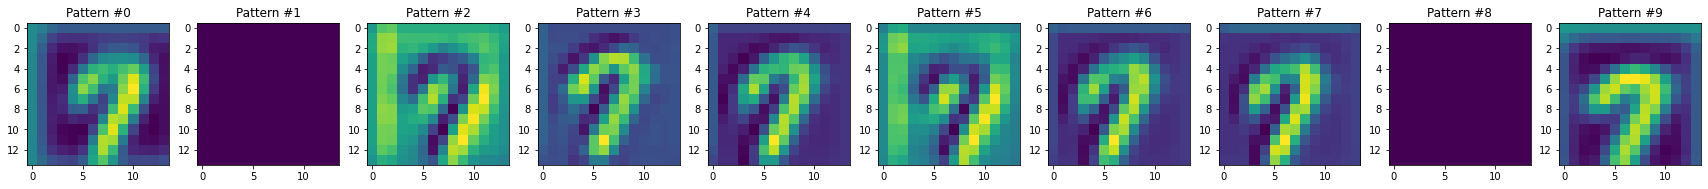

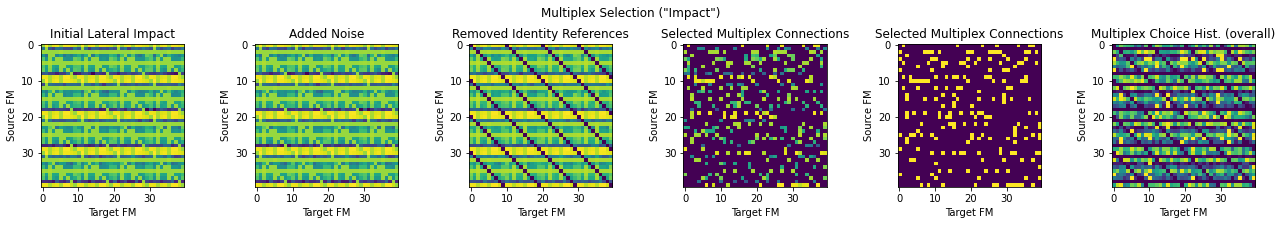

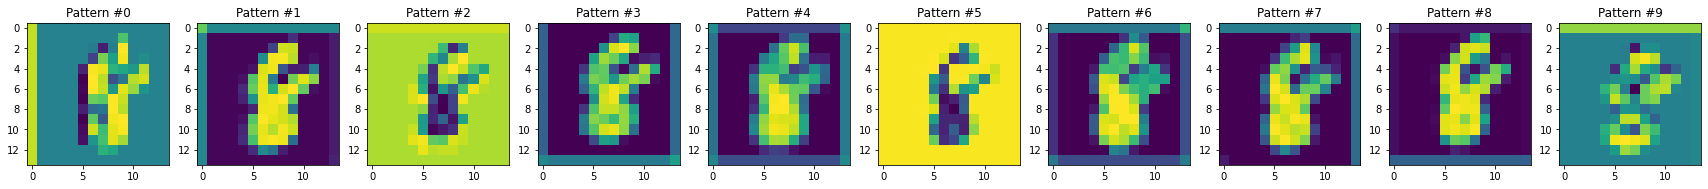

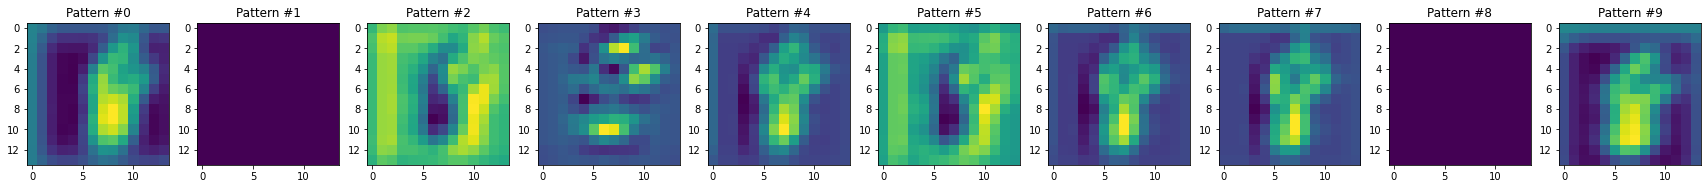

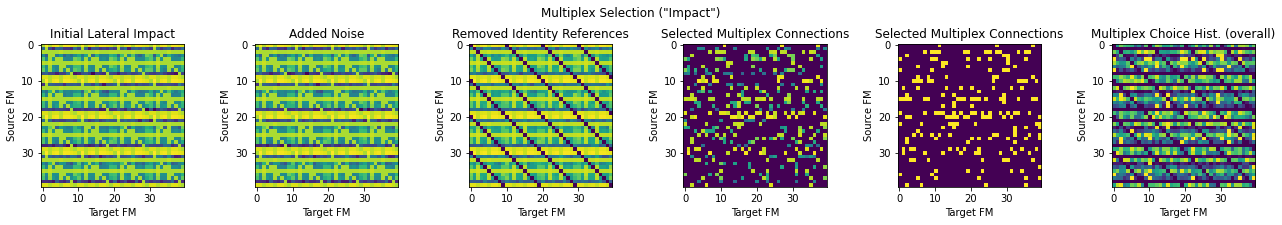

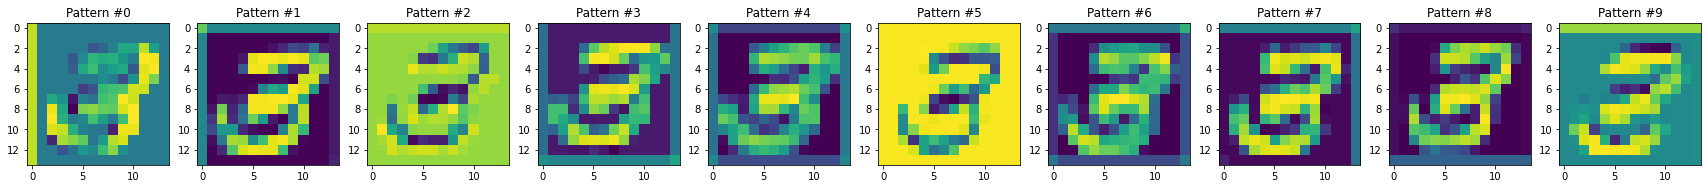

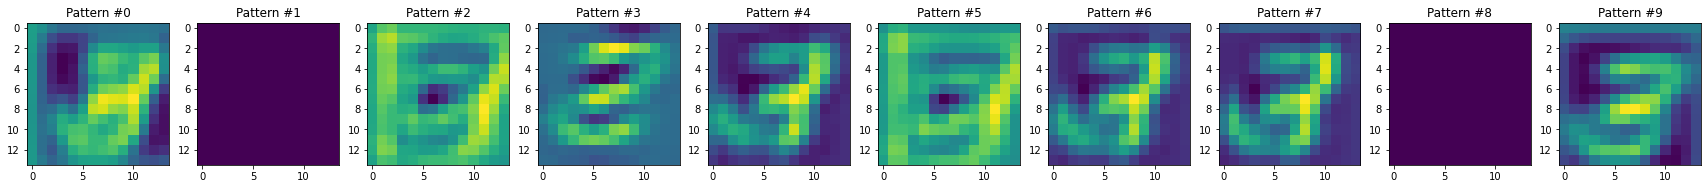

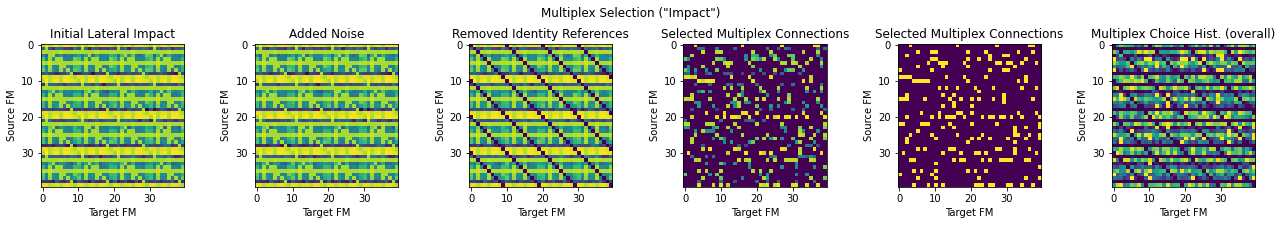

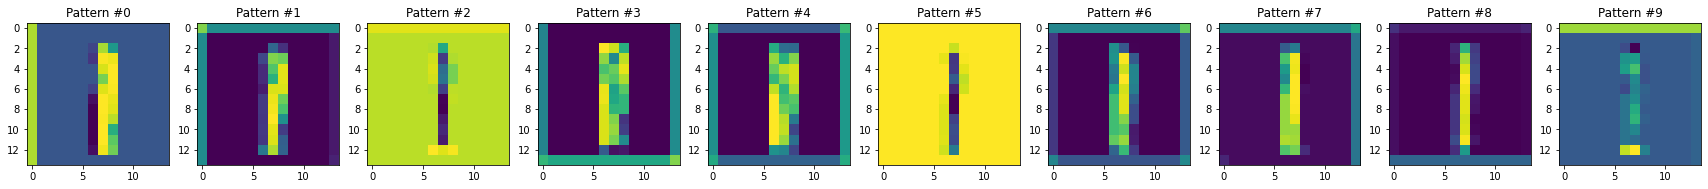

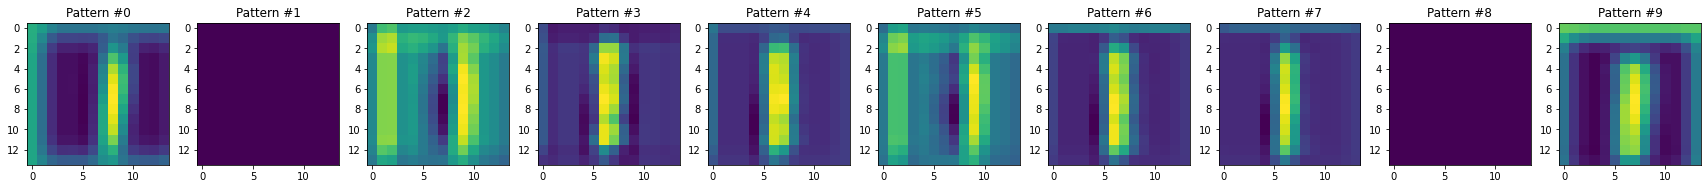

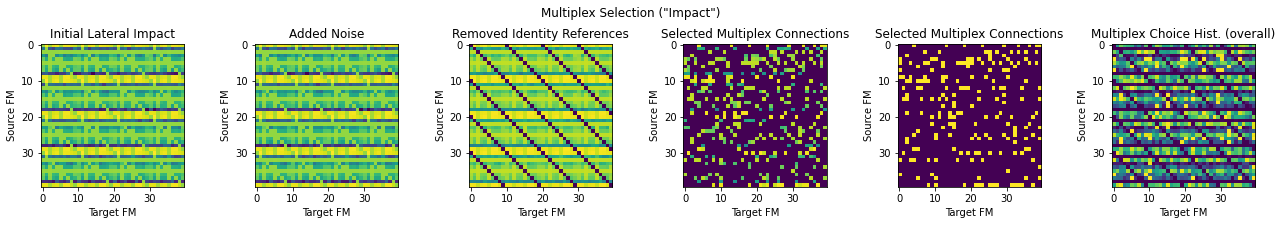

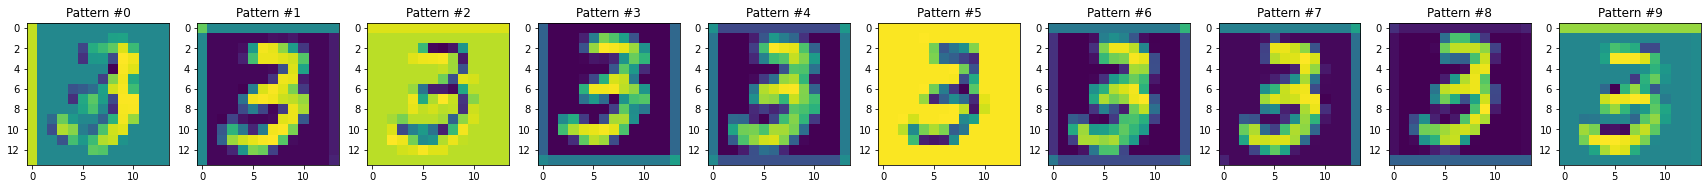

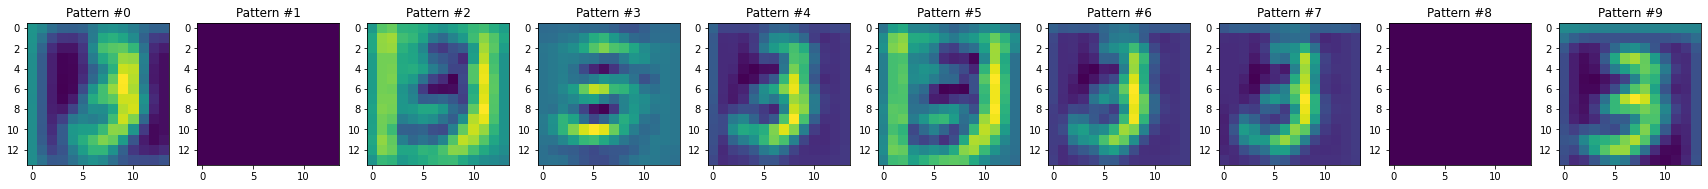

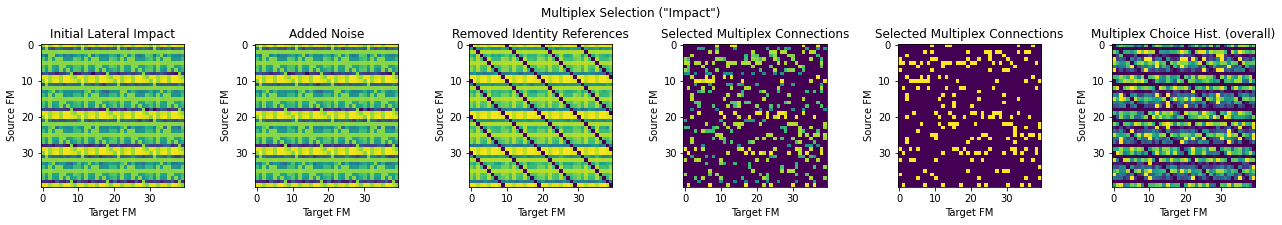

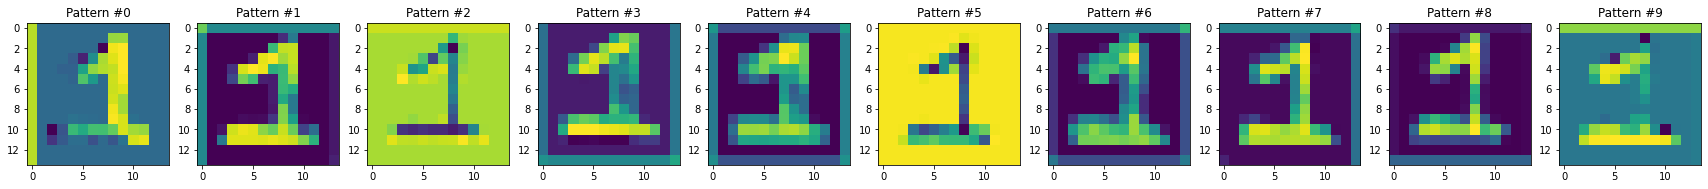

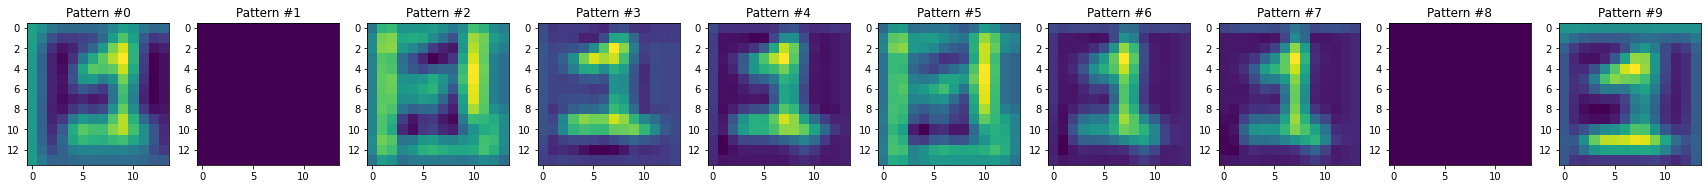

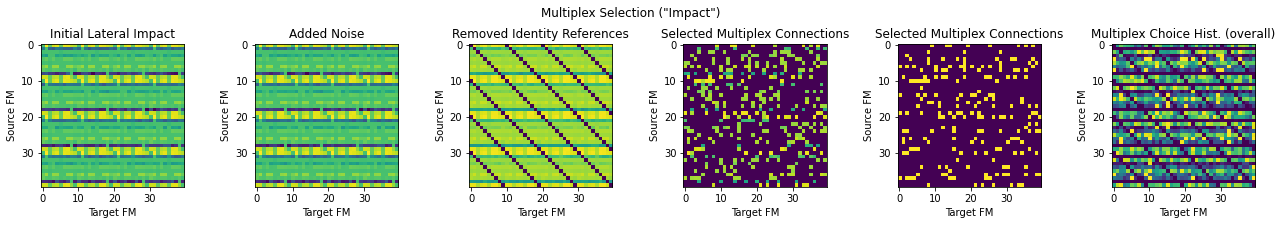

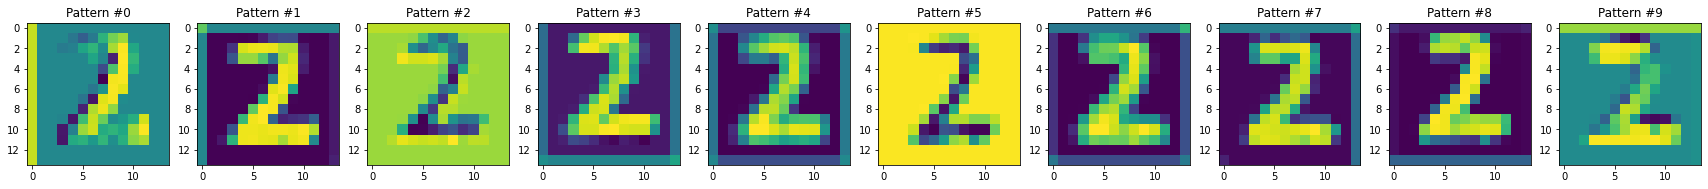

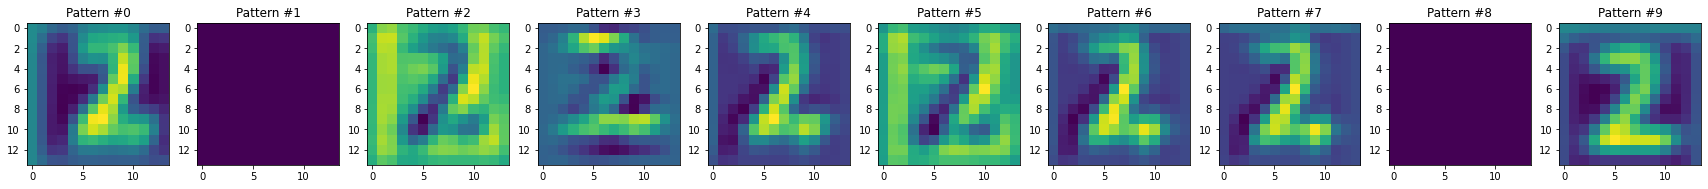

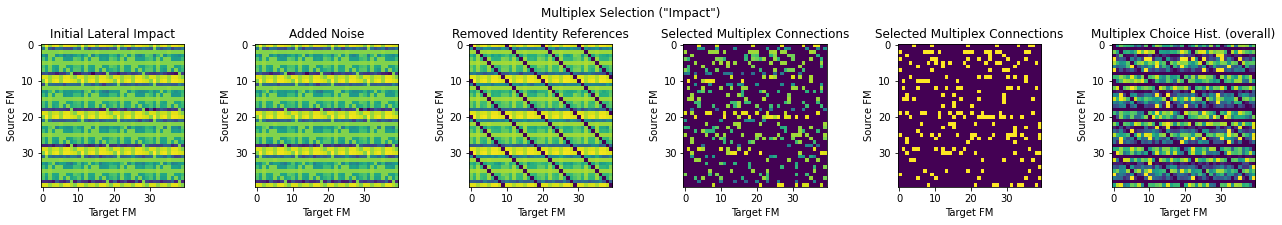

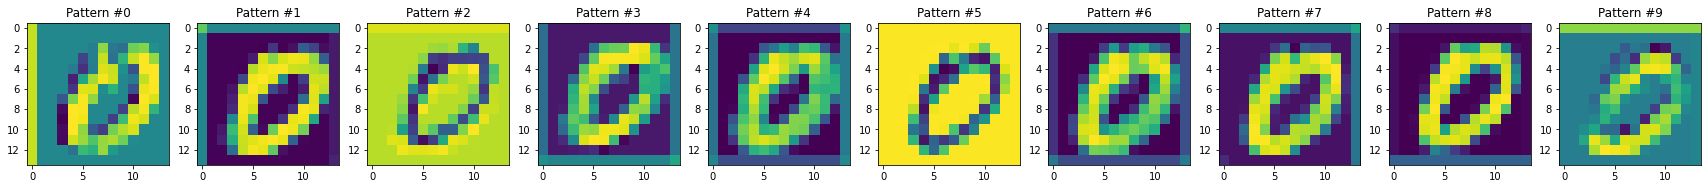

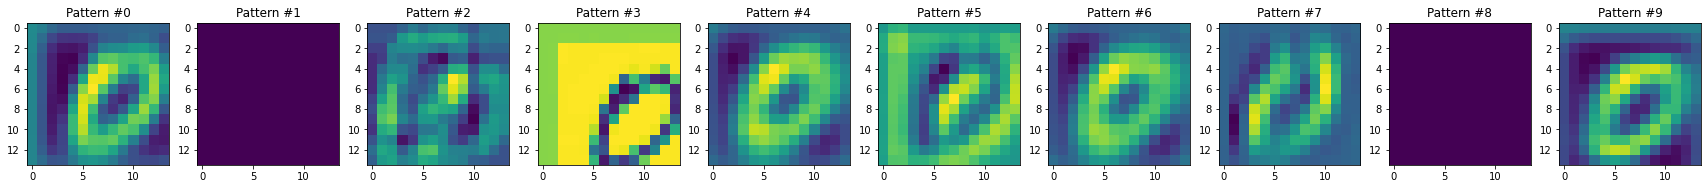

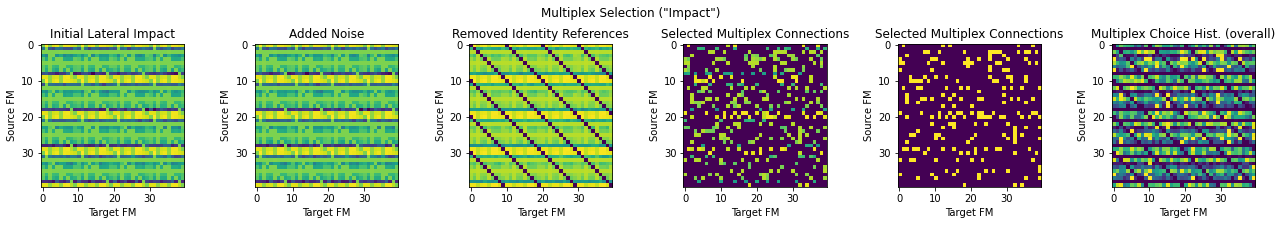

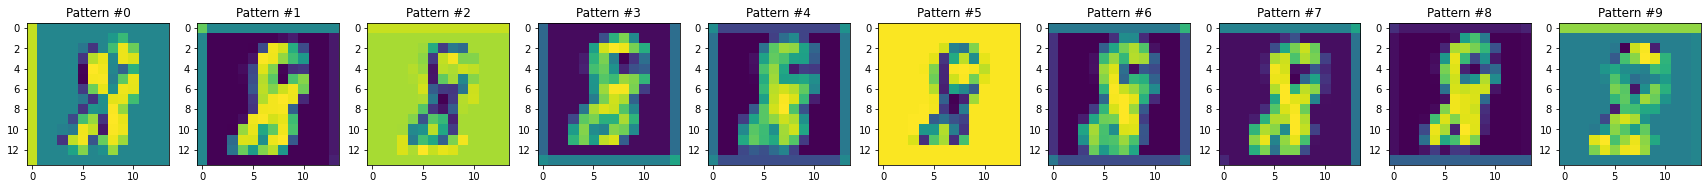

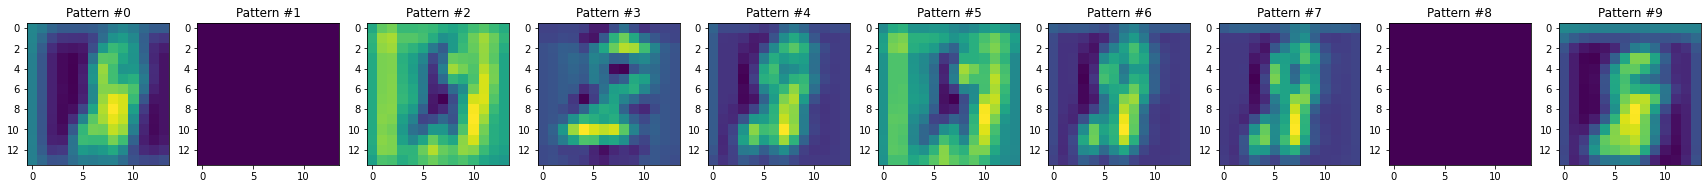

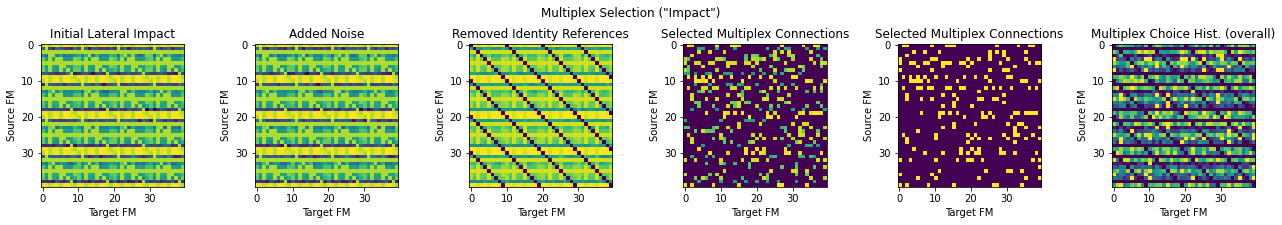

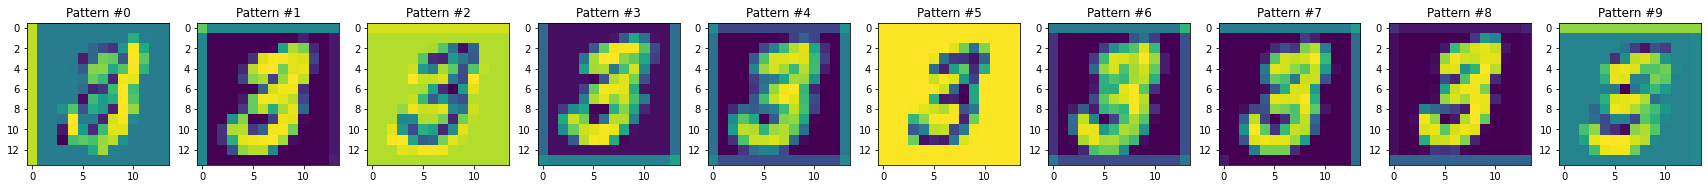

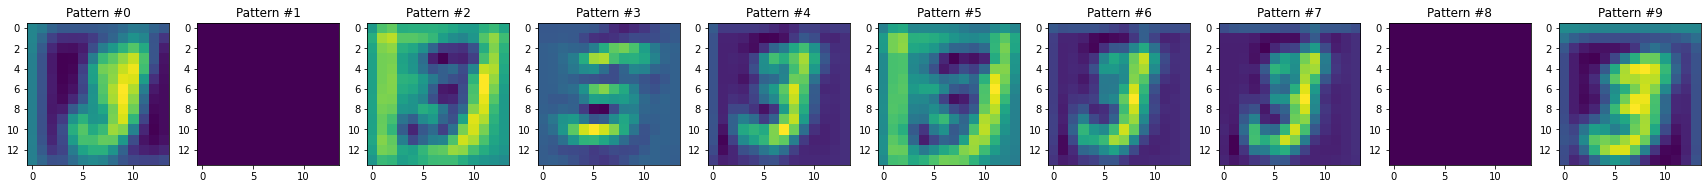

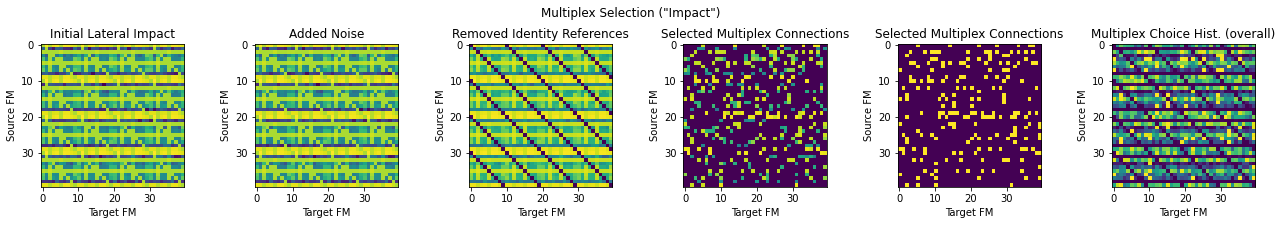

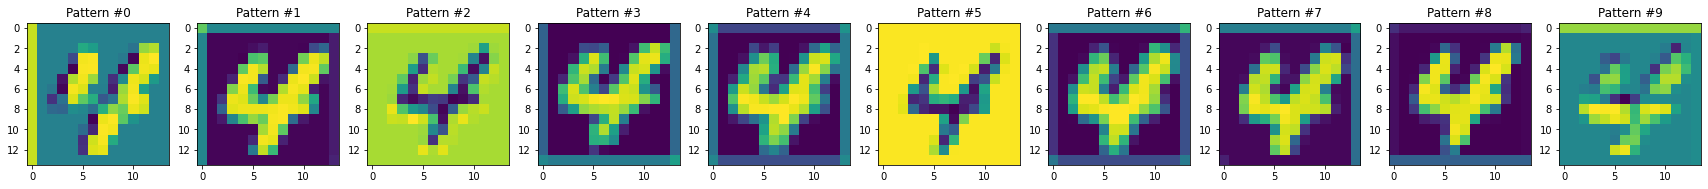

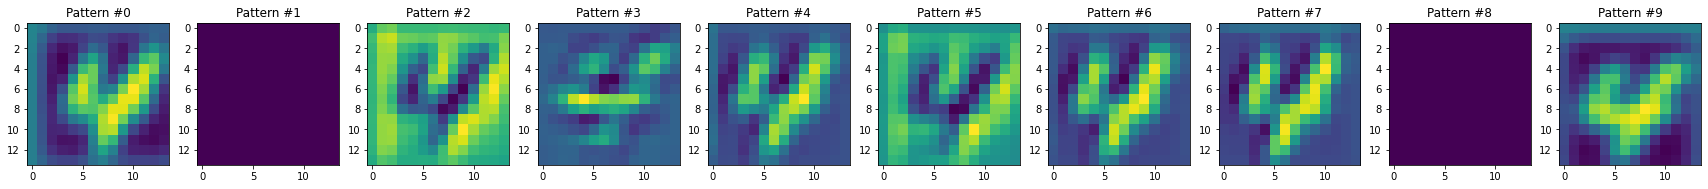

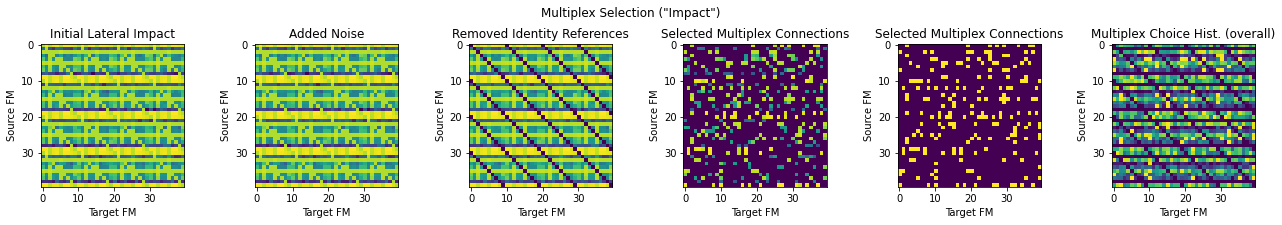

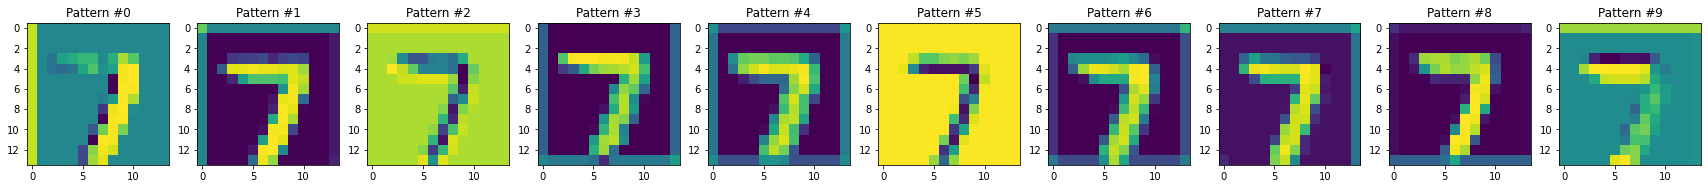

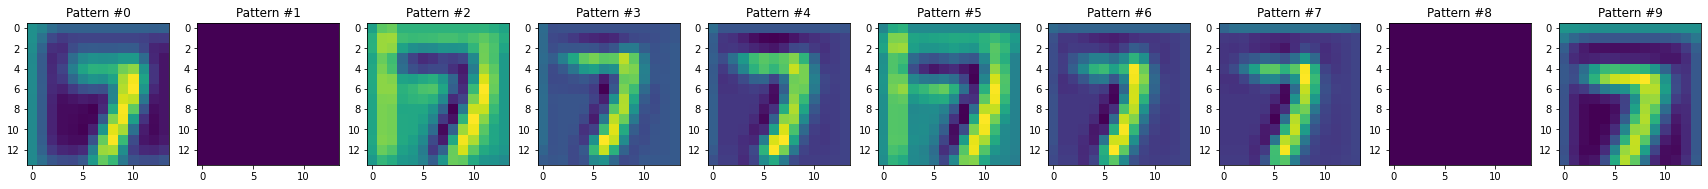

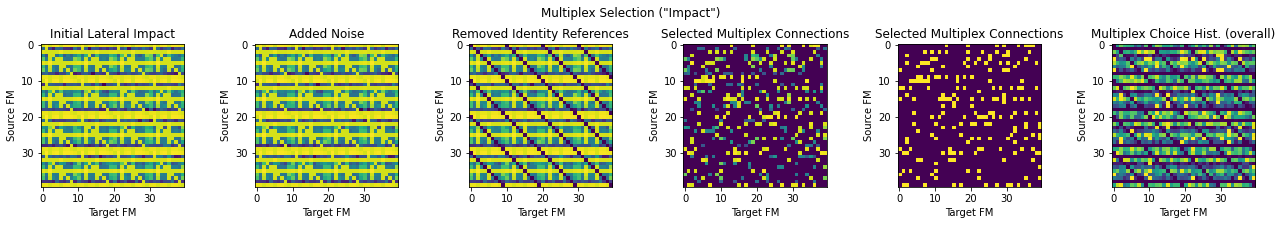

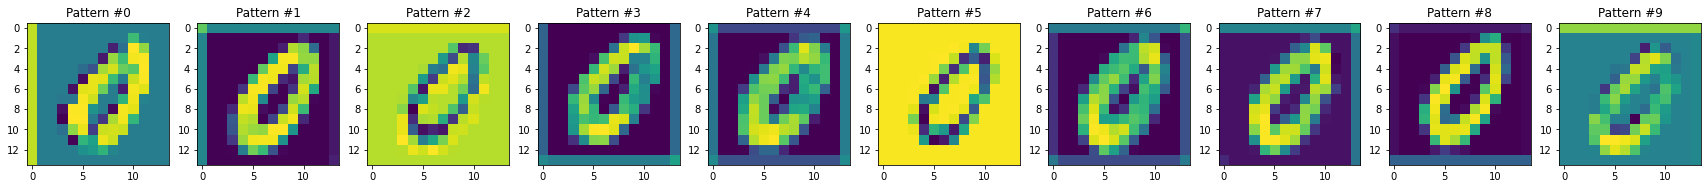

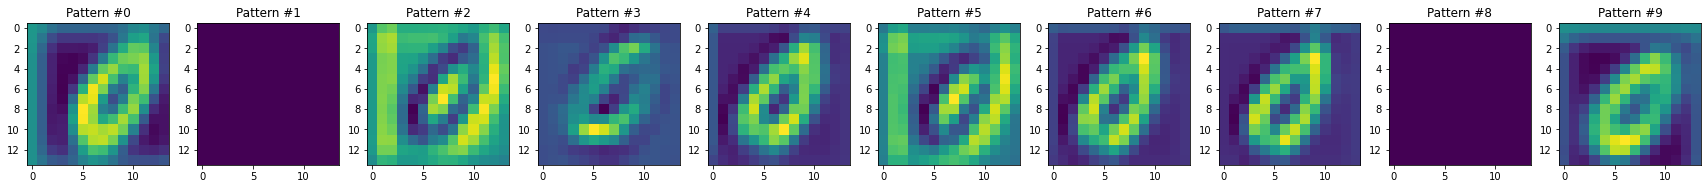

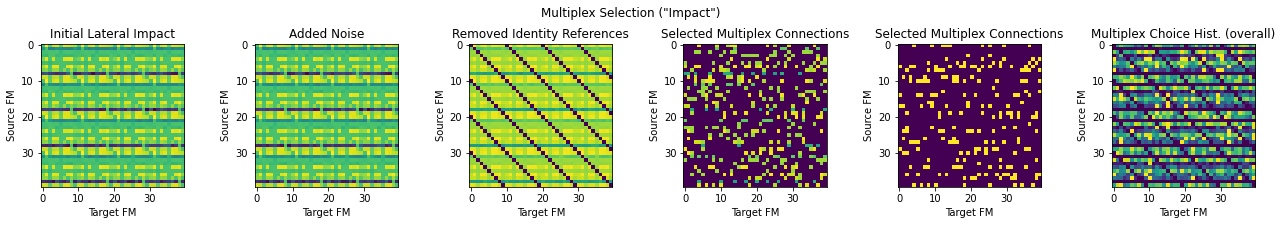

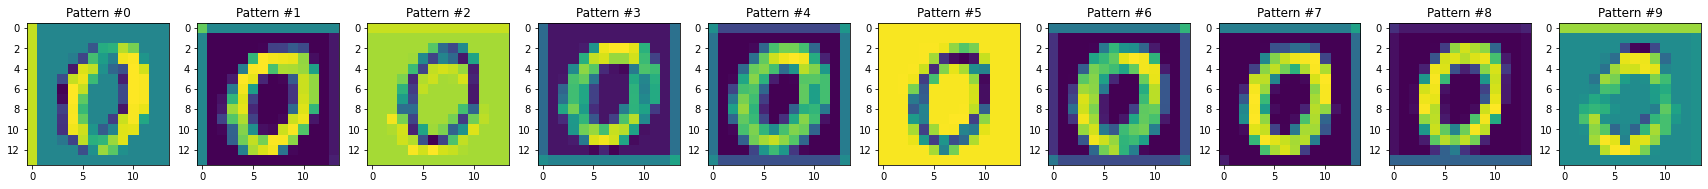

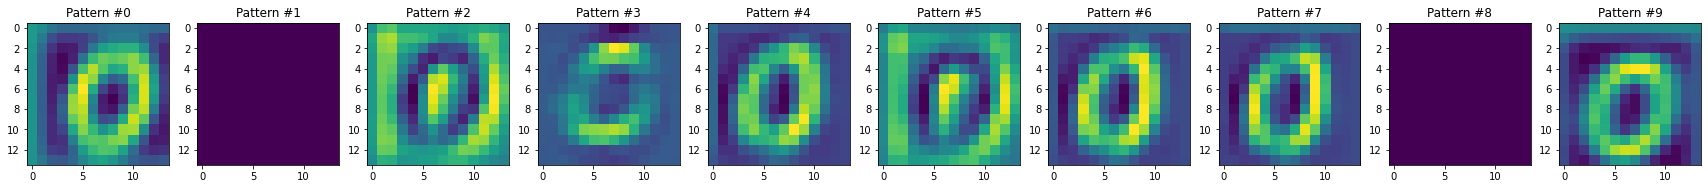

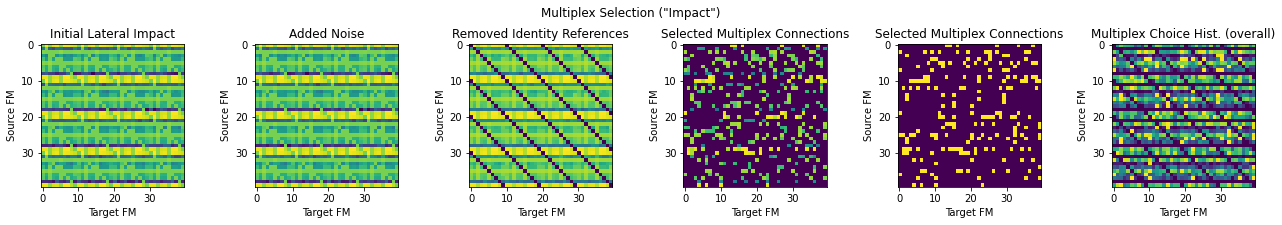

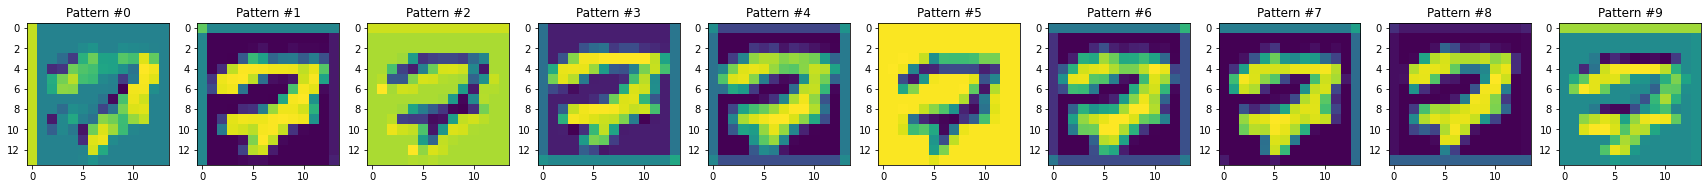

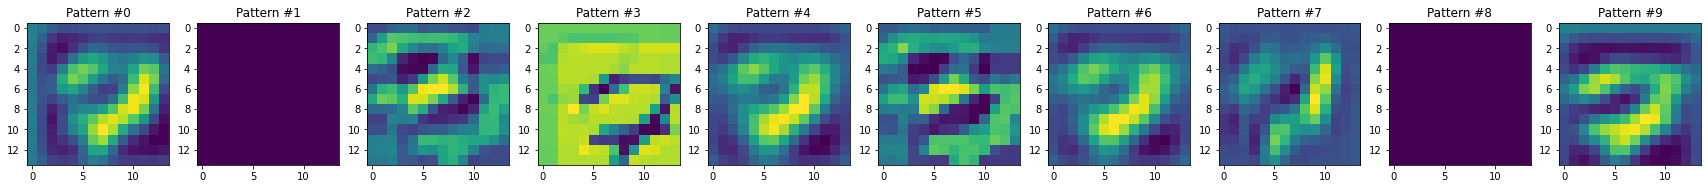

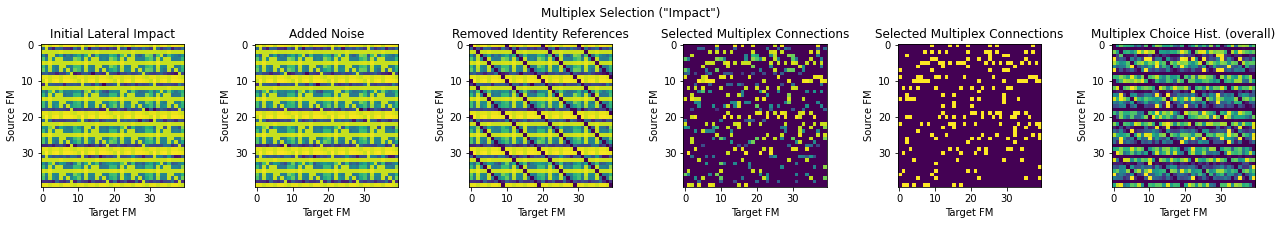

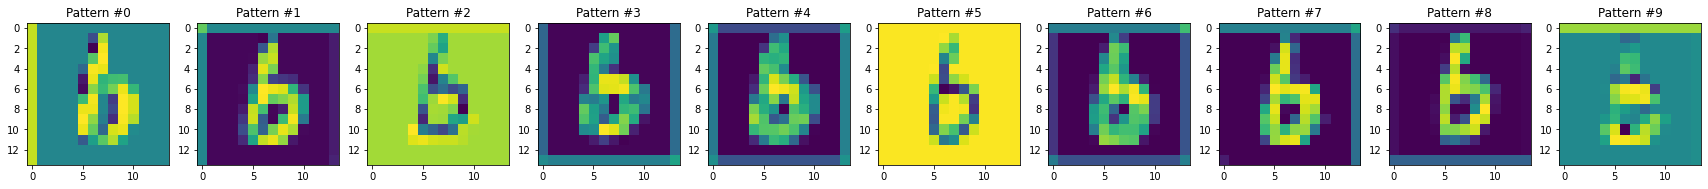

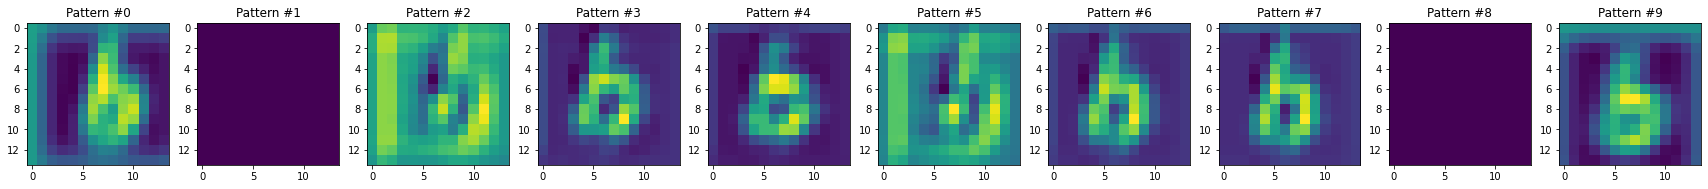

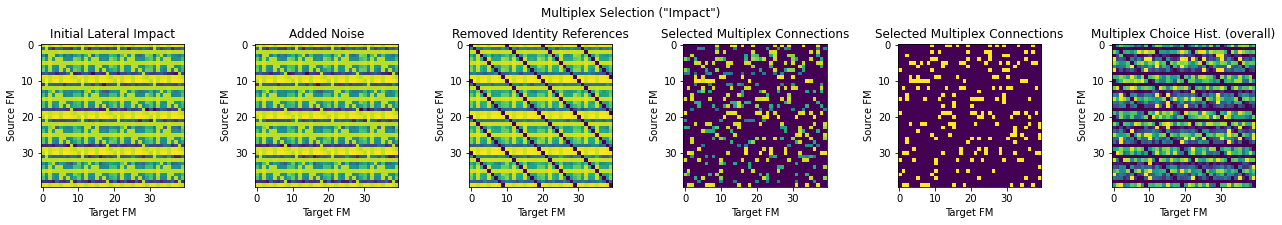

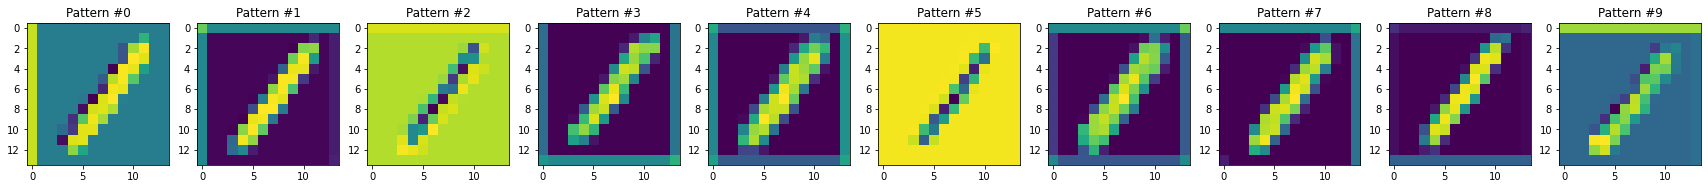

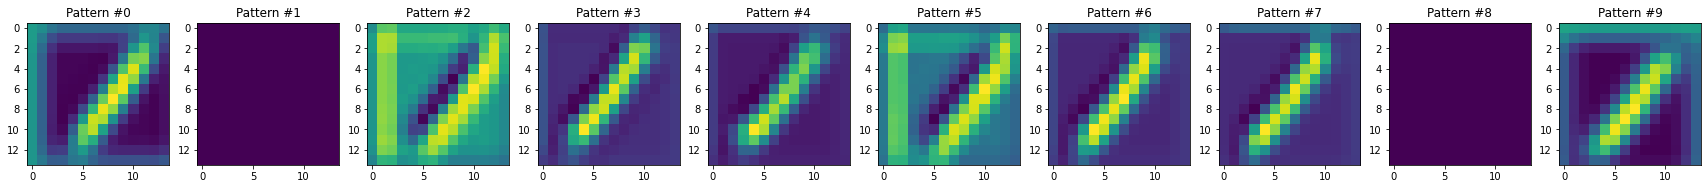

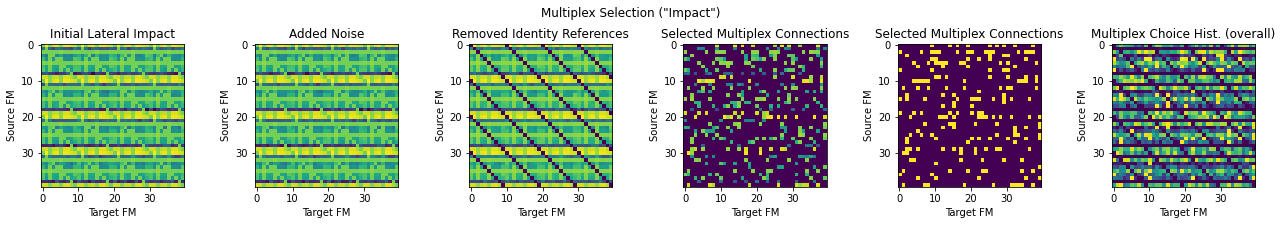

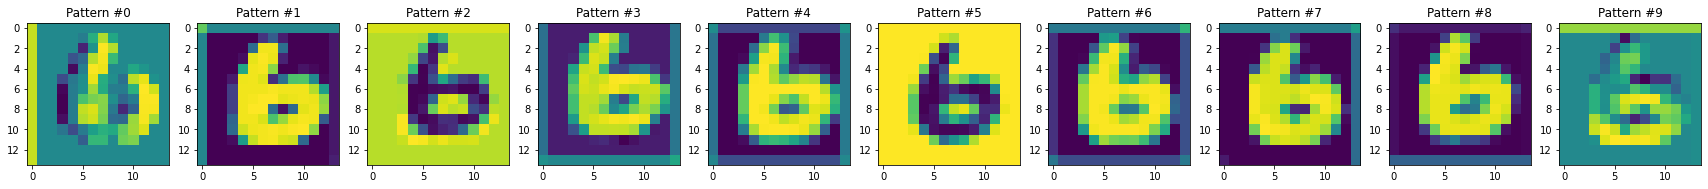

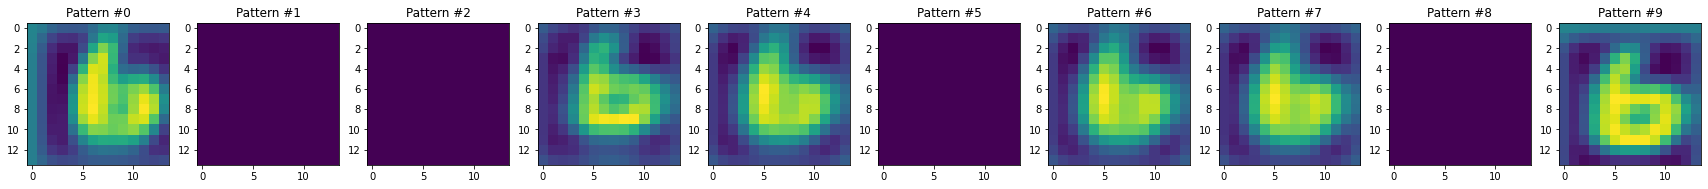

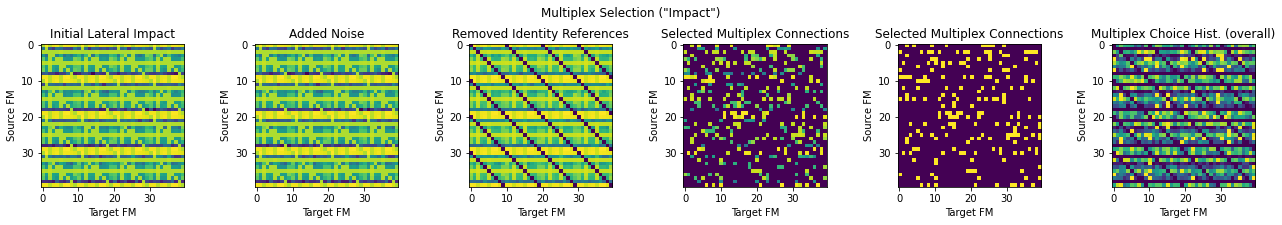

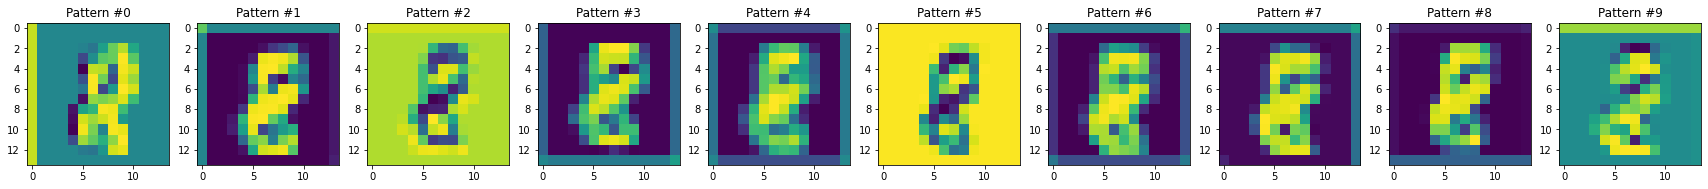

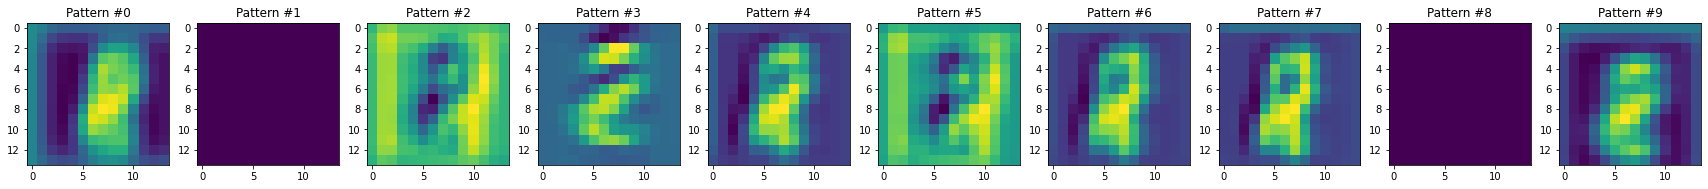

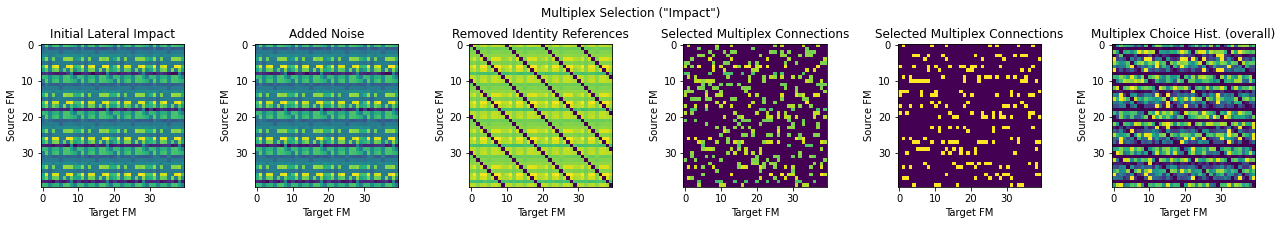

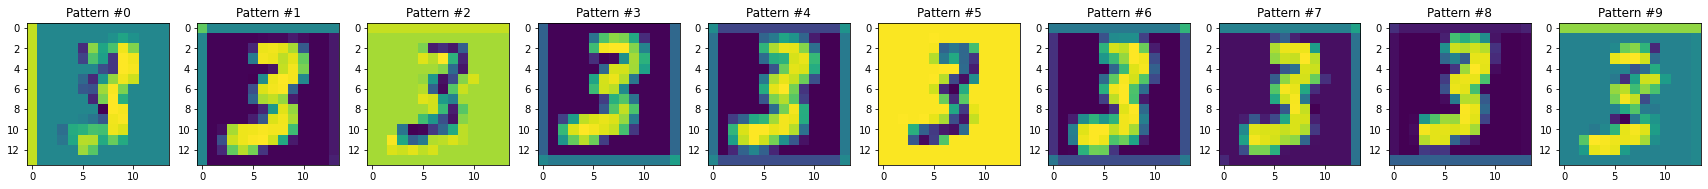

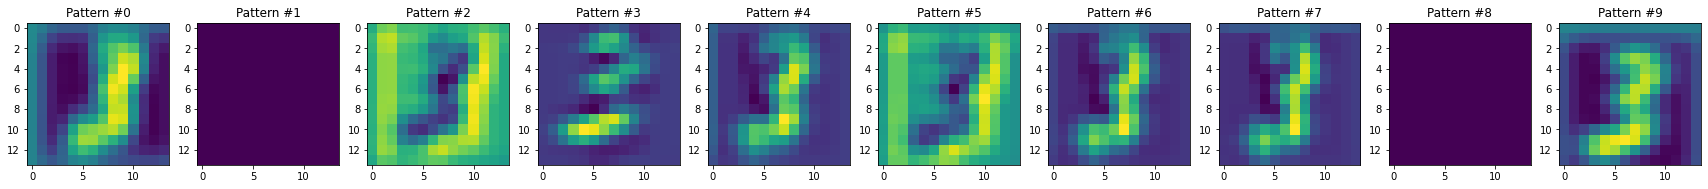

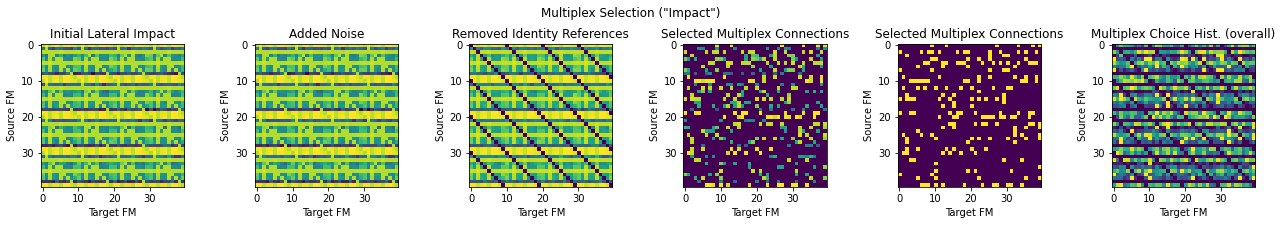

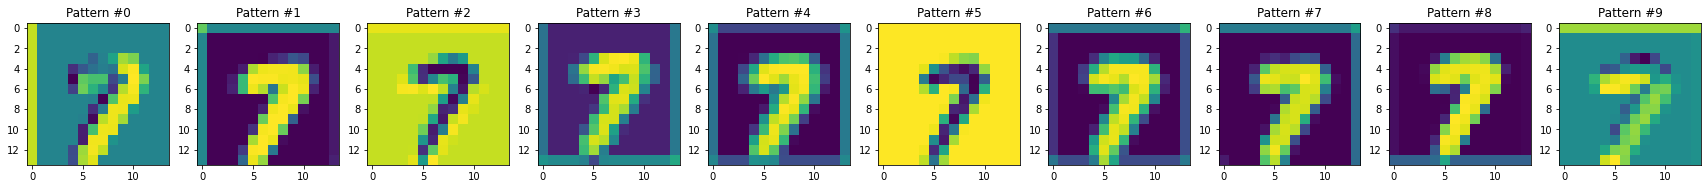

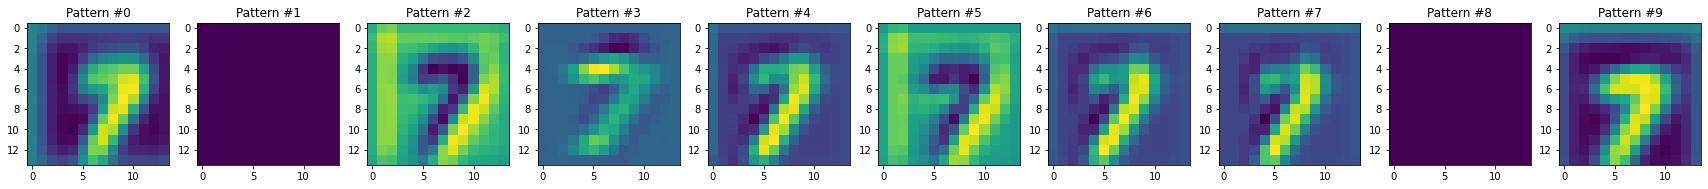

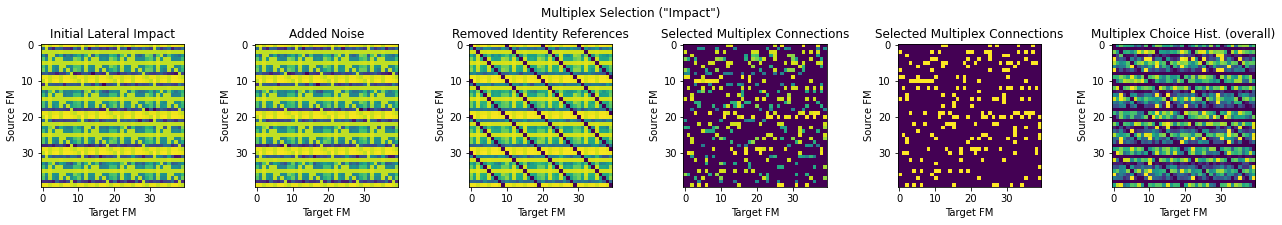

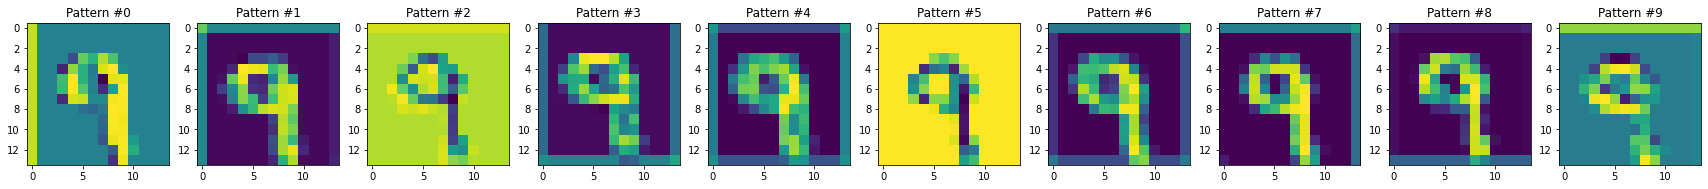

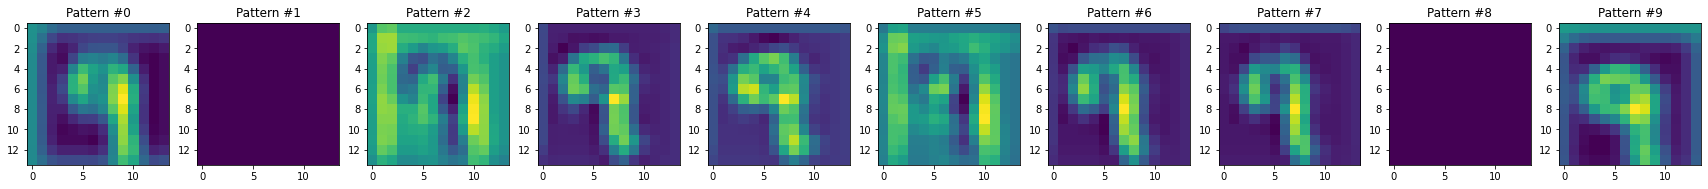

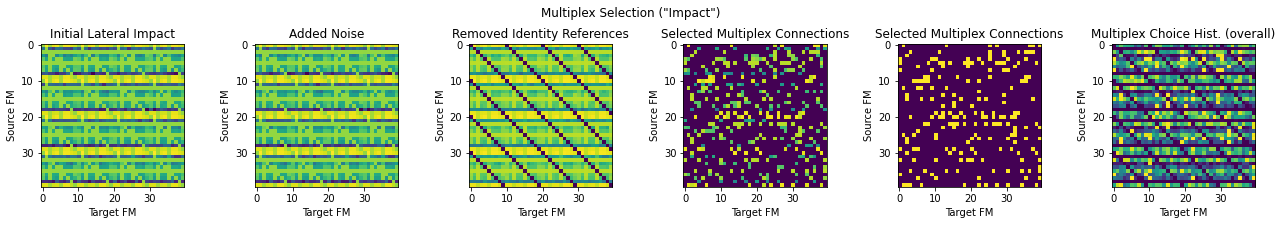

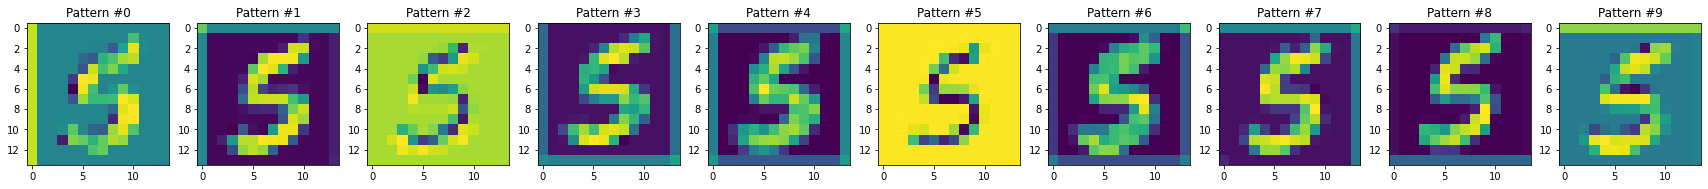

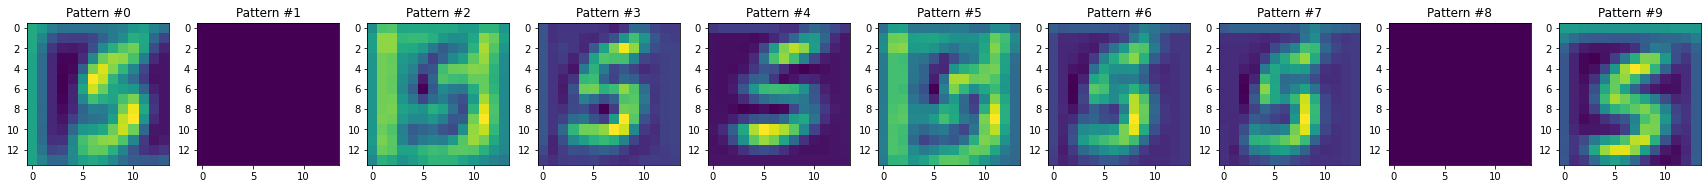

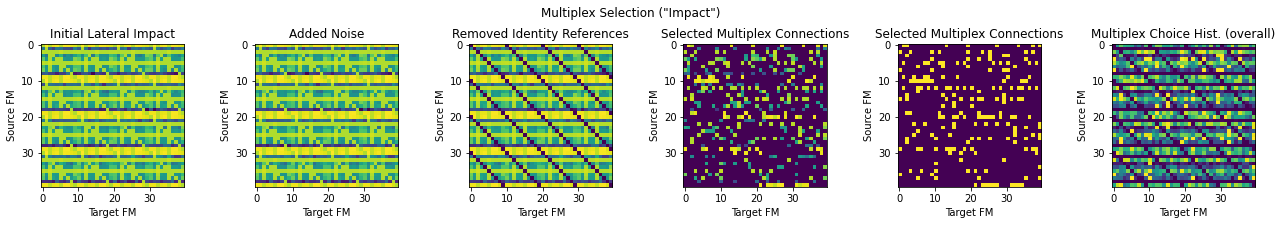

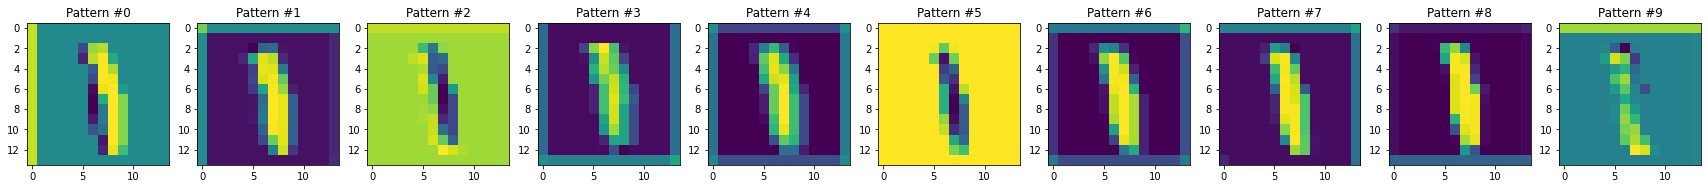

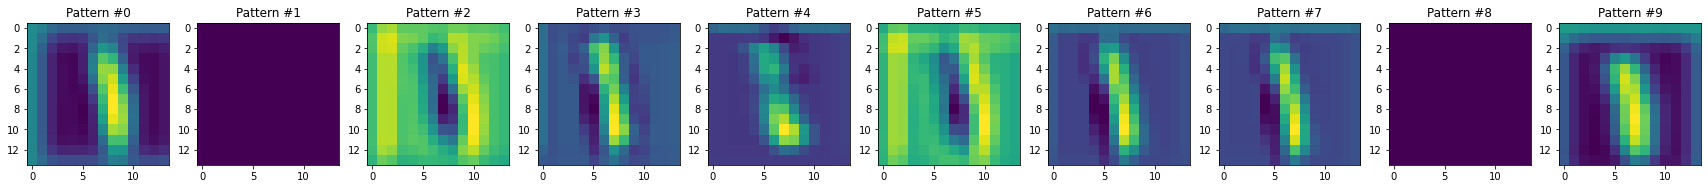

In [9]:
model.lcl.plot_debug = True
#def empty(*args, **kwargs):
#    pass
#model.lcl.forward_debug = empty
model.train_with_loader(train_loader, val_loader, num_epochs=1)

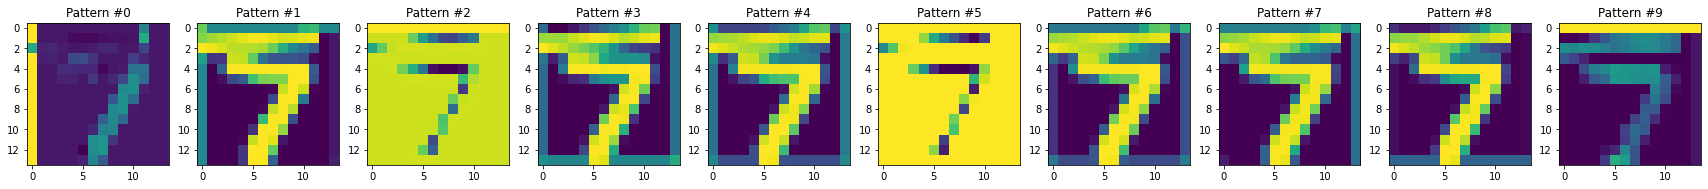

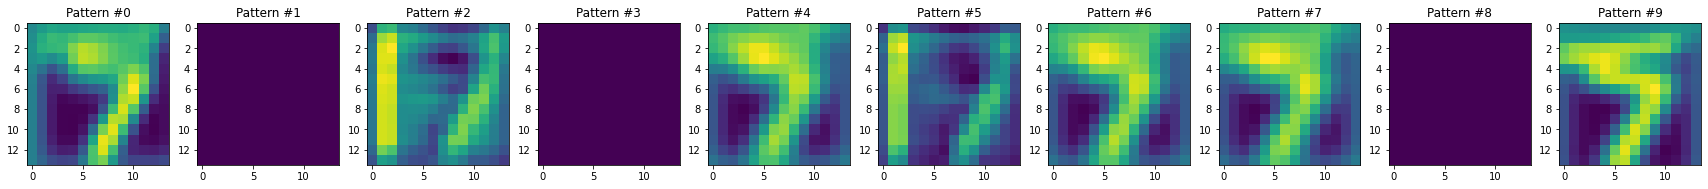

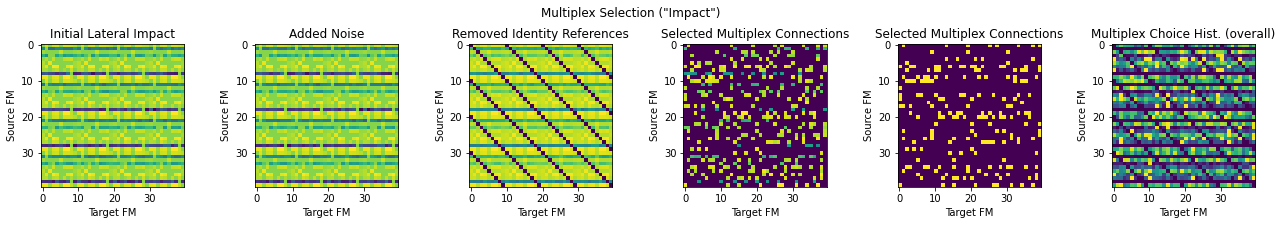

In [10]:
model.eval()
# set to multiple of 50 to plot images
model.lcl.iterations_trained -= model.lcl.iterations_trained % 50

imgs, lbl = next(iter(corrupt_loader))

model.forward(imgs.to(model.device))
None